In [1]:
from datetime import datetime, date, timedelta
import functools
from types import MappingProxyType


import numpy as np
import pandas as pd
import json
from scipy import interpolate
import seaborn as sns; sns.set()
import pathlib
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
from scipy.interpolate import InterpolatedUnivariateSpline
from sklearn.linear_model import RANSACRegressor
from shapely.ops import nearest_points
from abc import ABC, abstractmethod, abstractproperty
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt

plt.ioff()

pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.float_format", "{:,.6f}".format)

## Data files structure

In [2]:
!pwd

/home/budf/phuonglinh.le/Hermes/notebook


In [3]:
!ls -alt /data/ebms/feed/businfo/2020/03/15

total 1159492
drwxrwxr-x 24 dsa dsa      318 May 21  2020 ..
-rw-rw-r--  1 dsa dsa 47605061 Mar 15  2020 prediction_21h.json
drwxrwxr-x  2 dsa dsa     4096 Mar 15  2020 .
-rw-rw-r--  1 dsa dsa 50047657 Mar 15  2020 prediction_20h.json
-rw-rw-r--  1 dsa dsa 59513430 Mar 15  2020 prediction_19h.json
-rw-rw-r--  1 dsa dsa 69378577 Mar 15  2020 prediction_18h.json
-rw-rw-r--  1 dsa dsa 72372807 Mar 15  2020 prediction_17h.json
-rw-rw-r--  1 dsa dsa 72381320 Mar 15  2020 prediction_16h.json
-rw-rw-r--  1 dsa dsa 72135054 Mar 15  2020 prediction_15h.json
-rw-rw-r--  1 dsa dsa 71763119 Mar 15  2020 prediction_14h.json
-rw-rw-r--  1 dsa dsa 71048403 Mar 15  2020 prediction_13h.json
-rw-rw-r--  1 dsa dsa 71727397 Mar 15  2020 prediction_12h.json
-rw-rw-r--  1 dsa dsa 72239533 Mar 15  2020 prediction_11h.json
-rw-rw-r--  1 dsa dsa 72302369 Mar 15  2020 prediction_10h.json
-rw-rw-r--  1 dsa dsa 72405146 Mar 15  2020 prediction_09h.json
-rw-rw-r--  1 dsa dsa 72217159 Mar 15  2020 prediction_08h.js

In [4]:
!ls -alt /data/ebms/feed/prediction/ | tail -n 20

-rw-rw-r-- 1 dsa dsa   452582873 Mar 28  2020 2020_03_28.csv
-rw-rw-r-- 1 dsa dsa   743124206 Mar 27  2020 2020_03_27.csv
-rw-rw-r-- 1 dsa dsa   747475607 Mar 26  2020 2020_03_26.csv
-rw-rw-r-- 1 dsa dsa   752211941 Mar 25  2020 2020_03_25.csv
-rw-rw-r-- 1 dsa dsa   754962495 Mar 24  2020 2020_03_24.csv
-rw-rw-r-- 1 dsa dsa   737766171 Mar 23  2020 2020_03_23.csv
-rw-rw-r-- 1 dsa dsa   503091741 Mar 22  2020 2020_03_22.csv
-rw-rw-r-- 1 dsa dsa   509739280 Mar 21  2020 2020_03_21.csv
-rw-rw-r-- 1 dsa dsa   509456861 Mar 20  2020 2020_03_20.csv
-rw-rw-r-- 1 dsa dsa   764785808 Mar 19  2020 2020_03_19.csv
-rw-rw-r-- 1 dsa dsa   753736016 Mar 18  2020 2020_03_18.csv
-rw-rw-r-- 1 dsa dsa   764092487 Mar 17  2020 2020_03_17.csv
-rw-rw-r-- 1 dsa dsa   712088447 Mar 16  2020 2020_03_16.csv
-rw-rw-r-- 1 dsa dsa   767381282 Mar 15  2020 2020_03_15.csv
-rw-rw-r-- 1 dsa dsa   766060057 Mar 14  2020 2020_03_14.csv
-rw-rw-r-- 1 dsa dsa   767062090 Mar 13  2020 2020_03_13.csv
-rw-rw-r-- 1 dsa dsa   7

----------------

## All functions listed here

In [5]:
# List files name contains bus info
list_bus_info_file_names = [
    "stops.json", "paths.json",
    "vars.json", "trips.json", "timetables.json",
    "routes.json"
]

PREDICTION_PATH = r"/data/ebms/feed/prediction"
PREDICTION_COLUMN_HEADERS = (
    "REQUESTTIME", "STOPID", "ROUTEID", 
    "ROUTEVARID", "BUSID", "LOCTIMESTAMP", 
    "DISTANCE", "SPEED",
    "TIMETOSTOP", "UNAMED",
)
BUSINFO_PATH = r"/data/ebms/feed/businfo"
DATE_TO_LOAD = "20200316"  # Date to analysis

In [6]:
def get_date_from_str(str_date):
    return datetime.strptime(str_date, "%Y%m%d")


def get_bus_info_path(date, list_info_files):
    
    def date_to_path(date):
        return date.strftime("/%Y/%m/%d")
    
    path = pathlib.Path(BUSINFO_PATH + date_to_path(date))
    
    file_path = {
        p.name: str(p)
        for p 
        in path.iterdir()
        if p.name in list_info_files
    }
    
    for l in list_info_files:
        if not file_path[l]:
            file_path[l] = None
    
    return file_path


def get_prediction_path(date):
    def date_to_file_name(date):
        return date.strftime("/%Y_%m_%d.csv")
    
    path = pathlib.Path(PREDICTION_PATH + date_to_file_name(date))
    
    return str(path) if path.exists() else None


def read_dim_data(path, is_list_json=True):
    if is_list_json:
        vars_data = pd.read_json(path, lines=True).stack().reset_index(drop=True)

        vars_df = pd.io.json.json_normalize(vars_data[~vars_data.isna()])
    else:
        vars_df = pd.read_json(path, lines=True)
    
    return vars_df


def expand_column(stops_df, column):
    stops_df = stops_df.reset_index()

    stops_stag = pd.concat(
        [pd.DataFrame(d)
         for d 
         in stops_df[column]], 
        keys=stops_df["index"]
    ).reset_index(level=1, drop=True)

    stops_df = (
        stops_df.drop(["index"], axis=1)
            .join(stops_stag)
            .reset_index(drop=True)
    )
    
    return stops_df


def read_paths(path):
    paths_df = (
        read_dim_data(path, False)
            .set_index(["RouteId", "RouteVarId"])
            .apply(pd.Series.explode)
            .reset_index()
    )
    
    paths_df.loc[:, ["lat", "lng"]] = paths_df[["lat", "lng"]].astype(float)
    
    return paths_df


def read_stops(path):
    stops_df = expand_column(
        read_dim_data(path, False),
        "Stops"  # Column contains Stop data
    )
    
    return stops_df


def copy_data(data):
    
    return {key: value.copy() for key, value in data.items()}


def upper_columns_names(data):
    for k, v in data.items():
        v.columns = v.columns.str.upper()


def load_predictions(path, column_headers):
    print(path)
    return pd.read_csv(
        path,
        dtype="str",
        names=column_headers
    ).drop("UNAMED", axis=1)


def preprocessing_prediction(predic):
    predic_df = predic.copy()
    
    int_columns = ["STOPID", "ROUTEVARID", "ROUTEID"]
    float_columns = ["DISTANCE", "SPEED", "TIMETOSTOP"]
    
    predic_df[int_columns] = predic_df.loc[:, int_columns].astype("float").astype("int")
    predic_df[float_columns] = predic_df.loc[:, float_columns].astype("float")
    
    return predic_df


def get_stops_full_data(all_data):
    vars_pre = all_data["vars.json"].merge(
        all_data["routes.json"][["ROUTEID", "ROUTENAME"]],
        on="ROUTEID",
        how="left",
        suffixes=("", "_y")
    )
    display(vars_pre.head())
    
    all_data["full_vars"] = vars_pre
    
    stop_pre = all_data["stops.json"].merge(
        vars_pre,
        on=["ROUTEID", "ROUTEVARID"],
        how="left",
    ).drop("STOPS", axis=1).drop_duplicates()
    
    display(stop_pre.head())
    all_data["full_stops"] = stop_pre
    

def get_full_prediction_data(predic, stop_data):
    example = predic.copy()
    example_full = example.merge(
        stop_data,
        on=["STOPID", "ROUTEID", "ROUTEVARID"],
        how="left",
        suffixes=("", "_DIM")
    )
    
    return example_full

In [7]:
# Lấy toàn bộ đường dẫn đến các file chứa thông tin của xe bus.
get_bus_info_path(get_date_from_str(DATE_TO_LOAD), list_bus_info_file_names)

{'routes.json': '/data/ebms/feed/businfo/2020/03/16/routes.json',
 'timetables.json': '/data/ebms/feed/businfo/2020/03/16/timetables.json',
 'trips.json': '/data/ebms/feed/businfo/2020/03/16/trips.json',
 'vars.json': '/data/ebms/feed/businfo/2020/03/16/vars.json',
 'paths.json': '/data/ebms/feed/businfo/2020/03/16/paths.json',
 'stops.json': '/data/ebms/feed/businfo/2020/03/16/stops.json'}

In [8]:
# Lấy đường dẫn đến file prediction
get_prediction_path(get_date_from_str(DATE_TO_LOAD))

'/data/ebms/feed/prediction/2020_03_16.csv'

In [10]:
# List of functions to load data
BUS_INFO_FUNC = MappingProxyType({
    "timetables.json": functools.partial(read_dim_data, is_list_json=True),
    "routes.json": functools.partial(read_dim_data, is_list_json=True),
    "vars.json": functools.partial(read_dim_data, is_list_json=True),
    "trips.json": functools.partial(read_dim_data, is_list_json=True),
    "stops.json": functools.partial(
        read_stops
    ),
    "paths.json": functools.partial(
        read_paths
    ),
})

In [11]:
def get_all_bus_info(date, list_info_files):
    bus_data = {}
    
    bus_info_path = get_bus_info_path(date, list_info_files)
    
    for key, value in bus_info_path.items():
        print(f"Get data from {value}")
        bus_data[key] = BUS_INFO_FUNC[key](path=value)
        
    return bus_data

-------------

## Read all Bus Info

In [12]:
# Load data của các chuyến xe bus.
all_bus_data = get_all_bus_info(
    get_date_from_str(DATE_TO_LOAD), 
    list_info_files=list_bus_info_file_names
)

Get data from /data/ebms/feed/businfo/2020/03/16/routes.json
Get data from /data/ebms/feed/businfo/2020/03/16/timetables.json
Get data from /data/ebms/feed/businfo/2020/03/16/trips.json
Get data from /data/ebms/feed/businfo/2020/03/16/vars.json
Get data from /data/ebms/feed/businfo/2020/03/16/paths.json
Get data from /data/ebms/feed/businfo/2020/03/16/stops.json


In [13]:
# copy data to backup
all_data_cp = copy_data(all_bus_data)

In [14]:
# Upper all column names
upper_columns_names(all_data_cp)

In [15]:
# Lấy thông tin (merge thông tin) từ nhiều file
get_stops_full_data(all_data_cp)

ROUTEID  ROUTEVARID                                ROUTEVARNAME  \
0        7          13            Lượt đi: Bến xe Chợ Lớn - Gò vấp   
1        7          14            Lượt về: Gò vấp - Bến xe Chợ Lớn   
2        6           1  Lượt đi: Bến xe Chợ Lớn - Đại học Nông Lâm   
3        6           2  Lượt về: Đại học Nông Lâm - Bến xe Chợ Lớn   
4        5           1           Lượt đi: BX Biên Hòa - BX Chợ Lớn   

     ROUTEVARSHORTNAME ROUTENO         STARTSTOP           ENDSTOP  \
0               Gò vấp      07    Bến xe Chợ Lớn  BÃI HẬU CẦN SỐ 1   
1  Bến Xe Buýt Chợ Lớn      07  BÃI HẬU CẦN SỐ 1    Bến xe Chợ Lớn   
2     Đại học Nông Lâm      06    Bến xe Chợ Lớn  Đại học Nông Lâm   
3  Bến Xe Buýt Chợ Lớn      06  Đại học Nông Lâm    Bến xe Chợ Lớn   
4  Bến Xe Buýt Chợ Lớn      05   Bến xe Biên Hòa    Bến xe Chợ Lớn   

       DISTANCE  OUTBOUND  RUNNINGTIME                              ROUTENAME  
0 16,298.000000      True           70            Bến Xe Buýt Chợ Lớn- Gò vấp  
1 14,955.000000     False           70            Bến Xe Buýt Chợ Lớn- Gò vấp  
2 27,023.000000      True           70  Bến Xe Buýt Chợ Lớn- Đại học Nông Lâm  
3 26,877.000000     False           70  Bến Xe Buýt Chợ Lớn- Đại học Nông Lâm  
4 35,166.000000     False           95         Bến Xe Buýt Chợ Lớn - Biên Hòa

ROUTEID  ROUTEVARID  STOPID      CODE                        NAME  \
0        7          14     468      BX43            BÃI HẬU CẦN SỐ 1   
1        7          14     539   QGV 001            Bãi hậu cần số 1   
2        7          14     540   QGV 048               UBND Phường 5   
3        7          14     541   QGV 049  Trường Đại học Công nghiệp   
4        7          14     543  QGV 050          Ngã ba Phạm Ngũ Lão   

   STOPTYPE         ZONE  WARD         ADDRESSNO           STREET  \
0    Bến xe  Quận Gò Vấp  None  BÃI HẬU CẦN SỐ 1     Phan Văn Trị   
1  Trụ dừng  Quận Gò Vấp  None    Đối diện 439     Phan Văn Trị   
2  Trụ dừng  Quận Gò Vấp  None               247  Nguyễn Thái Sơn   
3  Trụ dừng  Quận Gò Vấp  None               145  Nguyễn Thái Sơn   
4  Trụ dừng  Quận Gò Vấp  None                63  Nguyễn Thái Sơn   

  SUPPORTDISABILITY          STATUS        LNG       LAT           SEARCH  \
0                    Đang khai thác 106.691895 10.823611  BHCS1 BHCS1 PVT   
1                    Đang khai thác 106.691950 10.823964  Bhcs1 Dd439 PVT   
2                    Đang khai thác 106.688259 10.825513      UP5 247 NTS   
3                    Đang khai thác 106.685277 10.822779    TDhCn 145 NTS   
4                    Đang khai thác 106.683925 10.821045     NbPNL 63 NTS   

         ROUTES                      ROUTEVARNAME    ROUTEVARSHORTNAME  \
0       07, 148  Lượt về: Gò vấp - Bến xe Chợ Lớn  Bến Xe Buýt Chợ Lớn   
1   07, 148, 36  Lượt về: Gò vấp - Bến xe Chợ Lớn  Bến Xe Buýt Chợ Lớn   
2  07, 146, 148  Lượt về: Gò vấp - Bến xe Chợ Lớn  Bến Xe Buýt Chợ Lớn   
3       07, 148  Lượt về: Gò vấp - Bến xe Chợ Lớn  Bến Xe Buýt Chợ Lớn   
4       07, 148  Lượt về: Gò vấp - Bến xe Chợ Lớn  Bến Xe Buýt Chợ Lớn   

  ROUTENO         STARTSTOP         ENDSTOP      DISTANCE  OUTBOUND  \
0      07  BÃI HẬU CẦN SỐ 1  Bến xe Chợ Lớn 14,955.000000     False   
1      07  BÃI HẬU CẦN SỐ 1  Bến xe Chợ Lớn 14,955.000000     False   
2      07  BÃI HẬU CẦN SỐ 1  Bến xe Chợ Lớn 14,955.000000     False   
3      07  BÃI HẬU CẦN SỐ 1  Bến xe Chợ Lớn 14,955.000000     False   
4      07  BÃI HẬU CẦN SỐ 1  Bến xe Chợ Lớn 14,955.000000     False   

   RUNNINGTIME                    ROUTENAME  
0           70  Bến Xe Buýt Chợ Lớn- Gò vấp  
1           70  Bến Xe Buýt Chợ Lớn- Gò vấp  
2           70  Bến Xe Buýt Chợ Lớn- Gò vấp  
3           70  Bến Xe Buýt Chợ Lớn- Gò vấp  
4           70  Bến Xe Buýt Chợ Lớn- Gò vấp

In [553]:
all_data_cp.keys()

dict_keys(['routes.json', 'timetables.json', 'trips.json', 'vars.json', 'paths.json', 'stops.json', 'full_vars', 'full_stops'])

In [556]:
# for i in ["full_vars", "full_stops"]:
#     all_data_cp[i].head(1000).to_excel("../data/result/{}_20210228.xlsx".format(i), index=False)

--------------

## Read predictions data

In [16]:
# read predictions file
prediction_data = load_predictions(
    get_prediction_path(get_date_from_str(DATE_TO_LOAD)),
    PREDICTION_COLUMN_HEADERS
)

/data/ebms/feed/prediction/2020_03_16.csv


In [17]:
prediction_df = prediction_data.copy()

In [18]:
prediction_df.head()

REQUESTTIME STOPID ROUTEID ROUTEVARID      BUSID  \
0  2020-03-16T04:00:04+07:00   1560      51          2    53N4414   
1  2020-03-16T04:00:04+07:00   1560      29          1    53N6032   
2  2020-03-16T04:00:04+07:00   7178     210          1  51HC00009   
3  2020-03-16T04:00:04+07:00   7178     210          1  51HC00012   
4  2020-03-16T04:00:04+07:00      8      76        152   51B26758   

                LOCTIMESTAMP  DISTANCE SPEED TIMETOSTOP  
0  2020-03-15T20:20:21+07:00     13.87  14.0          4  
1  2020-03-15T19:20:01+07:00  14578.97   7.0       3300  
2  2020-03-15T21:58:57+07:00     12.84   0.0          5  
3  2020-03-15T21:58:48+07:00   4422.09   0.0       1352  
4  2020-03-15T21:59:00+07:00     15.87   0.0          7

In [19]:
# convert some columns from str to int, float or datetime
prediction_df = preprocessing_prediction(prediction_df)

In [20]:
prediction_df.head()

REQUESTTIME  STOPID  ROUTEID  ROUTEVARID      BUSID  \
0  2020-03-16T04:00:04+07:00    1560       51           2    53N4414   
1  2020-03-16T04:00:04+07:00    1560       29           1    53N6032   
2  2020-03-16T04:00:04+07:00    7178      210           1  51HC00009   
3  2020-03-16T04:00:04+07:00    7178      210           1  51HC00012   
4  2020-03-16T04:00:04+07:00       8       76         152   51B26758   

                LOCTIMESTAMP      DISTANCE     SPEED   TIMETOSTOP  
0  2020-03-15T20:20:21+07:00     13.870000 14.000000     4.000000  
1  2020-03-15T19:20:01+07:00 14,578.970000  7.000000 3,300.000000  
2  2020-03-15T21:58:57+07:00     12.840000  0.000000     5.000000  
3  2020-03-15T21:58:48+07:00  4,422.090000  0.000000 1,352.000000  
4  2020-03-15T21:59:00+07:00     15.870000  0.000000     7.000000

In [21]:
# check missing records
prediction_df.isna().sum().to_frame("MISSINGRECORDS")

MISSINGRECORDS
REQUESTTIME                0
STOPID                     0
ROUTEID                    0
ROUTEVARID                 0
BUSID                      0
LOCTIMESTAMP               0
DISTANCE                   0
SPEED                      0
TIMETOSTOP                 0

In [481]:
# Lấy thông tin của Stops vào Prediction
full_predic = get_full_prediction_data(prediction_df, all_data_cp["full_stops"])

In [482]:
full_predic.head()

REQUESTTIME  STOPID  ROUTEID  ROUTEVARID      BUSID  \
0  2020-03-16T04:00:04+07:00    1560       51           2    53N4414   
1  2020-03-16T04:00:04+07:00    1560       29           1    53N6032   
2  2020-03-16T04:00:04+07:00    7178      210           1  51HC00009   
3  2020-03-16T04:00:04+07:00    7178      210           1  51HC00012   
4  2020-03-16T04:00:04+07:00       8       76         152   51B26758   

                LOCTIMESTAMP      DISTANCE     SPEED   TIMETOSTOP   CODE  \
0  2020-03-15T20:20:21+07:00     13.870000 14.000000     4.000000   BX54   
1  2020-03-15T19:20:01+07:00 14,578.970000  7.000000 3,300.000000   BX54   
2  2020-03-15T21:58:57+07:00     12.840000  0.000000     5.000000  Q1 D1   
3  2020-03-15T21:58:48+07:00  4,422.090000  0.000000 1,352.000000  Q1 D1   
4  2020-03-15T21:59:00+07:00     15.870000  0.000000     7.000000   BX14   

              NAME STOPTYPE          ZONE             WARD  \
0  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú             None   
1  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú             None   
2    Thảo cầm viên   Bến xe        Quận 1  Phường Bến Nghé   
3    Thảo cầm viên   Bến xe        Quận 1  Phường Bến Nghé   
4   Bến xe Chợ Lớn   Bến xe        Quận 5             None   

                     ADDRESSNO             STREET SUPPORTDISABILITY  \
0  Bến xe buýt Cư xá Nhiêu Lộc      Lê Thúc Hoạch                     
1  Bến xe buýt Cư xá Nhiêu Lộc      Lê Thúc Hoạch                     
2                            2  Nguyễn Bỉnh Khiêm                Có   
3                            2  Nguyễn Bỉnh Khiêm                Có   
4              GA HKXB CHO LON      Lê Quang Sung                     

           STATUS        LNG       LAT            SEARCH  \
0  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH   
1  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH   
2  Đang khai thác 106.705243 10.787311         Tcv 2 NBK   
3  Đang khai thác 106.705243 10.787311         Tcv 2 NBK   
4  Đang khai thác 106.652565 10.751253     BxCL GHCL LQS   

                                                                 ROUTES  \
0                                                               144, 30   
1                                                               144, 30   
2                                                                    D1   
3                                                                    D1   
4  01, 05, 06, 07, 09, 150, 23, 47, 56, 62-1, 62-10, 62-7, 62-8, 81, 94   

                                           ROUTEVARNAME ROUTEVARSHORTNAME  \
0                       Lượt về: ĐH Quốc tế - Tân Hương     Chợ Tân Hương   
1            Lượt đi: Bến xe Miền Tây - Cư xá Nhiêu Lộc      CX Nhiêu Lộc   
2                                               Lượt đi     THẢO CẦM VIÊN   
3                                               Lượt đi     THẢO CẦM VIÊN   
4  Lượt về: Đại học Giao thông Vận tải - Bến xe Chợ Lớn    Bến xe Chợ Lớn   

  ROUTENO                      STARTSTOP          ENDSTOP  DISTANCE_DIM  \
0      30  Đường nội bộ Đại học Quốc gia  Cư xá Nhiêu Lộc 33,712.000000   
1     144                Bến xe Miền Tây  Cư xá Nhiêu Lộc 15,025.000000   
2      D1            Bến xe buýt Sài Gòn    Thảo cầm viên  6,264.000000   
3      D1            Bến xe buýt Sài Gòn    Thảo cầm viên  6,264.000000   
4      56   KTX Đại học Sư phạm kỹ thuật   Bến xe Chợ Lớn 27,508.000000   

  OUTBOUND  RUNNINGTIME  \
0    False    95.000000   
1     True    55.000000   
2     True    30.000000   
3     True    30.000000   
4    False    80.000000   

                                                      ROUTENAME  
0                               Chợ Tân Hương - Đại học Quốc tế  
1  Bến Xe Buýt  Miền Tây -  Chợ Lớn - CV Đầm Sen - CX Nhiêu Lộc  
2                                  CÔNG VIÊN 23/9-THẢO CẦM VIÊN  
3                                  CÔNG VIÊN 23/9-THẢO CẦM VIÊN  
4                   Bến xe Chợ Lớn - Đại học Giao thông Vận tải

In [559]:
full_predic.head(1000).to_excel("../data/result/full_prediction_20210228.xlsx", index=False)

* Keys combination: RouteID - RouteVarID - StopID

In [24]:
def remove_missing_records_on_column(data, cols):
    missing_rec_mask = data[cols].isna().any(axis=1)
    
    return data[~missing_rec_mask].copy()

In [484]:
full_predic[full_predic.CODE.isna()].head()

REQUESTTIME  STOPID  ROUTEID  ROUTEVARID     BUSID  \
126  2020-03-16T04:00:04+07:00      35       72         144   53N4981   
400  2020-03-16T04:00:04+07:00    7477      285           2  51B00304   
448  2020-03-16T04:00:04+07:00    7512      316           1  51B03829   
736  2020-03-16T04:00:14+07:00      35       72         144   53N4981   
990  2020-03-16T04:00:14+07:00    7477      285           2  51B00304   

                  LOCTIMESTAMP      DISTANCE     SPEED   TIMETOSTOP CODE NAME  \
126  2020-01-18T18:29:37+07:00    219.860000 12.000000    74.000000  NaN  NaN   
400  2020-01-09T06:23:03+07:00  1,382.710000 31.000000   248.000000  NaN  NaN   
448  2020-01-17T17:48:17+07:00 14,070.200000 14.000000 2,537.000000  NaN  NaN   
736  2020-01-18T18:29:37+07:00    219.860000 12.000000    74.000000  NaN  NaN   
990  2020-01-09T06:23:03+07:00  1,382.710000 31.000000   248.000000  NaN  NaN   

    STOPTYPE ZONE WARD ADDRESSNO STREET SUPPORTDISABILITY STATUS  LNG  LAT  \
126      NaN  NaN  NaN       NaN    NaN               NaN    NaN  nan  nan   
400      NaN  NaN  NaN       NaN    NaN               NaN    NaN  nan  nan   
448      NaN  NaN  NaN       NaN    NaN               NaN    NaN  nan  nan   
736      NaN  NaN  NaN       NaN    NaN               NaN    NaN  nan  nan   
990      NaN  NaN  NaN       NaN    NaN               NaN    NaN  nan  nan   

    SEARCH ROUTES ROUTEVARNAME ROUTEVARSHORTNAME ROUTENO STARTSTOP ENDSTOP  \
126    NaN    NaN          NaN               NaN     NaN       NaN     NaN   
400    NaN    NaN          NaN               NaN     NaN       NaN     NaN   
448    NaN    NaN          NaN               NaN     NaN       NaN     NaN   
736    NaN    NaN          NaN               NaN     NaN       NaN     NaN   
990    NaN    NaN          NaN               NaN     NaN       NaN     NaN   

     DISTANCE_DIM OUTBOUND  RUNNINGTIME ROUTENAME  
126           nan      NaN          nan       NaN  
400           nan      NaN          nan       NaN  
448           nan      NaN          nan       NaN  
736           nan      NaN          nan       NaN  
990           nan      NaN          nan       NaN

Mising data of stop 35, 7477,...

In [485]:
full_predic.isna().sum()

REQUESTTIME                0
STOPID                     0
ROUTEID                    0
ROUTEVARID                 0
BUSID                      0
LOCTIMESTAMP               0
DISTANCE                   0
SPEED                      0
TIMETOSTOP                 0
CODE                   19422
NAME                   19422
STOPTYPE               19422
ZONE                   19422
WARD                 6290599
ADDRESSNO              19422
STREET                 19422
SUPPORTDISABILITY      19422
STATUS                 19422
LNG                    19422
LAT                    19422
SEARCH                 19422
ROUTES                 19422
ROUTEVARNAME           19422
ROUTEVARSHORTNAME      19422
ROUTENO                19422
STARTSTOP              19422
ENDSTOP                19422
DISTANCE_DIM           19422
OUTBOUND               19422
RUNNINGTIME            19422
ROUTENAME              19422
dtype: int64

In [493]:
19422 / full_predic.shape[0]

0.002452034335045709

In [486]:
full_predic_bk = full_predic.copy()

In [487]:
# Remove missing values for column CODE
full_predic = remove_missing_records_on_column(full_predic, ["CODE"])

In [488]:
full_predic.isna().sum()

REQUESTTIME                0
STOPID                     0
ROUTEID                    0
ROUTEVARID                 0
BUSID                      0
LOCTIMESTAMP               0
DISTANCE                   0
SPEED                      0
TIMETOSTOP                 0
CODE                       0
NAME                       0
STOPTYPE                   0
ZONE                       0
WARD                 6271177
ADDRESSNO                  0
STREET                     0
SUPPORTDISABILITY          0
STATUS                     0
LNG                        0
LAT                        0
SEARCH                     0
ROUTES                     0
ROUTEVARNAME               0
ROUTEVARSHORTNAME          0
ROUTENO                    0
STARTSTOP                  0
ENDSTOP                    0
DISTANCE_DIM               0
OUTBOUND                   0
RUNNINGTIME                0
ROUTENAME                  0
dtype: int64

## Finding Stop Seqences

Example to finding Stop sequences for only 1 route

In [29]:
all_data_cp["paths.json"].sort_values(["ROUTEID", "ROUTEVARID"]).head(200)

ROUTEID  ROUTEVARID       LAT        LNG
4049        1           1 10.776790 106.705856
4050        1           1 10.775818 106.706291
4051        1           1 10.775765 106.706146
4052        1           1 10.775691 106.706055
4053        1           1 10.775522 106.705956
4054        1           1 10.775344 106.705948
4055        1           1 10.775186 106.705971
4056        1           1 10.775017 106.706032
4057        1           1 10.774837 106.706268
4058        1           1 10.774775 106.706482
4059        1           1 10.773299 106.706360
4060        1           1 10.773299 106.706360
4061        1           1 10.771022 106.706215
4062        1           1 10.770927 106.706161
4063        1           1 10.770864 106.706055
4064        1           1 10.770885 106.705551
4065        1           1 10.770885 106.705551
4066        1           1 10.771006 106.703110
4067        1           1 10.771006 106.703110
4068        1           1 10.771043 106.701851
4069        1           1 10.771043 106.701851
4070        1           1 10.771075 106.699471
4071        1           1 10.771075 106.699471
4072        1           1 10.771001 106.698921
4073        1           1 10.769446 106.699936
4074        1           1 10.769251 106.699669
4075        1           1 10.769251 106.699669
4076        1           1 10.767713 106.698044
4077        1           1 10.769352 106.696442
4078        1           1 10.768772 106.695923
4079        1           1 10.768772 106.695923
4080        1           1 10.767363 106.694695
4081        1           1 10.767363 106.694695
4082        1           1 10.765832 106.693375
4083        1           1 10.765832 106.693375
4084        1           1 10.763918 106.691696
4085        1           1 10.763918 106.691696
4086        1           1 10.762262 106.690247
4087        1           1 10.762262 106.690247
4088        1           1 10.759409 106.687798
4089        1           1 10.759380 106.687843
4090        1           1 10.757980 106.686577
4091        1           1 10.757420 106.686089
4092        1           1 10.757467 106.686035
4093        1           1 10.757467 106.686035
4094        1           1 10.756509 106.685211
4095        1           1 10.755887 106.682831
4096        1           1 10.755887 106.682831
4097        1           1 10.755887 106.682831
4098        1           1 10.755623 106.681831
4099        1           1 10.755623 106.681831
4100        1           1 10.755064 106.679794
4101        1           1 10.755064 106.679794
4102        1           1 10.754537 106.677849
4103        1           1 10.754537 106.677849
4104        1           1 10.753984 106.675827
4105        1           1 10.753984 106.675827
4106        1           1 10.753573 106.674240
4107        1           1 10.753573 106.674240
4108        1           1 10.753573 106.674240
4109        1           1 10.753004 106.672028
4110        1           1 10.752983 106.671494
4111        1           1 10.752983 106.671494
4112        1           1 10.752983 106.671494
4113        1           1 10.752725 106.669464
4114        1           1 10.753457 106.669525
4115        1           1 10.753025 106.668587
4116        1           1 10.753025 106.668587
4117        1           1 10.753025 106.668587
4118        1           1 10.752572 106.667748
4119        1           1 10.752477 106.666176
4120        1           1 10.752477 106.666176
4121        1           1 10.752477 106.666176
4122        1           1 10.752292 106.663704
4123        1           1 10.752292 106.663704
4124        1           1 10.752292 106.663704
4125        1           1 10.752092 106.661995
4126        1           1 10.752060 106.660538
4127        1           1 10.752161 106.662018
4128        1           1 10.752161 106.662018
4129        1           1 10.752108 106.661400
4130        1           1 10.752039 106.658844
4131        1           1 10.751381 106.658897
4132        1           1 10.751381 106.658897
4133       

In [30]:
# Get example for 1 ROUTE (ID = 1 AND VARID = 2)
msk_exp = (
    (all_data_cp["paths.json"].ROUTEID == 1)
    & (all_data_cp["paths.json"].ROUTEVARID == 2)
)
example_route = all_data_cp["paths.json"][msk_exp].copy()

example_route = example_route.merge(
    all_data_cp["full_vars"],
    on=["ROUTEID", "ROUTEVARID"],
    how="left",
    suffixes=("", "VARINFO")
)

In [31]:
# Get example stops info (ID=1, VARID=2)
msk_example = (
    (all_data_cp["stops.json"].ROUTEID == 1)
    & (all_data_cp["stops.json"].ROUTEVARID == 2)
)
example_stop = all_data_cp["stops.json"][msk_example].copy()

In [32]:
# create line from long lat in path.
line = LineString(example_route[["LNG" ,"LAT"]].values)

# For path
example_route["GEOPOINT"] = example_route.apply(lambda x: Point(x["LNG"], x["LAT"]), axis=1)
route_gpd = gpd.GeoDataFrame(example_route, geometry="GEOPOINT")
route_gpd["TYPE"] = "POINT"

line = route_gpd.groupby(["ROUTEID", "ROUTEVARID"]).GEOPOINT.apply(LineString).values[0]
route_line = route_gpd.iloc[0, :].copy()
route_line["TYPE"] = "PATH"
route_line.GEOPOINT = line
added_line = route_gpd.append(route_line, ignore_index=True)

In [33]:
# For Stop
example_stop["GEOPOINT"] = example_stop.apply(lambda x: Point(x["LNG"], x["LAT"]), axis=1)
stop_gpd = gpd.GeoDataFrame(example_stop, geometry="GEOPOINT")

# Finding nearest point
stop_gpd["NEARESTPOINT"] = stop_gpd.GEOPOINT.transform(lambda x: nearest_points(x, line)[1])

In [34]:
# Ranking by distance of point along the path(line)
stop_gpd["DISTANCE"] = stop_gpd.GEOPOINT.transform(lambda x: line.project(x))
stop_gpd["RANK"] = stop_gpd.DISTANCE.rank(method="first")

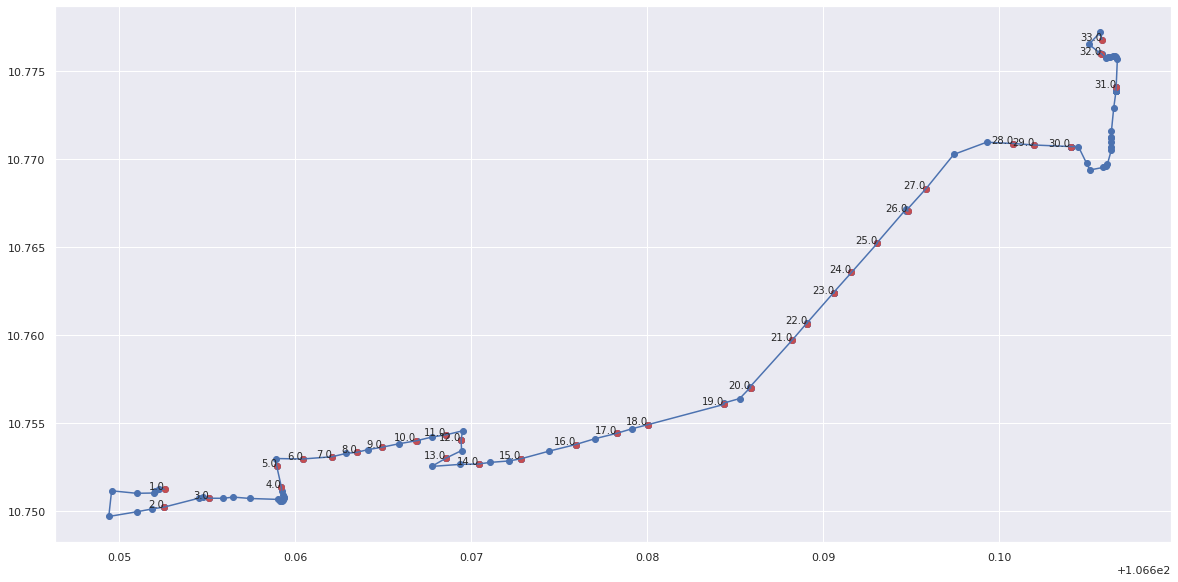

In [35]:
# Example plot result
fig, ax = plt.subplots(figsize=(20, 20))
added_line.plot(ax=ax, figure=fig)
# stop_gpd.plot(ax=ax, figure=fig, color="r", marker="v")
for i, x in stop_gpd.iterrows():
    plt.annotate(s=x["RANK"], xy=(x["LNG"], x["LAT"]), horizontalalignment="right")
stop_gpd.set_geometry("NEARESTPOINT").copy().plot(ax=ax, figure=fig, color="r", alpha=1)
plt.show()

Note:
- Trục hoành: Long
- Trục tung: Lat 

We see here: 
* Blue dot: cặp Long-Lat ghi nhận trong file Path, cho phép vẽ được định tuyến của con đường. 
* Red dot: Cặp Long-Lat của Stop, cho phép xác định vị trí của stops trên tuyến. 
* Ranking 1,2,3,...: Cho biết thứ tự các stop trên route dựa vào distance của Stop với điểm Starting point. Max value = length of route (Đơn vị độ (Long-Lat)) (Project Ranking/ Distance by Ration)

In [494]:
stop_gpd.head()

STOPS  \
650  [{'StopId': 8, 'Code': 'BX14', 'Name': 'Bến xe Chợ Lớn', 'StopType': 'Bến xe', 'Zone': 'Quận 5',...   
651  [{'StopId': 8, 'Code': 'BX14', 'Name': 'Bến xe Chợ Lớn', 'StopType': 'Bến xe', 'Zone': 'Quận 5',...   
652  [{'StopId': 8, 'Code': 'BX14', 'Name': 'Bến xe Chợ Lớn', 'StopType': 'Bến xe', 'Zone': 'Quận 5',...   
653  [{'StopId': 8, 'Code': 'BX14', 'Name': 'Bến xe Chợ Lớn', 'StopType': 'Bến xe', 'Zone': 'Quận 5',...   
654  [{'StopId': 8, 'Code': 'BX14', 'Name': 'Bến xe Chợ Lớn', 'StopType': 'Bến xe', 'Zone': 'Quận 5',...   

     ROUTEID  ROUTEVARID  STOPID    CODE             NAME  STOPTYPE    ZONE  \
650        1           2       8    BX14   Bến xe Chợ Lớn    Bến xe  Quận 5   
651        1           2       1  Q6 095       Chu Văn An  Trụ dừng  Quận 6   
652        1           2       2  Q5 016     Chợ Kim Biên  Trụ dừng  Quận 5   
653        1           2       3  Q5 011  Bưu điện Quận 5     Ô sơn  Quận 5   
654        1           2       5  Q5 012    Rạp Đại Quang   Nhà chờ  Quận 5   

     WARD        ADDRESSNO              STREET SUPPORTDISABILITY  \
650  None  GA HKXB CHO LON       Lê Quang Sung                     
651  None               27           Tháp Mười                     
652  None            11-12  Hải Thượng Lãn Ông                     
653  None            14-16       Châu Văn Liêm                     
654  None               68       Châu Văn Liêm                     

             STATUS        LNG       LAT          SEARCH  \
650  Đang khai thác 106.652565 10.751253   BxCL GHCL LQS   
651  Đang khai thác 106.652554 10.750232       CVA 27 TM   
652  Đang khai thác 106.655075 10.750732  CKB 11-12 HTLO   
653  Đang khai thác 106.659203 10.751368  BdQ5 14-16 CVL   
654  Đang khai thác 106.658937 10.752566      RDQ 68 CVL   

                                                                   ROUTES  \
650  01, 05, 06, 07, 09, 150, 23, 47, 56, 62-1, 62-10, 62-7, 62-8, 81, 94   
651                                              01, 07, 10, 144, 150, 25   
652                                            01, 05, 07, 25, 39, 47, 56   
653                                            01, 05, 07, 08, 45, 56, 62   
654                                        01, 05, 07, 08, 10, 45, 56, 62   

                       GEOPOINT                NEARESTPOINT  DISTANCE     RANK  
650  POINT (106.65257 10.75125)  POINT (106.65256 10.75125)  0.000000 1.000000  
651  POINT (106.65255 10.75023)  POINT (106.65255 10.75023)  0.007780 2.000000  
652  POINT (106.65507 10.75073)  POINT (106.65508 10.75073)  0.010396 3.000000  
653  POINT (106.65920 10.75137)  POINT (106.65920 10.75137)  0.015450 4.000000  
654  POINT (106.65894 10.75257)  POINT (106.65894 10.75257)  0.016677 5.000000

Distance ration: https://shapely.readthedocs.io/en/stable/manual.html

For all path we got.

In [510]:
def get_linestring_all_path(path):
    paths_df = path.dropna().copy()

    paths_df["POINT"] = paths_df.apply(lambda x: Point(x["LNG"], x["LAT"]), axis=1)

    lines_df = (
        paths_df.groupby(["ROUTEID", "ROUTEVARID"])
            .POINT.apply(list)
            .apply(LineString)
            .to_frame("LINESTRING")
            .reset_index()
    )
    
    return lines_df

In [511]:
line_string = get_linestring_all_path(all_data_cp["paths.json"])

In [512]:
stops_ddf = all_data_cp["stops.json"].copy()
stops_ddf = stops_ddf.dropna(subset=["LNG", "LAT"]).copy()
stops_ddf = stops_ddf.merge(
    line_string,
    on=["ROUTEID", "ROUTEVARID"],
    how="inner",
    suffixes=("", "LINEINFO")
)

stops_ddf["SPOINT"] = stops_ddf.apply(lambda x: Point(x["LNG"], x["LAT"]), axis=1)
# stops_ddf["NEARESTPOINT"] = stops_ddf.SPOINT.transform(lambda x: nearest_points(x, line)[1])
stops_ddf["DISTANCE"] = stops_ddf.apply(lambda x: x["LINESTRING"].project(x["SPOINT"]), axis=1)
stops_ddf["RANK"] = stops_ddf.groupby(["ROUTEID", "ROUTEVARID"]).DISTANCE.rank(method="first")

In [513]:
# final data with ranking of stops id
stops_ddf = stops_ddf.sort_values(["ROUTEID", "ROUTEVARID", "RANK"])

In [540]:
stops_ddf.drop_duplicates(["ROUTEID", "ROUTEVARID"]).head(20)

STOPS  \
514   [{'StopId': 33, 'Code': 'BX 06', 'Name': 'Công Trường Mê Linh', 'StopType': 'Bến xe', 'Zone': 'Q...   
650   [{'StopId': 8, 'Code': 'BX14', 'Name': 'Bến xe Chợ Lớn', 'StopType': 'Bến xe', 'Zone': 'Quận 5',...   
271   [{'StopId': 33, 'Code': 'BX 06', 'Name': 'Công Trường Mê Linh', 'StopType': 'Bến xe', 'Zone': 'Q...   
231   [{'StopId': 725, 'Code': 'BX 46', 'Name': 'Bến xe Miền Tây', 'StopType': 'Bến xe', 'Zone': 'Quận...   
748   [{'StopId': 35, 'Code': 'BX 01', 'Name': 'Bến xe buýt Sài Gòn', 'StopType': 'Bến xe', 'Zone': 'Q...   
463   [{'StopId': 75, 'Code': 'BX38', 'Name': 'THẠNH LỘC', 'StopType': 'Bến xe', 'Zone': 'Quận 12', '...   
416   [{'StopId': 35, 'Code': 'BX 01', 'Name': 'Bến xe buýt Sài Gòn', 'StopType': 'Bến xe', 'Zone': 'Q...   
543   [{'StopId': 166, 'Code': 'BX41', 'Name': 'Bến xe An Sương', 'StopType': 'Bến xe', 'Zone': 'Quận ...   
111   [{'StopId': 7208, 'Code': 'BXLT Bien Hoa', 'Name': 'Bến xe Biên Hòa', 'StopType': 'Bến xe', 'Zon...   
357   [{'StopId': 8, 'Code': 'BX14', 'Name': 'Bến xe Chợ Lớn', 'StopType': 'Bến xe', 'Zone': 'Quận 5',...   
180   [{'StopId': 8, 'Code': 'BX14', 'Name': 'Bến xe Chợ Lớn', 'StopType': 'Bến xe', 'Zone': 'Quận 5',...   
50    [{'StopId': 394, 'Code': 'BX73', 'Name': 'Đại học Nông Lâm', 'StopType': 'Bến xe', 'Zone': 'Quận...   
313   [{'StopId': 8, 'Code': 'BX14', 'Name': 'Bến xe Chợ Lớn', 'StopType': 'Bến xe', 'Zone': 'Quận 5',...   
0     [{'StopId': 468, 'Code': 'BX43', 'Name': 'BÃI HẬU CẦN SỐ 1', 'StopType': 'Bến xe', 'Zone': 'Quận...   
582   [{'StopId': 496, 'Code': 'BX 20', 'Name': 'Bến xe buýt Quận 8', 'StopType': 'Bến xe', 'Zone': 'Q...   
683   [{'StopId': 538, 'Code': 'BX87', 'Name': 'Đại học Quốc gia', 'StopType': 'Bến xe', 'Zone': 'Quận...   
1095  [{'StopId': 8, 'Code': 'BX14', 'Name': 'Bến xe Chợ Lớn', 'StopType': 'Bến xe', 'Zone': 'Quận 5',...   
1036  [{'StopId': 3043, 'Code': 'BX 58', 'Name': 'Hưng Long', 'StopType': 'Bến xe', 'Zone': 'Huyện Bìn...   
1371  [{'StopId': 538, 'Code': 'BX87', 'Name': 'Đại học Quốc gia', 'StopType': 'Bến xe', 'Zone': 'Quận...   
1268  [{'StopId': 725, 'Code': 'BX 46', 'Name': 'Bến xe Miền Tây', 'StopType': 'Bến xe', 'Zone': 'Quận...   

      ROUTEID  ROUTEVARID  STOPID           CODE                 NAME  \
514         1           1      33          BX 06  Công Trường Mê Linh   
650         1           2       8           BX14       Bến xe Chợ Lớn   
271         2           1      33          BX 06  Công Trường Mê Linh   
231         2           2     725          BX 46      Bến xe Miền Tây   
748         3           5      35          BX 01  Bến xe buýt Sài Gòn   
463         3           6      75           BX38           THẠNH LỘC   
416         4           7      35          BX 01  Bến xe buýt Sài Gòn   
543         4           8     166           BX41      Bến xe An Sương   
111         5           1    7208  BXLT Bien Hoa      Bến xe Biên Hòa   
357         5           2       8           BX14       Bến xe Chợ Lớn   
180         6           1       8           BX14       Bến xe Chợ Lớn   
50          6           2     394           BX73     Đại học Nông Lâm   
313         7          13       8           BX14       Bến xe Chợ Lớn   
0           7          14     468           BX43     BÃI HẬU CẦN SỐ 1   
582         8          15     496          BX 20   Bến xe buýt Quận 8   
683         8          16     538           BX87     Đại học Quốc gia   
1095        9           1       8           BX14       Bến xe Chợ Lớn   
1036        9           2    3043          BX 58            Hưng Long   
1371       10          19     538           BX87     Đại học Quốc gia   
1268       10          20     725          BX 46      Bến xe Miền Tây   

     STOPTYPE              ZONE                 WARD  \
514    Bến xe            Quận 1                 None   
650    Bến xe            Quận 5                 None   
271    Bến xe            Quận 1                 None   
231    Bến xe     Quận Bình Tân                 None

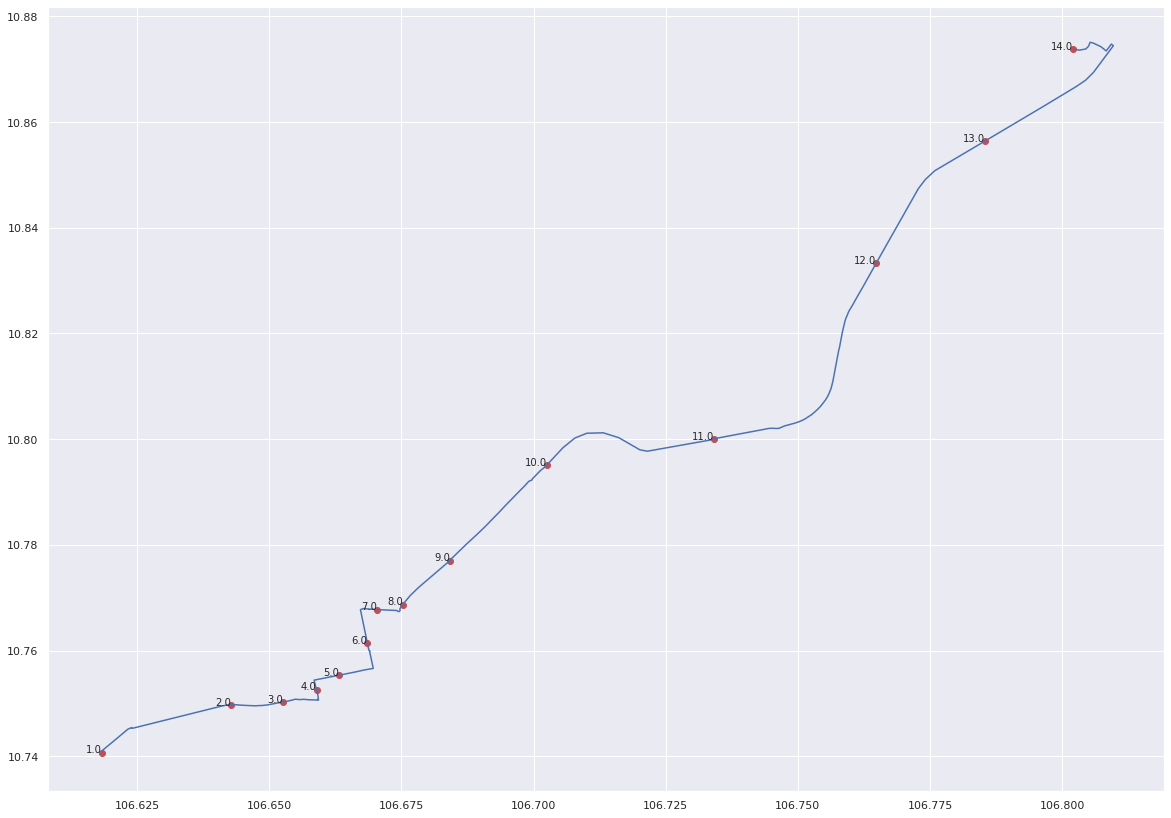

In [563]:
# Plot example for routevar
new_example = stops_ddf.query("ROUTEID==10 & ROUTEVARID==20").copy()
# Example plot result
fig, ax = plt.subplots(figsize=(20, 20))
gpd.GeoSeries(new_example.LINESTRING.values[0]).plot(ax=ax, figure=fig)
# stop_gpd.plot(ax=ax, figure=fig, color="r", marker="v")
for i, x in new_example.iterrows():
    plt.annotate(s=x["RANK"], xy=(x["LNG"], x["LAT"]), horizontalalignment="right")
new_example.set_geometry("SPOINT").copy().plot(ax=ax, figure=fig, color="r", alpha=1)
plt.show()

-------------

## Calculate distance ratio & time for each stops along its path

**Objective**: 
Using Interpolate with x (Distance) & y (Time):
* X: Distance/Distance_Dim (Khoang cach di chuyen / Tong quang duong) (Khoảng cách từ 1 điểm đến trạm cuối)
* Y: LocTimeStamp (Time)
* X': Distance calculated by ration of Long-Lat (Vị trí của Stop trên toàn tuyến)
* Y': ? Time to Stop, giá trị cần dự báo 

Note: 
* X, Y là giá trị đã biết ở Prediction
* X' là ratio của Long-Lat ở Stop
* Distance_Dim là giá trị đã có ở file Var (Someone inputs here)

In [40]:
predic_df = full_predic.copy()

In [41]:
# Convert to integer for easier to predict
predic_df["TIMESTAMP"] = pd.to_datetime(predic_df["LOCTIMESTAMP"]).astype("int64") // 10**9

In [545]:
predic_df.sort_values("LOCTIMESTAMP").head()

REQUESTTIME  STOPID  ROUTEID  ROUTEVARID    BUSID  \
7440806  2020-03-16T20:09:47+07:00    6845       70           1  53N4973   
7115843  2020-03-16T19:15:04+07:00    6845       70           1  53N4973   
5116868  2020-03-16T15:13:01+07:00    6845       70           1  53N4973   
2155064  2020-03-16T09:22:32+07:00    6845       70           1  53N4973   
5115435  2020-03-16T15:12:51+07:00    6845       70           1  53N4973   

                     LOCTIMESTAMP  DISTANCE     SPEED  TIMETOSTOP   CODE  \
7440806 2020-01-14 20:04:47+07:00 29.350000 23.000000    5.000000  BX 87   
7115843 2020-01-14 20:04:47+07:00 29.350000 23.000000    5.000000  BX 87   
5116868 2020-01-14 20:04:47+07:00 29.350000 23.000000    5.000000  BX 87   
2155064 2020-01-14 20:04:47+07:00 29.350000 23.000000    5.000000  BX 87   
5115435 2020-01-14 20:04:47+07:00 29.350000 23.000000    5.000000  BX 87   

                                        NAME STOPTYPE          ZONE  \
7440806  Đầu bến Đại học Bách Khoa - Cơ sở 2   Bến xe  Quận Thủ Đức   
7115843  Đầu bến Đại học Bách Khoa - Cơ sở 2   Bến xe  Quận Thủ Đức   
5116868  Đầu bến Đại học Bách Khoa - Cơ sở 2   Bến xe  Quận Thủ Đức   
2155064  Đầu bến Đại học Bách Khoa - Cơ sở 2   Bến xe  Quận Thủ Đức   
5115435  Đầu bến Đại học Bách Khoa - Cơ sở 2   Bến xe  Quận Thủ Đức   

                      WARD          ADDRESSNO             STREET  \
7440806  Phường Bình Chiểu  Đại học Bách Khoa  Đại học Bách Khoa   
7115843  Phường Bình Chiểu  Đại học Bách Khoa  Đại học Bách Khoa   
5116868  Phường Bình Chiểu  Đại học Bách Khoa  Đại học Bách Khoa   
2155064  Phường Bình Chiểu  Đại học Bách Khoa  Đại học Bách Khoa   
5115435  Phường Bình Chiểu  Đại học Bách Khoa  Đại học Bách Khoa   

        SUPPORTDISABILITY          STATUS        LNG       LAT  \
7440806                Có  Chưa khai thác 106.806378 10.880932   
7115843                Có  Chưa khai thác 106.806378 10.880932   
5116868                Có  Chưa khai thác 106.806378 10.880932   
2155064                Có  Chưa khai thác 106.806378 10.880932   
5115435                Có  Chưa khai thác 106.806378 10.880932   

                       SEARCH ROUTES  \
7440806  DbDhBK-Cs2 DhBK DhBK     50   
7115843  DbDhBK-Cs2 DhBK DhBK     50   
5116868  DbDhBK-Cs2 DhBK DhBK     50   
2155064  DbDhBK-Cs2 DhBK DhBK     50   
5115435  DbDhBK-Cs2 DhBK DhBK     50   

                                                               ROUTEVARNAME  \
7440806  Lượt đi: ĐH Bách Khoa TP HCM - Đầu bến Đại học Bách Khoa - Cơ sở 2   
7115843  Lượt đi: ĐH Bách Khoa TP HCM - Đầu bến Đại học Bách Khoa - Cơ sở 2   
5116868  Lượt đi: ĐH Bách Khoa TP HCM - Đầu bến Đại học Bách Khoa - Cơ sở 2   
2155064  Lượt đi: ĐH Bách Khoa TP HCM - Đầu bến Đại học Bách Khoa - Cơ sở 2   
5115435  Lượt đi: ĐH Bách Khoa TP HCM - Đầu bến Đại học Bách Khoa - Cơ sở 2   

        ROUTEVARSHORTNAME ROUTENO            STARTSTOP  \
7440806  Đại học Quốc gia      50  ĐH BÁCH KHOA TP HCM   
7115843  Đại học Quốc gia      50  ĐH BÁCH KHOA TP HCM   
5116868  Đại học Quốc gia      50  ĐH BÁCH KHOA TP HCM   
2155064  Đại học Quốc gia      50  ĐH BÁCH KHOA TP HCM   
5115435  Đại học Quốc gia      50  ĐH BÁCH KHOA TP HCM   

                                     ENDSTOP  DISTANCE_DIM OUTBOUND  \
7440806  Đầu bến Đại học Bách Khoa - Cơ sở 2 28,317.000000     True   
7115843  Đầu bến Đại học Bách Khoa - Cơ sở 2 28,317.000000     True   
5116868  Đầu bến Đại học Bách Khoa - Cơ sở 2 28,317.000000     True   
2155064  Đầu bến Đại học Bách Khoa - Cơ sở 2 28,317.000000     True   
5115435  Đầu bến Đại học Bách Khoa - Cơ sở 2 28,317.000000     True   

         RUNNINGTIME                             ROUTENAME   TIMESTAMP  \
7440806    65.000000  Đại học Bách khoa - Đại học Quốc gia  1579007087   
7115843    65.000000  Đại học Bách khoa - Đại học Quốc gia  1579007087   
5116868    65.000000  Đại học Bách khoa - Đại học Quốc gia  1579007087   
2155064    65.000000  Đại học Bách khoa - Đại học Quốc gia  1579007087   
5115435    65.

In [43]:
# preprocessing some columns in predic data
predic_df["BUSIDSTR"] = predic_df["BUSID"].str.strip()  #remove space
predic_df["LOCTIMESTAMP"] = pd.to_datetime(predic_df["LOCTIMESTAMP"])  #convert to datetime
predic_df["STOPIDSTR"] = predic_df["STOPID"].astype("str")  #convert to string
predic_df["DISTANCERATIO"] = predic_df.eval("DISTANCE / DISTANCE_DIM")

In [415]:
predic_df.head()

REQUESTTIME  STOPID  ROUTEID  ROUTEVARID      BUSID  \
0  2020-03-16T04:00:04+07:00    1560       51           2    53N4414   
1  2020-03-16T04:00:04+07:00    1560       29           1    53N6032   
2  2020-03-16T04:00:04+07:00    7178      210           1  51HC00009   
3  2020-03-16T04:00:04+07:00    7178      210           1  51HC00012   
4  2020-03-16T04:00:04+07:00       8       76         152   51B26758   

               LOCTIMESTAMP      DISTANCE     SPEED   TIMETOSTOP   CODE  \
0 2020-03-15 20:20:21+07:00     13.870000 14.000000     4.000000   BX54   
1 2020-03-15 19:20:01+07:00 14,578.970000  7.000000 3,300.000000   BX54   
2 2020-03-15 21:58:57+07:00     12.840000  0.000000     5.000000  Q1 D1   
3 2020-03-15 21:58:48+07:00  4,422.090000  0.000000 1,352.000000  Q1 D1   
4 2020-03-15 21:59:00+07:00     15.870000  0.000000     7.000000   BX14   

              NAME STOPTYPE          ZONE             WARD  \
0  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú             None   
1  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú             None   
2    Thảo cầm viên   Bến xe        Quận 1  Phường Bến Nghé   
3    Thảo cầm viên   Bến xe        Quận 1  Phường Bến Nghé   
4   Bến xe Chợ Lớn   Bến xe        Quận 5             None   

                     ADDRESSNO             STREET SUPPORTDISABILITY  \
0  Bến xe buýt Cư xá Nhiêu Lộc      Lê Thúc Hoạch                     
1  Bến xe buýt Cư xá Nhiêu Lộc      Lê Thúc Hoạch                     
2                            2  Nguyễn Bỉnh Khiêm                Có   
3                            2  Nguyễn Bỉnh Khiêm                Có   
4              GA HKXB CHO LON      Lê Quang Sung                     

           STATUS        LNG       LAT            SEARCH  \
0  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH   
1  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH   
2  Đang khai thác 106.705243 10.787311         Tcv 2 NBK   
3  Đang khai thác 106.705243 10.787311         Tcv 2 NBK   
4  Đang khai thác 106.652565 10.751253     BxCL GHCL LQS   

                                                                 ROUTES  \
0                                                               144, 30   
1                                                               144, 30   
2                                                                    D1   
3                                                                    D1   
4  01, 05, 06, 07, 09, 150, 23, 47, 56, 62-1, 62-10, 62-7, 62-8, 81, 94   

                                           ROUTEVARNAME ROUTEVARSHORTNAME  \
0                       Lượt về: ĐH Quốc tế - Tân Hương     Chợ Tân Hương   
1            Lượt đi: Bến xe Miền Tây - Cư xá Nhiêu Lộc      CX Nhiêu Lộc   
2                                               Lượt đi     THẢO CẦM VIÊN   
3                                               Lượt đi     THẢO CẦM VIÊN   
4  Lượt về: Đại học Giao thông Vận tải - Bến xe Chợ Lớn    Bến xe Chợ Lớn   

  ROUTENO                      STARTSTOP          ENDSTOP  DISTANCE_DIM  \
0      30  Đường nội bộ Đại học Quốc gia  Cư xá Nhiêu Lộc 33,712.000000   
1     144                Bến xe Miền Tây  Cư xá Nhiêu Lộc 15,025.000000   
2      D1            Bến xe buýt Sài Gòn    Thảo cầm viên  6,264.000000   
3      D1            Bến xe buýt Sài Gòn    Thảo cầm viên  6,264.000000   
4      56   KTX Đại học Sư phạm kỹ thuật   Bến xe Chợ Lớn 27,508.000000   

  OUTBOUND  RUNNINGTIME  \
0    False    95.000000   
1     True    55.000000   
2     True    30.000000   
3     True    30.000000   
4    False    80.000000   

                                                      ROUTENAME   TIMESTAMP  \
0                               Chợ Tân Hương - Đại học Quốc tế  1584278421   
1  Bến Xe Buýt  Miền Tây -  Chợ Lớn - CV Đầm Sen - CX Nhiêu Lộc  1584274801   
2                                  CÔNG VIÊN 23/9-THẢO CẦM VIÊN  1584284337   
3                                  CÔNG VIÊN 23/9-THẢO CẦM VIÊN  1584284328   
4                   Bến xe Chợ Lớn - Đại học Giao

Distance for each stops

In [44]:
stops_distance = stops_ddf.copy()

In [45]:
stops_distance = stops_distance.merge(
    stops_distance.groupby(["ROUTEID", "ROUTEVARID"]).RANK.max().to_frame("MAXRANK"),
    on=["ROUTEID", "ROUTEVARID"],
    how="left",
)

In [46]:
# For First Point
pri_keys = ["ROUTEID", "ROUTEVARID"]
value_cols = ["SPOINT"]
first_stops = stops_distance.loc[stops_distance.RANK==1, pri_keys + value_cols].copy()
stops_distance = stops_distance.merge(
    first_stops,
    on=pri_keys,
    how="left",
    suffixes=("", "FSPOINT")
)

In [47]:
# For Last Point
pri_keys = ["ROUTEID", "ROUTEVARID"]
value_cols = ["SPOINT"]
first_stops = stops_distance.loc[stops_distance.RANK==stops_distance.MAXRANK, pri_keys + value_cols].copy()
stops_distance = stops_distance.merge(
    first_stops,
    on=pri_keys,
    how="left",
    suffixes=("", "LSPOINT")
)

In [48]:
def _change_slice(rec):
    new_linestr = list(rec["LINESTRING"].coords)
    new_linestr[0] = rec["SPOINTFSPOINT"].coords[0]
    new_linestr[-1] = rec["SPOINTLSPOINT"].coords[0]
    
    return LineString(new_linestr)

In [49]:
_ = stops_distance.apply(lambda x: _change_slice(x), axis=1)
stops_distance["STOPS_LINESTRING"] = _
stops_distance["STOPSDISTANCE"] = stops_distance.apply(lambda x: x["STOPS_LINESTRING"].project(x["SPOINT"]), axis=1)
stops_distance["ALLSTOPSDISTANCE"] = stops_distance.apply(lambda x: x["STOPS_LINESTRING"].project(x["SPOINTLSPOINT"]), axis=1)
stops_distance["RATIOSTOPSDISTANCE"] = stops_distance.eval("STOPSDISTANCE / ALLSTOPSDISTANCE")

In [50]:
stops_distance.head()

STOPS  \
0  [{'StopId': 468, 'Code': 'BX43', 'Name': 'BÃI HẬU CẦN SỐ 1', 'StopType': 'Bến xe', 'Zone': 'Quận...   
1  [{'StopId': 468, 'Code': 'BX43', 'Name': 'BÃI HẬU CẦN SỐ 1', 'StopType': 'Bến xe', 'Zone': 'Quận...   
2  [{'StopId': 468, 'Code': 'BX43', 'Name': 'BÃI HẬU CẦN SỐ 1', 'StopType': 'Bến xe', 'Zone': 'Quận...   
3  [{'StopId': 468, 'Code': 'BX43', 'Name': 'BÃI HẬU CẦN SỐ 1', 'StopType': 'Bến xe', 'Zone': 'Quận...   
4  [{'StopId': 468, 'Code': 'BX43', 'Name': 'BÃI HẬU CẦN SỐ 1', 'StopType': 'Bến xe', 'Zone': 'Quận...   

   ROUTEID  ROUTEVARID  STOPID      CODE                        NAME  \
0        7          14     468      BX43            BÃI HẬU CẦN SỐ 1   
1        7          14     539   QGV 001            Bãi hậu cần số 1   
2        7          14     540   QGV 048               UBND Phường 5   
3        7          14     541   QGV 049  Trường Đại học Công nghiệp   
4        7          14     543  QGV 050          Ngã ba Phạm Ngũ Lão   

   STOPTYPE         ZONE  WARD         ADDRESSNO           STREET  \
0    Bến xe  Quận Gò Vấp  None  BÃI HẬU CẦN SỐ 1     Phan Văn Trị   
1  Trụ dừng  Quận Gò Vấp  None    Đối diện 439     Phan Văn Trị   
2  Trụ dừng  Quận Gò Vấp  None               247  Nguyễn Thái Sơn   
3  Trụ dừng  Quận Gò Vấp  None               145  Nguyễn Thái Sơn   
4  Trụ dừng  Quận Gò Vấp  None                63  Nguyễn Thái Sơn   

  SUPPORTDISABILITY          STATUS        LNG       LAT           SEARCH  \
0                    Đang khai thác 106.691895 10.823611  BHCS1 BHCS1 PVT   
1                    Đang khai thác 106.691950 10.823964  Bhcs1 Dd439 PVT   
2                    Đang khai thác 106.688259 10.825513      UP5 247 NTS   
3                    Đang khai thác 106.685277 10.822779    TDhCn 145 NTS   
4                    Đang khai thác 106.683925 10.821045     NbPNL 63 NTS   

         ROUTES  \
0       07, 148   
1   07, 148, 36   
2  07, 146, 148   
3       07, 148   
4       07, 148   

                                                                                            LINESTRING  \
0  LINESTRING (106.69189453 10.82361126, 106.69211578 10.82378483, 106.6920166 10.82388973, 106.692...   
1  LINESTRING (106.69189453 10.82361126, 106.69211578 10.82378483, 106.6920166 10.82388973, 106.692...   
2  LINESTRING (106.69189453 10.82361126, 106.69211578 10.82378483, 106.6920166 10.82388973, 106.692...   
3  LINESTRING (106.69189453 10.82361126, 106.69211578 10.82378483, 106.6920166 10.82388973, 106.692...   
4  LINESTRING (106.69189453 10.82361126, 106.69211578 10.82378483, 106.6920166 10.82388973, 106.692...   

                                      SPOINT  DISTANCE     RANK   MAXRANK  \
0  POINT (106.69189453125 10.82361125946045)  0.000000 1.000000 50.000000   
1                POINT (106.69195 10.823964)  0.000525 2.000000 50.000000   
2               POINT (106.688259 10.825513)  0.005464 3.000000 50.000000   
3               POINT (106.685277 10.822779)  0.009563 4.000000 50.000000   
4               POINT (106.683925 10.821045)  0.011762 5.000000 50.000000   

                               SPOINTFSPOINT  \
0  POINT (106.69189453125 10.82361125946045)   
1  POINT (106.69189453125 10.82361125946045)   
2  POINT (106.69189453125 10.82361125946045)   
3  POINT (106.69189453125 10.82361125946045)   
4  POINT (106.69189453125 10.82361125946045)   

                                 SPOINTLSPOINT  \
0  POINT (106.6525650024414 10.75125312805176)   
1  POINT (106.6525650024414 10.75125312805176)   
2  POINT (106.6525650024414 10.75125312805176)   
3  POINT (106.6525650024414 10.75125312805176)   
4  POINT (106.6525650024414 10.75125312805176)   

                                                                                      STOPS_LINESTRING  \
0  LINESTRING (106.69189453125 10.82361125946045, 106.69211578 10.82378483, 106.6920166 10.82388973...   
1  LINESTRING (106.69189453125 10.82361125946045, 106.69211578 10.82378483, 106.6920166 10.82388973...   
2  LINESTRING (106.6918945

## Interpolating Arrive Time for Example Stop - With labeled data

In [51]:
predic_df.loc[:5, ["TIMESTAMP", "LOCTIMESTAMP"]]

TIMESTAMP              LOCTIMESTAMP
0  1584278421 2020-03-15 20:20:21+07:00
1  1584274801 2020-03-15 19:20:01+07:00
2  1584284337 2020-03-15 21:58:57+07:00
3  1584284328 2020-03-15 21:58:48+07:00
4  1584284340 2020-03-15 21:59:00+07:00
5  1584284350 2020-03-15 21:59:10+07:00

In [52]:
predic_df["LOCTIMESTAMP"].head()

0   2020-03-15 20:20:21+07:00
1   2020-03-15 19:20:01+07:00
2   2020-03-15 21:58:57+07:00
3   2020-03-15 21:58:48+07:00
4   2020-03-15 21:59:00+07:00
Name: LOCTIMESTAMP, dtype: datetime64[ns, pytz.FixedOffset(420)]

In [53]:
# Get 1 example
example_arrive_time = predic_df.query("ROUTEID == 51 & ROUTEVARID==2 & BUSID=='53N4414'")

In [54]:
example_stops_distance = stops_distance.query("ROUTEID==51 & ROUTEVARID==2").copy()

In [55]:
# Slice example turn.
test = example_arrive_time.loc[905205:1677172, :].copy()

test = test.drop_duplicates(["DISTANCERATIO"])

In [56]:
test["LOCTIMESTAMP"] = test["LOCTIMESTAMP"].dt.tz_localize(None)

In [57]:
test.to_excel("../data/stag/example_bus_1route.xlsx", index=False)

In [58]:
example_stops_distance.tail()

STOPS  \
5076  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   
5077  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   
5078  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   
5079  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   
5080  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   

      ROUTEID  ROUTEVARID  STOPID     CODE                NAME  STOPTYPE  \
5076       51           2    2722  QTP 112   Nhà Thờ Tân Hương  Trụ dừng   
5077       51           2    2584  QTP 113  Trạm Chợ Tân Hương  Trụ dừng   
5078       51           2    2720  QTP 114              Lê Sát  Trụ dừng   
5079       51           2    1614  QTP 116           Bình Long  Trụ dừng   
5080       51           2    1560     BX54     Cư xá Nhiêu Lộc    Bến xe   

              ZONE            WARD                    ADDRESSNO  \
5076  Quận Tân Phú  Phường Tân Qúy                          190   
5077  Quận Tân Phú  Phường Tân Qúy                          248   
5078  Quận Tân Phú  Phường Tân Qúy                          234   
5079  Quận Tân Phú            None                          214   
5080  Quận Tân Phú            None  Bến xe buýt Cư xá Nhiêu Lộc   

             STREET SUPPORTDISABILITY          STATUS        LNG       LAT  \
5076      Tân Hương                    Đang khai thác 106.623999 10.789867   
5077      Tân Hương                    Đang khai thác 106.621381 10.790178   
5078      Tân Hương                    Đang khai thác 106.618996 10.789883   
5079  Lê Thúc Hoạch                    Đang khai thác 106.618820 10.788112   
5080  Lê Thúc Hoạch                    Đang khai thác 106.622057 10.787617   

                SEARCH      ROUTES  \
5076       NTTH 190 TH      30, 41   
5077       TCTH 248 TH  30, 32, 69   
5078         LS 234 TH          30   
5079        BL 214 LTH     144, 30   
5080  CxNL BxbCxNL LTH     144, 30   

                                                                                               LINESTRING  \
5076  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   
5077  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   
5078  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   
5079  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   
5080  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   

                            SPOINT  DISTANCE      RANK   MAXRANK  \
5076  POINT (106.623999 10.789867)  0.292871 60.000000 64.000000   
5077  POINT (106.621381 10.790178)  0.295620 61.000000 64.000000   
5078  POINT (106.618996 10.789883)  0.298041 62.000000 64.000000   
5079   POINT (106.61882 10.788112)  0.303153 63.000000 64.000000   
5080  POINT (106.622057 10.787617)  0.306717 64.000000 64.000000   

                     SPOINTFSPOINT                 SPOINTLSPOINT  \
5076  POINT (106.801808 10.876771)  POINT (106.622057 10.787617)   
5077  POINT (106.801808 10.876771)  POINT (106.622057 10.787617)   
5078  POINT (106.801808 10.876771)  POINT (106.622057 10.787617)   
5079  POINT (106.801808 10.876771)  POINT (106.622057 10.787617)   
5080  POINT (106.801808 10.876771)  POINT (106.622057 10.787617)   

                                                                                         STOPS_LINESTRING  \
5076  LINESTRING (106.801808 10.876771, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.801971...   
5077  LINESTRING (106.801808 10.876771, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.801971...   
5078  LINESTRING (106.801808 10.876771, 106.80181122 10.87677097, 106.80181122 10.87677

In [59]:
def convert_timezone(sr):
    return pd.to_datetime(
        sr, 
        unit="s"
    ).dt.tz_localize(
        "UTC"
    ).dt.tz_convert("Asia/Ho_Chi_Minh").dt.tz_localize(None)

In [388]:
def get_data_segmented(data):
    rtp = data.RETURNPOINT.unique()
        
    dt = []
    for r in rtp:
        dt.append(data[data.RETURNPOINT==r].copy())
    
    return dt

In [393]:
def interpolate_arrive_time(predic_df, stops_df, plot=False):
    xx = (1 - predic_df["DISTANCERATIO"]).copy()

    msk = remove_distance_not_increase_example(xx)
    xx = xx[~msk].copy()
    
    y = predic_df["TIMESTAMP"].astype("int")
    y = y[y.index.isin(xx.index)]
    spl = InterpolatedUnivariateSpline(xx, y, k=1)
    xs = stops_df["RATIOSTOPSDISTANCE"]
    if plot:
        fig, ax = plt.subplots(figsize=(10, 8))
        plt.plot(xs, spl(xs), 'gv')
        plt.plot(xx, y, 'ro', ms=5, alpha=0.2, linewidth=6)
        plt.show()
    
    return spl(xs)

In [416]:
def remove_distance_not_increase_example(ds, n_iters=500):
    ds = ds.copy()
    msk = pd.Series(False, index=ds.index)
    
    for i in range(n_iters):
        delta_d = ds.shift() - ds
        invalid = delta_d >= 0
        if invalid.sum() <= 0:
            print("There is no decrease distance")
            break
        msk |= invalid
        ds = ds[~invalid].copy()
    
    return msk

In [421]:
def _draw_time_distance(df, cols=("TIMESTAMP", "DISTANCE"), hue=None, alpha=0.2, size=None):
    # Plot example
    sns.scatterplot(data=df, x=cols[0], y=cols[1], hue=hue, alpha=alpha)

* InterpolatedUnivariateSpline

Run for  data is marked.

In [387]:
labeled_data = pd.read_excel("../data/stag/example_bus_1route (2).xlsx")

labeled_data = labeled_data.rename({"Unnamed: 7": "RETURNPOINT"}, axis=1).copy()

labeled_data.head()

t = labeled_data.RETURNPOINT.str.contains("x").fillna(False)
t = t[::-1].cumsum()[::-1].copy()

labeled_data["RETURNPOINT"] = t

In [389]:
seg_dt = get_data_segmented(labeled_data)

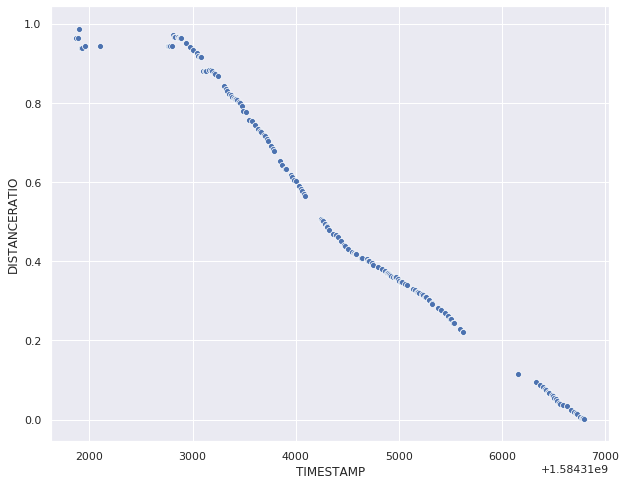

In [418]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=seg_dt[0], y="DISTANCERATIO", x="TIMESTAMP")
plt.show()

In [394]:
xx = (1 - seg_dt[1]["DISTANCERATIO"]).copy()

msk = remove_distance_not_increase_example(xx)
xx = xx[~msk].copy()

There is no decrease distance


There is no decrease distance


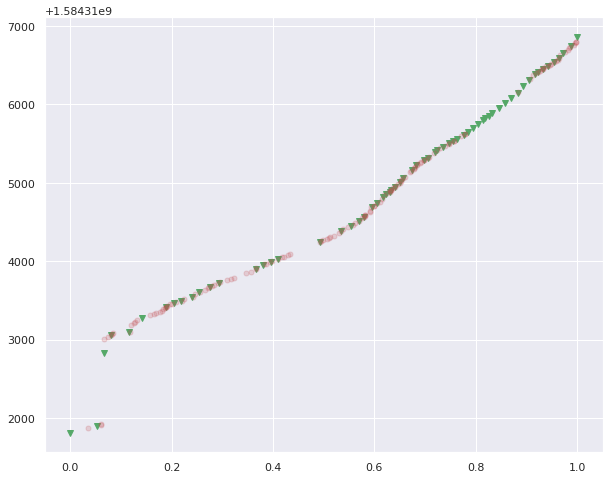

There is no decrease distance


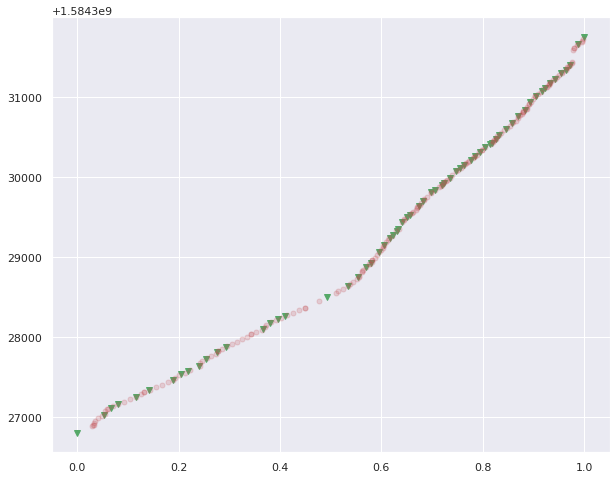

There is no decrease distance


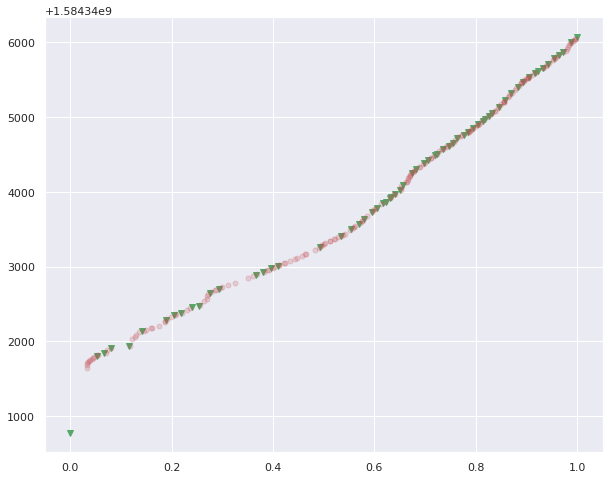

There is no decrease distance


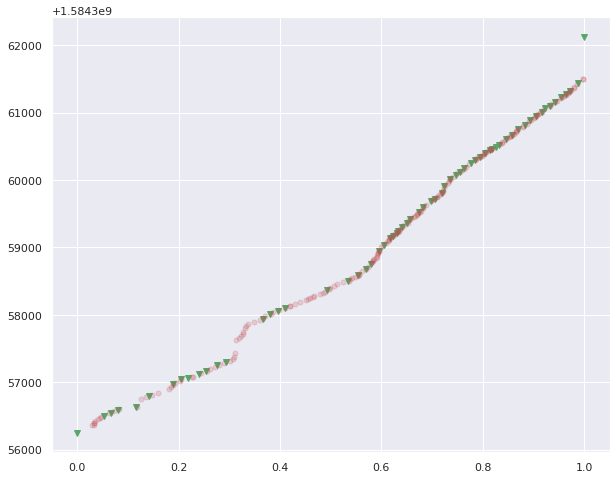

In [417]:
ipl = []
for s in seg_dt:
    ipl.append(interpolate_arrive_time(s, example_stops_distance, True))

In [401]:
# processing predicted column
pref_name = "ARRIVETIMETRIPS"
col_name = []
for i, v in enumerate(ipl):
    cn = pref_name + str(i)
    col_name.append(cn)
    example_stops_distance[cn] = v

In [402]:
for c in col_name:
    print(f"Convert column name {c}")
    example_stops_distance[c] = convert_timezone(example_stops_distance[c])

Convert column name ARRIVETIMETRIPS0
Convert column name ARRIVETIMETRIPS1
Convert column name ARRIVETIMETRIPS2
Convert column name ARRIVETIMETRIPS3


In [403]:
example_stops_distance.head()

STOPS  \
5017  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   
5018  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   
5019  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   
5020  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   
5021  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   

      ROUTEID  ROUTEVARID  STOPID           CODE  \
5017       51           2    4412  BX 1234546789   
5018       51           2     572        QTD 175   
5019       51           2     576        QTD 176   
5020       51           2     574        QTD 177   
5021       51           2     398        QTD 074   

                               NAME  STOPTYPE          ZONE  \
5017  Đường nội bộ Đại học Quốc gia     Ô sơn  Quận Thủ Đức   
5018       Đại học An Ninh Nhân Dân  Trụ dừng  Quận Thủ Đức   
5019     Trường giáo dục Quốc phòng  Trụ dừng  Quận Thủ Đức   
5020               Khu DL Suối Tiên   Nhà chờ  Quận Thủ Đức   
5021           Khu Công nghệ cao Q9  Trụ dừng  Quận Thủ Đức   

                   WARD                           ADDRESSNO  \
5017               None  Đại học Quốc Tế - Đại học Quốc gia   
5018               None                  Nhà máy Tiến Thành   
5019               None          Trường giáo dục Quốc phòng   
5020  Phường Linh Trung                                9/29   
5021  Phường Linh Trung          Đối diện Khu công nghệ cao   

                             STREET SUPPORTDISABILITY          STATUS  \
5017  Đường nội bộ Đại học Quốc gia                    Đang khai thác   
5018                      Quốc lộ 1                    Đang khai thác   
5019                      Quốc lộ 1                    Đang khai thác   
5020                      Quốc lộ 1                    Đang khai thác   
5021                   Xa Lộ Hà Nội                    Đang khai thác   

            LNG       LAT                     SEARCH  \
5017 106.801808 10.876771  DnbDhQg DhQT-DhQg DnbDhQg   
5018 106.806979 10.871128            DhANND NmTT Ql1   
5019 106.804367 10.868216            TgdQp TgdQp Ql1   
5020 106.801116 10.866050              KDST 9/29 Ql1   
5021 106.791723 10.860545          KCncQ DdKcnc XLHN   

                                                       ROUTES  \
5017                                                       30   
5018              150, 30, 33, 60-1, 60-2, 60-3, 60-4, 76, 99   
5019            150, 19, 30, 33, 53, 60-2, 60-3, 60-4, 76, 99   
5020  08, 10, 150, 19, 30, 33, 60-1, 60-2, 60-3, 60-4, 76, 99   
5021                      06, 08, 150, 30, 52, 60-3, 60-4, 76   

                                                                                               LINESTRING  \
5017  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   
5018  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   
5019  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   
5020  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   
5021  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   

                            SPOINT  DISTANCE     RANK   MAXRANK  \
5017  POINT (106.801808 10.876771)  0.000000 1.000000 64.000000   
5018  POINT (106.806979 10.871128)  0.016063 2.000000 64.000000   
5019  POINT (106.804367 10.868216)  0.020371 3.000000 64.000000   
5020   POINT (106.801116 10.86605)  0.024632 4.000000 64.000000   
5021  POINT (106.791723 10.860545)  0.035602 5.000000 64.000000   

                     SPOINTFSPOINT                 SPOINTLSPOINT  \
5017  POINT (106.801808 10.876771)  POINT (106.622057 10.787617)   
5018  POINT (

In [404]:
example_stops_distance.tail()

STOPS  \
5076  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   
5077  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   
5078  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   
5079  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   
5080  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   

      ROUTEID  ROUTEVARID  STOPID     CODE                NAME  STOPTYPE  \
5076       51           2    2722  QTP 112   Nhà Thờ Tân Hương  Trụ dừng   
5077       51           2    2584  QTP 113  Trạm Chợ Tân Hương  Trụ dừng   
5078       51           2    2720  QTP 114              Lê Sát  Trụ dừng   
5079       51           2    1614  QTP 116           Bình Long  Trụ dừng   
5080       51           2    1560     BX54     Cư xá Nhiêu Lộc    Bến xe   

              ZONE            WARD                    ADDRESSNO  \
5076  Quận Tân Phú  Phường Tân Qúy                          190   
5077  Quận Tân Phú  Phường Tân Qúy                          248   
5078  Quận Tân Phú  Phường Tân Qúy                          234   
5079  Quận Tân Phú            None                          214   
5080  Quận Tân Phú            None  Bến xe buýt Cư xá Nhiêu Lộc   

             STREET SUPPORTDISABILITY          STATUS        LNG       LAT  \
5076      Tân Hương                    Đang khai thác 106.623999 10.789867   
5077      Tân Hương                    Đang khai thác 106.621381 10.790178   
5078      Tân Hương                    Đang khai thác 106.618996 10.789883   
5079  Lê Thúc Hoạch                    Đang khai thác 106.618820 10.788112   
5080  Lê Thúc Hoạch                    Đang khai thác 106.622057 10.787617   

                SEARCH      ROUTES  \
5076       NTTH 190 TH      30, 41   
5077       TCTH 248 TH  30, 32, 69   
5078         LS 234 TH          30   
5079        BL 214 LTH     144, 30   
5080  CxNL BxbCxNL LTH     144, 30   

                                                                                               LINESTRING  \
5076  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   
5077  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   
5078  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   
5079  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   
5080  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   

                            SPOINT  DISTANCE      RANK   MAXRANK  \
5076  POINT (106.623999 10.789867)  0.292871 60.000000 64.000000   
5077  POINT (106.621381 10.790178)  0.295620 61.000000 64.000000   
5078  POINT (106.618996 10.789883)  0.298041 62.000000 64.000000   
5079   POINT (106.61882 10.788112)  0.303153 63.000000 64.000000   
5080  POINT (106.622057 10.787617)  0.306717 64.000000 64.000000   

                     SPOINTFSPOINT                 SPOINTLSPOINT  \
5076  POINT (106.801808 10.876771)  POINT (106.622057 10.787617)   
5077  POINT (106.801808 10.876771)  POINT (106.622057 10.787617)   
5078  POINT (106.801808 10.876771)  POINT (106.622057 10.787617)   
5079  POINT (106.801808 10.876771)  POINT (106.622057 10.787617)   
5080  POINT (106.801808 10.876771)  POINT (106.622057 10.787617)   

                                                                                         STOPS_LINESTRING  \
5076  LINESTRING (106.801808 10.876771, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.801971...   
5077  LINESTRING (106.801808 10.876771, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.801971...   
5078  LINESTRING (106.801808 10.876771, 106.80181122 10.87677097, 106.80181122 10.87677

In [405]:
col_n = ['ROUTEID', 'ROUTEVARID', 'STOPID', 'CODE', 'NAME', 'STOPTYPE',
         'ZONE', 'WARD', 'ADDRESSNO', 'STREET', 'SUPPORTDISABILITY', 'STATUS',
         'LNG', 'LAT', 'SEARCH', 'ROUTES', 'SPOINT', 'DISTANCE',
         'RANK', 'MAXRANK', 'SPOINTFSPOINT', 'SPOINTLSPOINT',
         'STOPSDISTANCE', 'ALLSTOPSDISTANCE', 'RATIOSTOPSDISTANCE',
         'ARRIVETIMETRIPS0', 'ARRIVETIMETRIPS1', 'ARRIVETIMETRIPS2',
         'ARRIVETIMETRIPS3']

In [ ]:
example_stops_distance[col_n].to_excel("../data/result/example_timetable.xlsx", index=False)

--------------

Notes for Interpolate (Giá trị distance X' và X luôn luôn tăng). 

Vấn đề của tập Data này:
- 1) Distance (from Prediction) ghi nhận bị noise, tăng giảm liên tục
- 2) Chưa biết được một ngày xe bus chạy bao nhiêu chuyến
- 3) Chưa biết được thời gian xuất phát (rời bến đầu tiên) của mỗi chuyến
- 4) Chưa biết được thời điểm xe bus đến trạm cuối (bến cuối cùng ở trên tuyến
- 5) Có những trường hợp xe bus đã tới trạm cuối nhưng dữ liệu vẫn ghi nhận (cùng một vị trí, dữ liệu ghi nhận liên tục) nên cần xác định thời điểm nào xe bus đến bến thực sự. 

Giải pháp:
* Nếu vận tốc của xe bus < 1m/s thì xem như xe bus đang đứng yên hoặc đã đến bến (giải quyết bài toán: Noise dữ liệu, X giảm, điểm dừng xe bus). Tuy nhiên nhược điểm của phương pháp này: ở những đoạn đường bị kẹt xe (traffic jam), dữ liệu khó chính xác, nếu xét vận tốc xe bus < 1m/s thì đã bỏ đi case này (chỉ lấy first value recorded). Tuy nhiên vấn đề này có thể trade-off được.
* Xác định bao nhiêu trip/route/day/bus: difference btw D và D-1 (D Shift). Sử dụng threshold là X*Distance_Dim với Threshold X = 0,8 hoặc 0,9 


### Split departure/return for each bus on each var.

In [94]:
predic_local = predic_df.copy()

predic_local = predic_local.sort_values(["ROUTEID", "ROUTEVARID", "BUSID", "LOCTIMESTAMP"])

predic_local = predic_local.drop_duplicates(["STOPID", "ROUTEID", "ROUTEVARID", "BUSID", "LOCTIMESTAMP", "DISTANCE"])

predic_local.head()

REQUESTTIME  STOPID  ROUTEID  ROUTEVARID     BUSID  \
754950  2020-03-16T06:36:23+07:00       8        1           1  51B02536   
758845  2020-03-16T06:36:53+07:00       8        1           1  51B02536   
762834  2020-03-16T06:37:23+07:00       8        1           1  51B02536   
765501  2020-03-16T06:37:43+07:00       8        1           1  51B02536   
768090  2020-03-16T06:38:03+07:00       8        1           1  51B02536   

                    LOCTIMESTAMP     DISTANCE     SPEED   TIMETOSTOP  CODE  \
754950 2020-03-16 06:35:31+07:00 8,069.130000 15.000000 2,100.000000  BX14   
758845 2020-03-16 06:36:11+07:00 7,898.560000 20.000000 2,080.000000  BX14   
762834 2020-03-16 06:36:44+07:00 7,725.150000 21.000000 2,006.000000  BX14   
765501 2020-03-16 06:36:51+07:00 7,675.190000 19.000000 1,989.000000  BX14   
768090 2020-03-16 06:37:11+07:00 7,572.400000 20.000000 1,961.000000  BX14   

                  NAME STOPTYPE    ZONE  WARD        ADDRESSNO         STREET  \
754950  Bến xe Chợ Lớn   Bến xe  Quận 5  None  GA HKXB CHO LON  Lê Quang Sung   
758845  Bến xe Chợ Lớn   Bến xe  Quận 5  None  GA HKXB CHO LON  Lê Quang Sung   
762834  Bến xe Chợ Lớn   Bến xe  Quận 5  None  GA HKXB CHO LON  Lê Quang Sung   
765501  Bến xe Chợ Lớn   Bến xe  Quận 5  None  GA HKXB CHO LON  Lê Quang Sung   
768090  Bến xe Chợ Lớn   Bến xe  Quận 5  None  GA HKXB CHO LON  Lê Quang Sung   

       SUPPORTDISABILITY          STATUS        LNG       LAT         SEARCH  \
754950                    Đang khai thác 106.652565 10.751253  BxCL GHCL LQS   
758845                    Đang khai thác 106.652565 10.751253  BxCL GHCL LQS   
762834                    Đang khai thác 106.652565 10.751253  BxCL GHCL LQS   
765501                    Đang khai thác 106.652565 10.751253  BxCL GHCL LQS   
768090                    Đang khai thác 106.652565 10.751253  BxCL GHCL LQS   

                                                                      ROUTES  \
754950  01, 05, 06, 07, 09, 150, 23, 47, 56, 62-1, 62-10, 62-7, 62-8, 81, 94   
758845  01, 05, 06, 07, 09, 150, 23, 47, 56, 62-1, 62-10, 62-7, 62-8, 81, 94   
762834  01, 05, 06, 07, 09, 150, 23, 47, 56, 62-1, 62-10, 62-7, 62-8, 81, 94   
765501  01, 05, 06, 07, 09, 150, 23, 47, 56, 62-1, 62-10, 62-7, 62-8, 81, 94   
768090  01, 05, 06, 07, 09, 150, 23, 47, 56, 62-1, 62-10, 62-7, 62-8, 81, 94   

                           ROUTEVARNAME    ROUTEVARSHORTNAME ROUTENO  \
754950  Lượt đi: Bến Thành - BX Chợ Lớn  Bến Xe Buýt Chợ Lớn      01   
758845  Lượt đi: Bến Thành - BX Chợ Lớn  Bến Xe Buýt Chợ Lớn      01   
762834  Lượt đi: Bến Thành - BX Chợ Lớn  Bến Xe Buýt Chợ Lớn      01   
765501  Lượt đi: Bến Thành - BX Chợ Lớn  Bến Xe Buýt Chợ Lớn      01   
768090  Lượt đi: Bến Thành - BX Chợ Lớn  Bến Xe Buýt Chợ Lớn      01   

                  STARTSTOP         ENDSTOP  DISTANCE_DIM OUTBOUND  \
754950  Công Trường Mê Linh  Bến xe Chợ Lớn  8,424.000000     True   
758845  Công Trường Mê Linh  Bến xe Chợ Lớn  8,424.000000     True   
762834  Công Trường Mê Linh  Bến xe Chợ Lớn  8,424.000000     True   
765501  Công Trường Mê Linh  Bến xe Chợ Lớn  8,424.000000     True   
768090  Công Trường Mê Linh  Bến xe Chợ Lớn  8,424.000000     True   

        RUNNINGTIME                                  ROUTENAME   TIMESTAMP  \
754950    40.000000  Bến Xe Buýt Sài Gòn - Bến Xe Buýt Chợ Lớn  1584315331   
758845    40.000000  Bến Xe Buýt Sài Gòn - Bến Xe Buýt Chợ Lớn  1584315371   
762834    40.000000  Bến Xe Buýt Sài Gòn - Bến Xe Buýt Chợ Lớn  1584315404   
765501    40.000000  Bến Xe Buýt Sài Gòn - Bến Xe Buýt Chợ Lớn  1584315411   
768090    40.000000  Bến Xe Buýt Sài Gòn - Bến Xe Buýt Chợ Lớn  1584315431   

        BUSIDSTR STOPIDSTR  DISTANCERATIO  
754950  51B02536         8       0.957874  
758845  51B02536         8       0.937626  
762834  51B02536         8       0.917041  
765501  51B02536         8       0.911110  
768090  51B02536         8       0.898908

--------------

Example for 1 route 1 BUS

In [419]:
# Get 1 example
example_53 = predic_df.query("ROUTEID == 51 & ROUTEVARID==2 & BUSID=='53N5053'").copy()
# example_53 = predic_df.query("ROUTEID == 51 & ROUTEVARID==2 & BUSID=='53N4967'").copy()

In [420]:
example_53 = example_53.drop_duplicates(["TIMESTAMP"], keep="first")
example_53 = example_53.sort_values(["TIMESTAMP"]).copy()

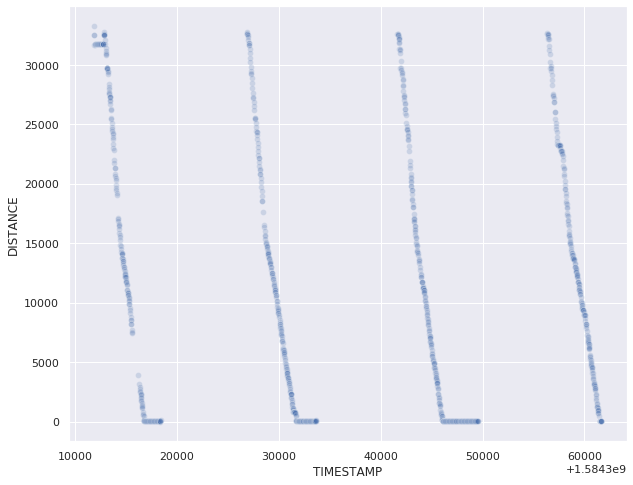

In [422]:
fig, ax = plt.subplots(figsize=(10, 8))
_draw_time_distance(example_53)
plt.show()

In [220]:
example_53.head()

REQUESTTIME  STOPID  ROUTEID  ROUTEVARID    BUSID  \
1725753  2020-03-16T08:32:19+07:00    1560       51           2  53N4967   
1727179  2020-03-16T08:32:29+07:00    1560       51           2  53N4967   
1729917  2020-03-16T08:32:49+07:00    1560       51           2  53N4967   
1742746  2020-03-16T08:34:19+07:00    1560       51           2  53N4967   
1744122  2020-03-16T08:34:29+07:00    1560       51           2  53N4967   

                     LOCTIMESTAMP      DISTANCE     SPEED   TIMETOSTOP  CODE  \
1725753 2020-03-16 08:32:00+07:00 32,642.480000 33.000000 5,700.000000  BX54   
1727179 2020-03-16 08:32:09+07:00 32,579.470000  7.000000 5,700.000000  BX54   
1729917 2020-03-16 08:32:16+07:00 32,577.090000  0.000000 5,700.000000  BX54   
1742746 2020-03-16 08:32:29+07:00 32,543.020000 21.000000 5,700.000000  BX54   
1744122 2020-03-16 08:32:35+07:00 32,512.240000 23.000000 5,700.000000  BX54   

                    NAME STOPTYPE          ZONE  WARD  \
1725753  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú  None   
1727179  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú  None   
1729917  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú  None   
1742746  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú  None   
1744122  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú  None   

                           ADDRESSNO         STREET SUPPORTDISABILITY  \
1725753  Bến xe buýt Cư xá Nhiêu Lộc  Lê Thúc Hoạch                     
1727179  Bến xe buýt Cư xá Nhiêu Lộc  Lê Thúc Hoạch                     
1729917  Bến xe buýt Cư xá Nhiêu Lộc  Lê Thúc Hoạch                     
1742746  Bến xe buýt Cư xá Nhiêu Lộc  Lê Thúc Hoạch                     
1744122  Bến xe buýt Cư xá Nhiêu Lộc  Lê Thúc Hoạch                     

                 STATUS        LNG       LAT            SEARCH   ROUTES  \
1725753  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH  144, 30   
1727179  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH  144, 30   
1729917  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH  144, 30   
1742746  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH  144, 30   
1744122  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH  144, 30   

                            ROUTEVARNAME ROUTEVARSHORTNAME ROUTENO  \
1725753  Lượt về: ĐH Quốc tế - Tân Hương     Chợ Tân Hương      30   
1727179  Lượt về: ĐH Quốc tế - Tân Hương     Chợ Tân Hương      30   
1729917  Lượt về: ĐH Quốc tế - Tân Hương     Chợ Tân Hương      30   
1742746  Lượt về: ĐH Quốc tế - Tân Hương     Chợ Tân Hương      30   
1744122  Lượt về: ĐH Quốc tế - Tân Hương     Chợ Tân Hương      30   

                             STARTSTOP          ENDSTOP  DISTANCE_DIM  \
1725753  Đường nội bộ Đại học Quốc gia  Cư xá Nhiêu Lộc 33,712.000000   
1727179  Đường nội bộ Đại học Quốc gia  Cư xá Nhiêu Lộc 33,712.000000   
1729917  Đường nội bộ Đại học Quốc gia  Cư xá Nhiêu Lộc 33,712.000000   
1742746  Đường nội bộ Đại học Quốc gia  Cư xá Nhiêu Lộc 33,712.000000   
1744122  Đường nội bộ Đại học Quốc gia  Cư xá Nhiêu Lộc 33,712.000000   

        OUTBOUND  RUNNINGTIME                        ROUTENAME   TIMESTAMP  \
1725753    False    95.000000  Chợ Tân Hương - Đại học Quốc tế  1584322320   
1727179    False    95.000000  Chợ Tân Hương - Đại học Quốc tế  1584322329   
1729917    False    95.000000  Chợ Tân Hương - Đại học Quốc tế  1584322336   
1742746    False    95.000000  Chợ Tân Hương - Đại học Quốc tế  1584322349   
1744122    False    95.000000  Chợ Tân Hương - Đại học Quốc tế  1584322355   

        BUSIDSTR STOPIDSTR  DISTANCERATIO  
1725753  53N4967      1560       0.968275  
1727179  53N4967      1560       0.966406  
1729917  53N4967      1560       0.966335  
1742746  53N4967      1560       0.965325  
1744122  53N4967      1560       0.964411

In [425]:
def mark_peak_point(df, distance, ratio=1):
    dis = df["DISTANCE"].copy()
    
    shifted_dis = dis - dis.shift()
    msk_peak = shifted_dis > (distance * ratio)
    
    return msk_peak

In [424]:
msk_peak = mark_peak_point(example_53, example_53.DISTANCE.max(), 0.8)
example_53["IS_PEAK"] = msk_peak

### Tách các trips

In [426]:
# Tách các trips
def split_trips(df, cols="IS_PEAK", xffix=("", "")):
    trips = df[cols].cumsum().copy().astype("int").to_frame("PEAK")
    
    mean_log = trips.groupby("PEAK").size().mean() * 0.5
    drop_peak = trips.groupby("PEAK").size()
    drop_peak = drop_peak[drop_peak < mean_log]
    trips = trips[~trips.PEAK.isin(drop_peak.index.tolist())].copy()
    trips.PEAK = (trips.PEAK.rank(method="dense") - 1).astype("int").astype("str")
    trips = trips.PEAK
    
    trips = xffix[0] + trips.str.zfill(2) + xffix[1]
    
    return trips

example_53["TRIPS"] = split_trips(example_53, xffix=("TRIPS", ""))

VD: 1 TRIP full record (3200 row), trip thu 11 chi ghi nhan (300 row) -> remove it with threshold 50% -> coi như trip không tồn tại, remove record 

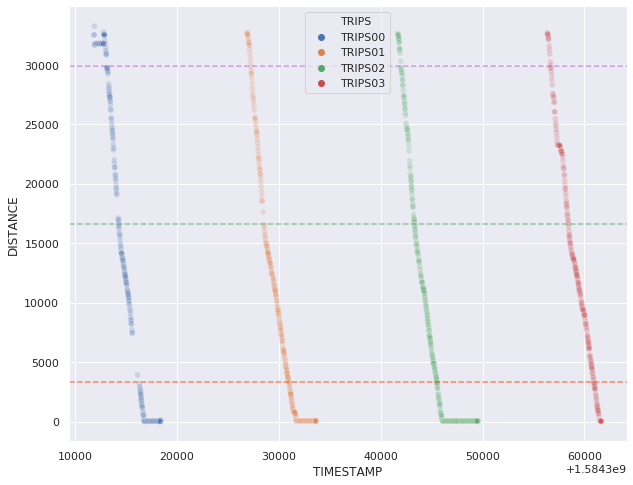

In [547]:
fig, ax = plt.subplots(figsize=(10, 8))
_draw_time_distance(example_53, hue=("TRIPS"))
plt.axhline(y=example_53.DISTANCE.max() // 2, color="g", alpha=0.6, ls="--")
plt.axhline(y=example_53.DISTANCE.max() * 0.1, color="#FF4500", alpha=0.6, ls="--")
plt.axhline(y=example_53.DISTANCE.max() * 0.9, color="#BA55D3", alpha=0.6, ls="--")
plt.show()

In [460]:
def mark_first_half(df, rate=(0.1, 0.9)):
    df["FIRSTHALF"] = np.nan
    df.loc[df.DISTANCE < (df.DISTANCE_DIM.max() * rate[0]), "FIRSTHALF"] = 2
    df.loc[df.DISTANCE > (df.DISTANCE_DIM.max() * rate[1]), "FIRSTHALF"] = 1
    df.loc[df.FIRSTHALF.isna(), "FIRSTHALF"] = 99

In [226]:
def preprocessing_route_bus(df, ratio_distance_peak=0.8):
    df = df.drop_duplicates(["TIMESTAMP"], keep="first").copy()
    df = df.sort_values(["TIMESTAMP"]).copy()
    df["IS_PEAK"] = mark_peak_point(df, df.DISTANCE.max(), ratio_distance_peak)
    df["TRIPS"] = split_trips(df, xffix=("TRIPS", ""))
    df = df.dropna(subset=["TRIPS"]).copy()
    mark_first_half(df)
    
    return df

In [430]:
example_53 = preprocessing_route_bus(example_53)

### Remove noise data

Vận tốc là m/s

In [228]:
def get_velocity(dfd, dft, is_reverse=False):
    if is_reverse:
        d = dfd[::-1].copy()
        t = dft[::-1].copy()
        dd = d - d.shift()
    else:
        d = dfd.copy()
        t = dft.copy()
        dd = d.shift() - d
    

    tt = (t - t.shift()).abs()
    
    return (dd / tt)[::-1] if is_reverse else (dd / tt)

def mark_velocity_outlier(v_col, threshold=1.5):
    msk_vel = v_col < threshold
    msk_rm = pd.Series(False, index=v_col.index)
    msk_rm[msk_vel] = True
    
    return msk_rm.copy()

def mark_all_velocity_outlier(dfd, dft, threshold=1, is_reverse=False, n_iters=5):
    index = dfd.index.copy()
    msk_vel = pd.Series(False, index=index)
    
    print(f"Starting to remove outlier with velocity threshold {threshold} "
          f"and max number of iterates is {n_iters} times")
    for i in range(n_iters):
        velocity = get_velocity(dfd[~msk_vel], dft[~msk_vel], is_reverse)
        start_msk_vel = mark_velocity_outlier(velocity, threshold)
        num_outlier = start_msk_vel.sum()
        print(f"Detected {num_outlier} outlier.")
        
        if num_outlier <= 0:  # exit loop if there is no outlier
            print("There is no outliers remain!")
            break
            
        dfd = dfd[~start_msk_vel].copy()
        dft = dft[~start_msk_vel].copy()
        
        msk_vel |= start_msk_vel

    return msk_vel


Second half

In [431]:
sec_half = example_53.query("TRIPS == 'TRIPS00' & FIRSTHALF==2").copy()

In [432]:
sec_half.head()

REQUESTTIME  STOPID  ROUTEID  ROUTEVARID    BUSID  \
890277  2020-03-16T06:53:14+07:00    1560       51           2  53N5053   
891612  2020-03-16T06:53:24+07:00    1560       51           2  53N5053   
892909  2020-03-16T06:53:34+07:00    1560       51           2  53N5053   
895711  2020-03-16T06:53:54+07:00    1560       51           2  53N5053   
897084  2020-03-16T06:54:04+07:00    1560       51           2  53N5053   

                    LOCTIMESTAMP     DISTANCE     SPEED  TIMETOSTOP  CODE  \
890277 2020-03-16 06:52:07+07:00 3,166.050000 15.000000  857.000000  BX54   
891612 2020-03-16 06:52:49+07:00 2,922.580000  7.000000  813.000000  BX54   
892909 2020-03-16 06:53:19+07:00 2,749.580000 25.000000  768.000000  BX54   
895711 2020-03-16 06:53:37+07:00 2,593.190000 30.000000  745.000000  BX54   
897084 2020-03-16 06:53:49+07:00 2,487.250000 28.000000  715.000000  BX54   

                   NAME STOPTYPE          ZONE  WARD  \
890277  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú  None   
891612  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú  None   
892909  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú  None   
895711  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú  None   
897084  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú  None   

                          ADDRESSNO         STREET SUPPORTDISABILITY  \
890277  Bến xe buýt Cư xá Nhiêu Lộc  Lê Thúc Hoạch                     
891612  Bến xe buýt Cư xá Nhiêu Lộc  Lê Thúc Hoạch                     
892909  Bến xe buýt Cư xá Nhiêu Lộc  Lê Thúc Hoạch                     
895711  Bến xe buýt Cư xá Nhiêu Lộc  Lê Thúc Hoạch                     
897084  Bến xe buýt Cư xá Nhiêu Lộc  Lê Thúc Hoạch                     

                STATUS        LNG       LAT            SEARCH   ROUTES  \
890277  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH  144, 30   
891612  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH  144, 30   
892909  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH  144, 30   
895711  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH  144, 30   
897084  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH  144, 30   

                           ROUTEVARNAME ROUTEVARSHORTNAME ROUTENO  \
890277  Lượt về: ĐH Quốc tế - Tân Hương     Chợ Tân Hương      30   
891612  Lượt về: ĐH Quốc tế - Tân Hương     Chợ Tân Hương      30   
892909  Lượt về: ĐH Quốc tế - Tân Hương     Chợ Tân Hương      30   
895711  Lượt về: ĐH Quốc tế - Tân Hương     Chợ Tân Hương      30   
897084  Lượt về: ĐH Quốc tế - Tân Hương     Chợ Tân Hương      30   

                            STARTSTOP          ENDSTOP  DISTANCE_DIM OUTBOUND  \
890277  Đường nội bộ Đại học Quốc gia  Cư xá Nhiêu Lộc 33,712.000000    False   
891612  Đường nội bộ Đại học Quốc gia  Cư xá Nhiêu Lộc 33,712.000000    False   
892909  Đường nội bộ Đại học Quốc gia  Cư xá Nhiêu Lộc 33,712.000000    False   
895711  Đường nội bộ Đại học Quốc gia  Cư xá Nhiêu Lộc 33,712.000000    False   
897084  Đường nội bộ Đại học Quốc gia  Cư xá Nhiêu Lộc 33,712.000000    False   

        RUNNINGTIME                        ROUTENAME   TIMESTAMP BUSIDSTR  \
890277    95.000000  Chợ Tân Hương - Đại học Quốc tế  1584316327  53N5053   
891612    95.000000  Chợ Tân Hương - Đại học Quốc tế  1584316369  53N5053   
892909    95.000000  Chợ Tân Hương - Đại học Quốc tế  1584316399  53N5053   
895711    95.000000  Chợ Tân Hương - Đại học Quốc tế  1584316417  53N5053   
897084    95.000000  Chợ Tân Hương - Đại học Quốc tế  1584316429  53N5053   

       STOPIDSTR  DISTANCERATIO  IS_PEAK    TRIPS  FIRSTHALF  
890277      1560       0.093915    False  TRIPS00   2.000000  
891612      1560       0.086693    False  TRIPS00   2.000000  
892909      1560       0.081561    False  TRIPS00   2.000000  
895711      1560       0.076922    False  TRIPS00   2.000000  
897084      1560       0.073779    False  TRIPS00   2.000000

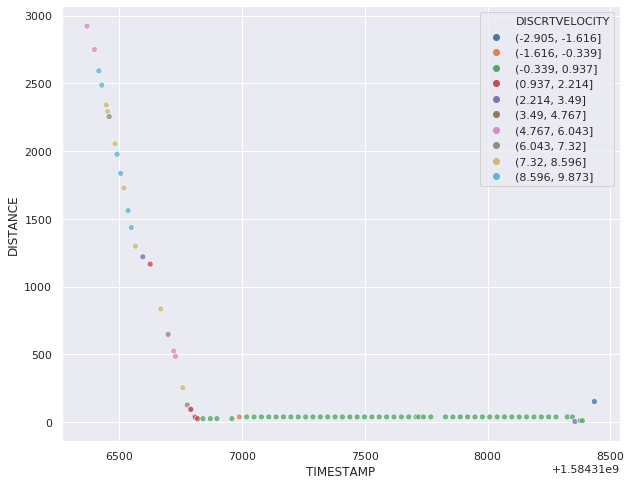

In [433]:
sec_half["VELOCITY"] = get_velocity(sec_half.DISTANCE, sec_half.TIMESTAMP)
sec_half["DISCRTVELOCITY"] = pd.cut(sec_half.VELOCITY, bins=10)

fig, ax = plt.subplots(figsize=(10, 8))
_draw_time_distance(sec_half, hue="DISCRTVELOCITY", alpha=0.8)
plt.show()

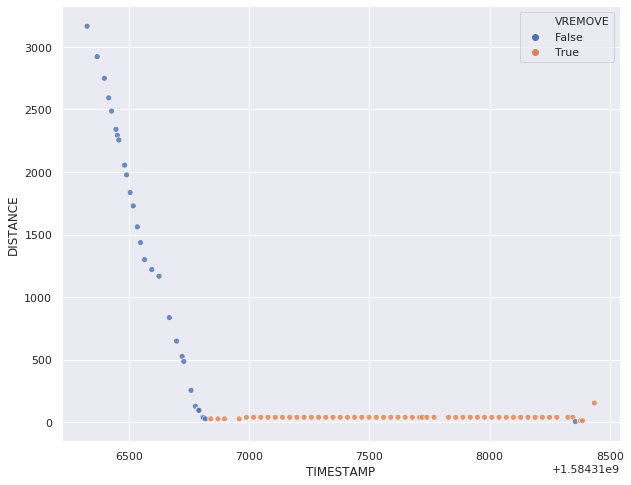

In [469]:
sec_half["VREMOVE"] = mark_velocity_outlier(sec_half.VELOCITY, 1)

fig, ax = plt.subplots(figsize=(10, 8))
_draw_time_distance(sec_half, hue="VREMOVE", alpha=0.8)
plt.show()

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 53 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


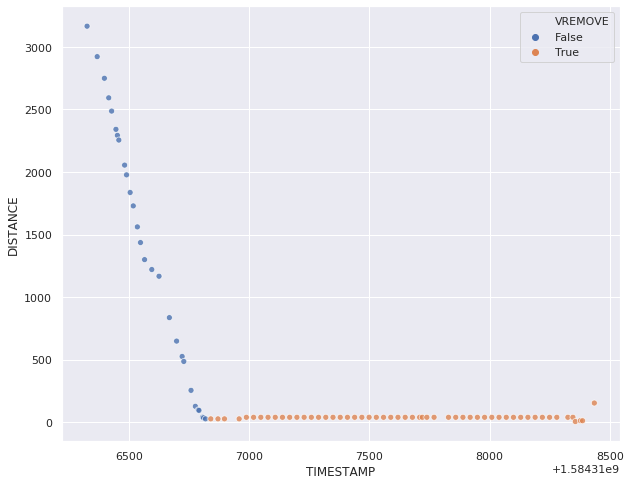

In [470]:
outlier = mark_all_velocity_outlier(sec_half["DISTANCE"], sec_half["TIMESTAMP"], threshold=1)

# Show detected outliers
sec_half["VREMOVE"] = outlier

fig, ax = plt.subplots(figsize=(10, 8))
_draw_time_distance(sec_half, hue="VREMOVE", alpha=0.8)
plt.show()

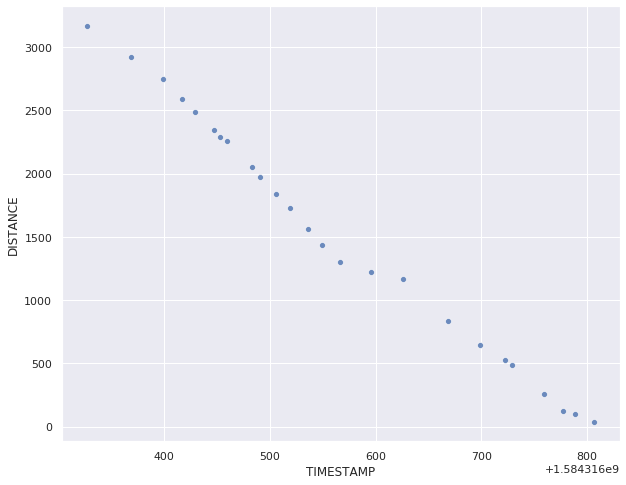

In [440]:
# data after remove outliers
fig, ax = plt.subplots(figsize=(10, 8))
_draw_time_distance(sec_half[sec_half.VREMOVE==0], alpha=0.8)
plt.show()

For the first half

In [441]:
first_half = example_53.query("TRIPS == 'TRIPS00' & FIRSTHALF==1").copy()

In [442]:
first_half.head()

REQUESTTIME  STOPID  ROUTEID  ROUTEVARID    BUSID  \
373200  2020-03-16T05:38:09+07:00    1560       51           2  53N5053   
374111  2020-03-16T05:38:19+07:00    1560       51           2  53N5053   
374958  2020-03-16T05:38:29+07:00    1560       51           2  53N5053   
376519  2020-03-16T05:38:49+07:00    1560       51           2  53N5053   
377380  2020-03-16T05:38:59+07:00    1560       51           2  53N5053   

                    LOCTIMESTAMP      DISTANCE     SPEED   TIMETOSTOP  CODE  \
373200 2020-03-16 05:37:54+07:00 32,516.190000 25.000000 4,927.000000  BX54   
374111 2020-03-16 05:38:06+07:00 32,518.780000 29.000000 4,927.000000  BX54   
374958 2020-03-16 05:38:18+07:00 33,243.120000 29.000000 5,057.000000  BX54   
376519 2020-03-16 05:38:36+07:00 31,668.720000 30.000000 4,778.000000  BX54   
377380 2020-03-16 05:38:48+07:00 31,668.610000 16.000000 4,779.000000  BX54   

                   NAME STOPTYPE          ZONE  WARD  \
373200  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú  None   
374111  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú  None   
374958  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú  None   
376519  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú  None   
377380  Cư xá Nhiêu Lộc   Bến xe  Quận Tân Phú  None   

                          ADDRESSNO         STREET SUPPORTDISABILITY  \
373200  Bến xe buýt Cư xá Nhiêu Lộc  Lê Thúc Hoạch                     
374111  Bến xe buýt Cư xá Nhiêu Lộc  Lê Thúc Hoạch                     
374958  Bến xe buýt Cư xá Nhiêu Lộc  Lê Thúc Hoạch                     
376519  Bến xe buýt Cư xá Nhiêu Lộc  Lê Thúc Hoạch                     
377380  Bến xe buýt Cư xá Nhiêu Lộc  Lê Thúc Hoạch                     

                STATUS        LNG       LAT            SEARCH   ROUTES  \
373200  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH  144, 30   
374111  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH  144, 30   
374958  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH  144, 30   
376519  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH  144, 30   
377380  Đang khai thác 106.622057 10.787617  CxNL BxbCxNL LTH  144, 30   

                           ROUTEVARNAME ROUTEVARSHORTNAME ROUTENO  \
373200  Lượt về: ĐH Quốc tế - Tân Hương     Chợ Tân Hương      30   
374111  Lượt về: ĐH Quốc tế - Tân Hương     Chợ Tân Hương      30   
374958  Lượt về: ĐH Quốc tế - Tân Hương     Chợ Tân Hương      30   
376519  Lượt về: ĐH Quốc tế - Tân Hương     Chợ Tân Hương      30   
377380  Lượt về: ĐH Quốc tế - Tân Hương     Chợ Tân Hương      30   

                            STARTSTOP          ENDSTOP  DISTANCE_DIM OUTBOUND  \
373200  Đường nội bộ Đại học Quốc gia  Cư xá Nhiêu Lộc 33,712.000000    False   
374111  Đường nội bộ Đại học Quốc gia  Cư xá Nhiêu Lộc 33,712.000000    False   
374958  Đường nội bộ Đại học Quốc gia  Cư xá Nhiêu Lộc 33,712.000000    False   
376519  Đường nội bộ Đại học Quốc gia  Cư xá Nhiêu Lộc 33,712.000000    False   
377380  Đường nội bộ Đại học Quốc gia  Cư xá Nhiêu Lộc 33,712.000000    False   

        RUNNINGTIME                        ROUTENAME   TIMESTAMP BUSIDSTR  \
373200    95.000000  Chợ Tân Hương - Đại học Quốc tế  1584311874  53N5053   
374111    95.000000  Chợ Tân Hương - Đại học Quốc tế  1584311886  53N5053   
374958    95.000000  Chợ Tân Hương - Đại học Quốc tế  1584311898  53N5053   
376519    95.000000  Chợ Tân Hương - Đại học Quốc tế  1584311916  53N5053   
377380    95.000000  Chợ Tân Hương - Đại học Quốc tế  1584311928  53N5053   

       STOPIDSTR  DISTANCERATIO  IS_PEAK    TRIPS  FIRSTHALF  
373200      1560       0.964529    False  TRIPS00   1.000000  
374111      1560       0.964605    False  TRIPS00   1.000000  
374958      1560       0.986092    False  TRIPS00   1.000000  
376519      1560       0.939390    False  TRIPS00   1.000000  
377380      1560       0.939387    False  TRIPS00   1.000000

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 32 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


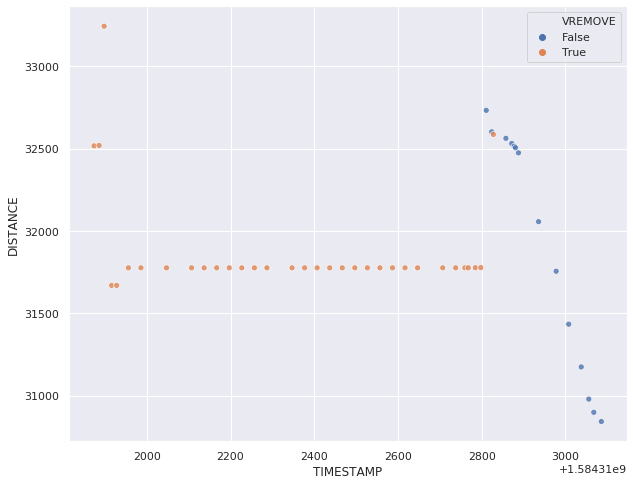

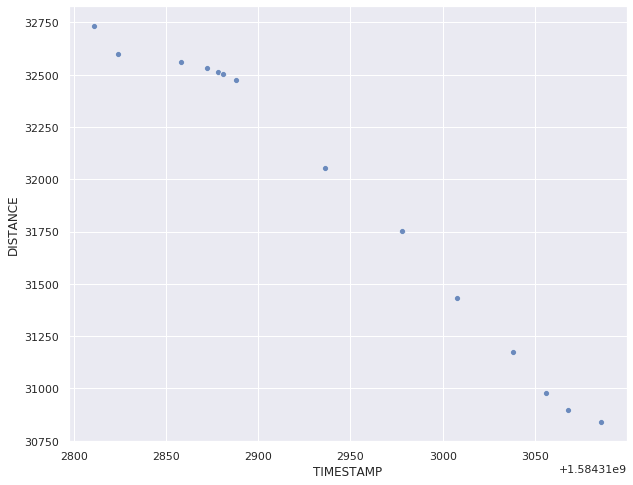

In [443]:
outlier = mark_all_velocity_outlier(first_half["DISTANCE"], first_half["TIMESTAMP"], is_reverse=True, threshold=1)

# Show detected outliers
first_half["VREMOVE"] = outlier

fig, ax = plt.subplots(figsize=(10, 8))
_draw_time_distance(first_half, hue="VREMOVE", alpha=0.8)
plt.show()

# data after remove outliers
fig, ax = plt.subplots(figsize=(10, 8))
_draw_time_distance(first_half[first_half.VREMOVE==0], alpha=0.8)
plt.show()

In [444]:
full_trips = pd.concat([first_half, example_53.query("TRIPS == 'TRIPS00' & FIRSTHALF==99"), sec_half], sort=False)
full_trips.loc[full_trips.VREMOVE.isna(), "VREMOVE"] = 0

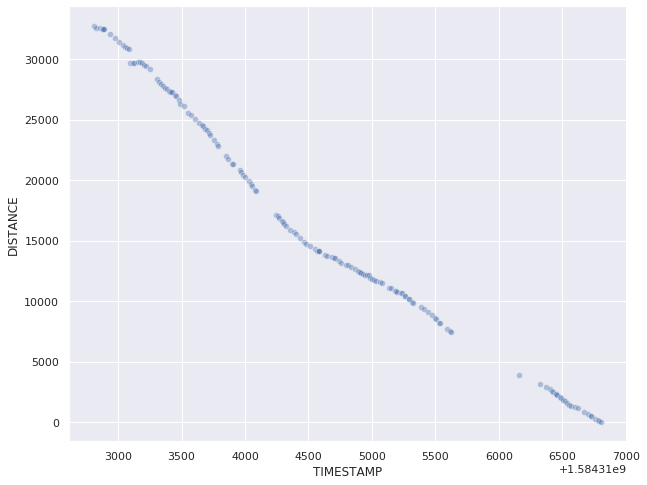

In [445]:
fig, ax = plt.subplots(figsize=(10, 8))
_draw_time_distance(full_trips[full_trips.VREMOVE==0], alpha=0.4)
plt.show()

In [446]:
def remove_outlier_whole_trips(df, plot=False):
    center_data = df[df.FIRSTHALF==99].copy()
    
    data_half = {
        "first": df[df.FIRSTHALF==1].copy(),
        "center": center_data,
        "second": df[df.FIRSTHALF==2].copy(),
    }
    
    def _mark_outlier(data, is_reverse):
        outlier = mark_all_velocity_outlier(data["DISTANCE"], data["TIMESTAMP"], is_reverse=is_reverse, threshold=1)

        # Show detected outliers
        data["VREMOVE"] = outlier

        if plot:
            fig, ax = plt.subplots(figsize=(10, 8))
            _draw_time_distance(data, hue="VREMOVE", alpha=0.8)
            plt.show()

            # data after remove outliers
            fig, ax = plt.subplots(figsize=(10, 8))
            _draw_time_distance(data[data.VREMOVE==0], alpha=0.8)
            plt.show()
    
        return data[data.VREMOVE==0].copy()
    
    dt = []
    for i, v in data_half.items():
        if i == "center":
            dt.append(v)
        else:
            is_rv = True if i == "first" else False
            dt.append(_mark_outlier(v, is_rv))
            
    df = pd.concat(dt, axis=0, sort=False)
        
    return df

In [447]:
def remove_outliers_whole_route(df, plot=False):
    trips = df.TRIPS.unique()
    print("There are {} trips: {}".format(trips.shape[0], ", ".join(trips)))
    
    rs = []
    for t in trips:
        print(f"Remove outliers for trips: {t}")
        dt = df[df.TRIPS==t].copy()
        rs.append(remove_outlier_whole_trips(dt, plot))
        
    return pd.concat(rs, sort=False)

In [252]:
def remove_distance_not_increase(ds, n_iters=500):
    ds = ds.copy()
    msk = pd.Series(False, index=ds.index)
    
    for i in range(n_iters):
        delta_d = ds.shift() - ds
        invalid = delta_d <= 0
        if invalid.sum() <= 0:
            print("There is no decrease distance")
            break
        msk |= invalid
        ds = ds[~msk].copy()
    
    return msk.copy()

In [548]:
def interpolate_time(predic_df, stops_df, plot=False):
    msk = remove_distance_not_increase(predic_df.DISTANCE.copy())
    
    predic_df = predic_df[~msk].copy()
    x = 1 - predic_df["DISTANCERATIO"]
    y = predic_df["TIMESTAMP"].astype("int")
    y = y[y.index.isin(x.index)].copy()
    spl = InterpolatedUnivariateSpline(x, y, k=1)
    xs = stops_df["RATIOSTOPSDISTANCE"]
    if plot:
        fig, ax = plt.subplots(figsize=(10, 8))
        plt.plot(spl(xs), xs, 'gv')
        plt.plot(y, x, 'ro', ms=5, alpha=0.2, linewidth=6)
        plt.show()
    
    return spl(xs)

In [298]:
def predic_whole_route(route_data, stops, plot, cols=None, pref="ARRIVETIMETRIPS"):
    trips = route_data.TRIPS.unique()
    stops = stops.copy()
    
    ipl = []
    for t in trips:
        print(f"Predict for trips {t}")
        dta = route_data[route_data.TRIPS==t].copy()
        ipl.append(interpolate_time(dta, stops, plot))
        col_names = []
        
    for i, v in enumerate(ipl):
        cn = pref + "{:02d}".format(int(i))
        col_names.append(cn)
        stops[cn] = v
    
    col_pre = stops.columns[stops.columns.str.contains(pref)].tolist()
    for c in col_pre:
        print(f"Convert column name {c}")
        stops[c] = convert_timezone(stops[c])
            
    if cols:
        dt_rt = stops[cols + col_pre].copy()
    else:
        dt_rt = stops.copy()
    
    return dt_rt

In [411]:
def predict_whole_route_all_bus(predic, 
                                stops, 
                                route_id, 
                                routevar_id, 
                                cols,
                                plot=(False, False),
                                ratio_distance=0.8):
    
    stops_df = stops[(stops.ROUTEID==route_id) & (stops.ROUTEVARID==routevar_id)].copy()
    predic_df = predic[(predic.ROUTEID==route_id) & (predic.ROUTEVARID==routevar_id)].copy()
    
    bus = predic_df.BUSID.unique()
    
    time_tables = []
    for b in bus:
        print(f"Predic for bus {b}")
        bus_data = predic_df[predic_df.BUSID==b].copy()
        dt_removed = preprocessing_route_bus(bus_data, ratio_distance)
        dt_removed = remove_outliers_whole_route(dt_removed, plot[0])

        predicted = predic_whole_route(dt_removed, stops_df, plot[1], cols=cols)
        predicted["BUSPREDIC"] = b
        
        time_tables.append(predicted.copy())
        
    return pd.concat(time_tables, axis=0, sort=True, ignore_index=True)

In [448]:
removed_data = remove_outliers_whole_route(example_53, False)

There are 4 trips: TRIPS00, TRIPS01, TRIPS02, TRIPS03
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 32 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 53 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!
Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 76 outlier.
Detected 2 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!
Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 2 outlier.
Detecte

* Vận tốc: 1m/s ngưỡng di chuyện để đánh dấu xe bus có đang chạy hay không, giải quyết bài toán về outlier.
* Khoảng cách tối đa của 2 điểm ghi nhận liền kề là (dmax * n) với:
    * dmax: là độ dài lớn nhất (hay là tổng độ dài của Route).
    * n: 0.8 (threshold)
    * Giải quyết bài toán về tách trips, tìm điểm dừng của xe bus.

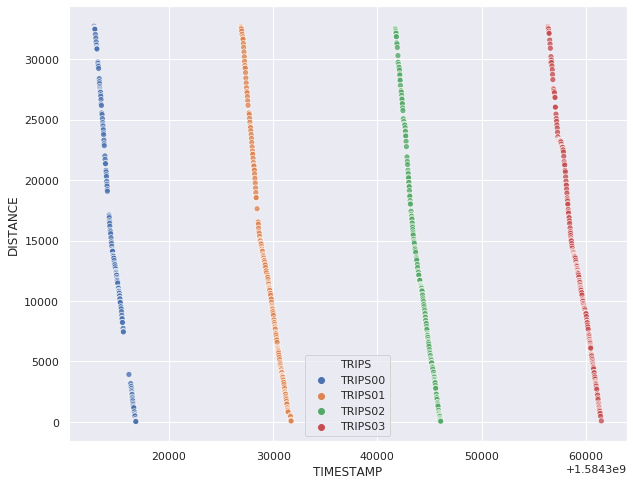

In [449]:
fig, ax = plt.subplots(figsize=(10, 8))
_draw_time_distance(removed_data, hue="TRIPS", alpha=0.8)
plt.show()

In [451]:
stops_distance.columns

Index(['STOPS', 'ROUTEID', 'ROUTEVARID', 'STOPID', 'CODE', 'NAME', 'STOPTYPE',
       'ZONE', 'WARD', 'ADDRESSNO', 'STREET', 'SUPPORTDISABILITY', 'STATUS',
       'LNG', 'LAT', 'SEARCH', 'ROUTES', 'LINESTRING', 'SPOINT', 'DISTANCE',
       'RANK', 'MAXRANK', 'SPOINTFSPOINT', 'SPOINTLSPOINT', 'STOPS_LINESTRING',
       'STOPSDISTANCE', 'ALLSTOPSDISTANCE', 'RATIOSTOPSDISTANCE'],
      dtype='object')

In [452]:
st = stops_distance.query("ROUTEID==51 & ROUTEVARID==2").copy()

# Interpolate

* Truc x: Timestamp (integer)
* Truc Y: Distance by ratio
* Red dot: dau vao input, du lieu thuc te from prodiction file.
* Green dot: interpolated time-to-stop 

Predict for trips TRIPS00
There is no decrease distance


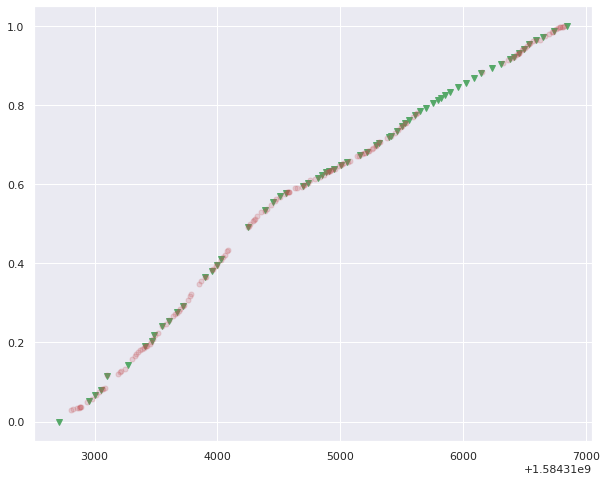

Predict for trips TRIPS01
There is no decrease distance


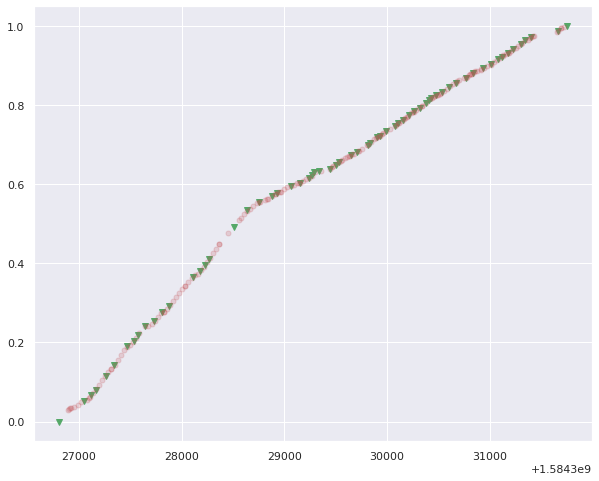

Predict for trips TRIPS02
There is no decrease distance


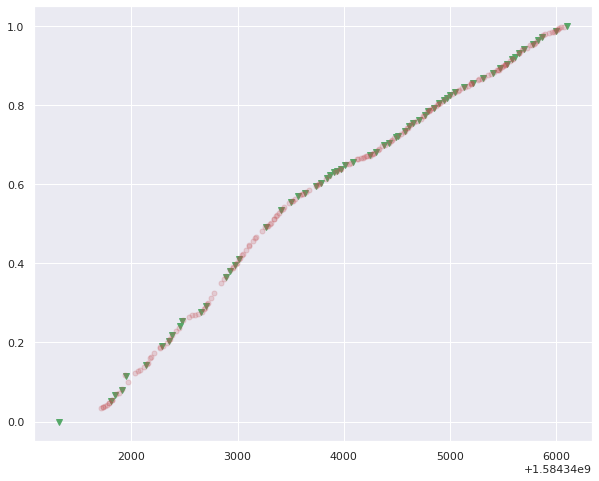

Predict for trips TRIPS03
There is no decrease distance


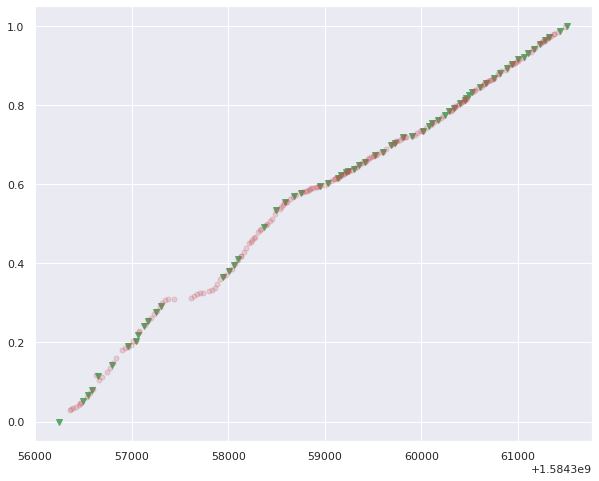

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Convert column name ARRIVETIMETRIPS03


In [549]:
t_tb = predic_whole_route(removed_data.copy(), st, True)

In [265]:
t_tb.columns

Index(['STOPS', 'ROUTEID', 'ROUTEVARID', 'STOPID', 'CODE', 'NAME', 'STOPTYPE',
       'ZONE', 'WARD', 'ADDRESSNO', 'STREET', 'SUPPORTDISABILITY', 'STATUS',
       'LNG', 'LAT', 'SEARCH', 'ROUTES', 'LINESTRING', 'SPOINT', 'DISTANCE',
       'RANK', 'MAXRANK', 'SPOINTFSPOINT', 'SPOINTLSPOINT', 'STOPS_LINESTRING',
       'STOPSDISTANCE', 'ALLSTOPSDISTANCE', 'RATIOSTOPSDISTANCE',
       'ARRIVETIMETRIPS00', 'ARRIVETIMETRIPS01', 'ARRIVETIMETRIPS02'],
      dtype='object')

In [454]:
t_tb.tail()

STOPS  \
5076  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   
5077  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   
5078  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   
5079  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   
5080  [{'StopId': 4412, 'Code': 'BX 1234546789', 'Name': 'Đường nội bộ Đại học Quốc gia', 'StopType': ...   

      ROUTEID  ROUTEVARID  STOPID     CODE                NAME  STOPTYPE  \
5076       51           2    2722  QTP 112   Nhà Thờ Tân Hương  Trụ dừng   
5077       51           2    2584  QTP 113  Trạm Chợ Tân Hương  Trụ dừng   
5078       51           2    2720  QTP 114              Lê Sát  Trụ dừng   
5079       51           2    1614  QTP 116           Bình Long  Trụ dừng   
5080       51           2    1560     BX54     Cư xá Nhiêu Lộc    Bến xe   

              ZONE            WARD                    ADDRESSNO  \
5076  Quận Tân Phú  Phường Tân Qúy                          190   
5077  Quận Tân Phú  Phường Tân Qúy                          248   
5078  Quận Tân Phú  Phường Tân Qúy                          234   
5079  Quận Tân Phú            None                          214   
5080  Quận Tân Phú            None  Bến xe buýt Cư xá Nhiêu Lộc   

             STREET SUPPORTDISABILITY          STATUS        LNG       LAT  \
5076      Tân Hương                    Đang khai thác 106.623999 10.789867   
5077      Tân Hương                    Đang khai thác 106.621381 10.790178   
5078      Tân Hương                    Đang khai thác 106.618996 10.789883   
5079  Lê Thúc Hoạch                    Đang khai thác 106.618820 10.788112   
5080  Lê Thúc Hoạch                    Đang khai thác 106.622057 10.787617   

                SEARCH      ROUTES  \
5076       NTTH 190 TH      30, 41   
5077       TCTH 248 TH  30, 32, 69   
5078         LS 234 TH          30   
5079        BL 214 LTH     144, 30   
5080  CxNL BxbCxNL LTH     144, 30   

                                                                                               LINESTRING  \
5076  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   
5077  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   
5078  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   
5079  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   
5080  LINESTRING (106.80181122 10.87677097, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.80...   

                            SPOINT  DISTANCE      RANK   MAXRANK  \
5076  POINT (106.623999 10.789867)  0.292871 60.000000 64.000000   
5077  POINT (106.621381 10.790178)  0.295620 61.000000 64.000000   
5078  POINT (106.618996 10.789883)  0.298041 62.000000 64.000000   
5079   POINT (106.61882 10.788112)  0.303153 63.000000 64.000000   
5080  POINT (106.622057 10.787617)  0.306717 64.000000 64.000000   

                     SPOINTFSPOINT                 SPOINTLSPOINT  \
5076  POINT (106.801808 10.876771)  POINT (106.622057 10.787617)   
5077  POINT (106.801808 10.876771)  POINT (106.622057 10.787617)   
5078  POINT (106.801808 10.876771)  POINT (106.622057 10.787617)   
5079  POINT (106.801808 10.876771)  POINT (106.622057 10.787617)   
5080  POINT (106.801808 10.876771)  POINT (106.622057 10.787617)   

                                                                                         STOPS_LINESTRING  \
5076  LINESTRING (106.801808 10.876771, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.801971...   
5077  LINESTRING (106.801808 10.876771, 106.80181122 10.87677097, 106.80181122 10.87677097, 106.801971...   
5078  LINESTRING (106.801808 10.876771, 106.80181122 10.87677097, 106.80181122 10.87677

------------

### Run for all **BUS** in **1** route

In [294]:
cols_to_get = ["ROUTEID", "ROUTEVARID", 
               "STOPID", "CODE", "NAME", "STOPTYPE", 
               "ZONE", "WARD", "ADDRESSNO", "STREET", "SUPPORTDISABILITY", 
               "STATUS", "LNG", "LAT", 
               "SEARCH", "ROUTES", "RANK"]

Predic for bus 53N4414
There are 3 trips: TRIPS00, TRIPS01, TRIPS02
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


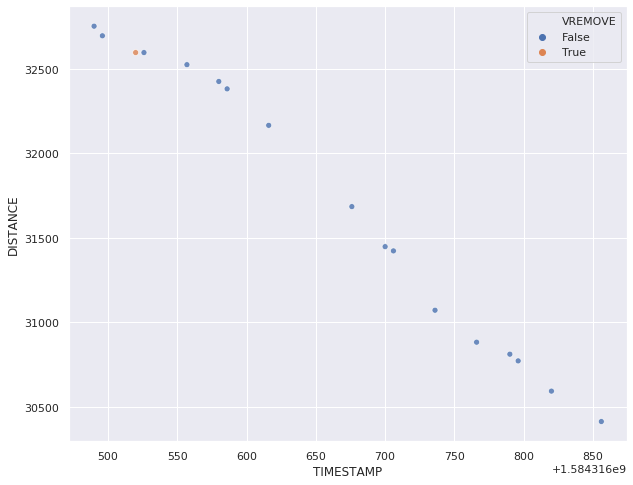

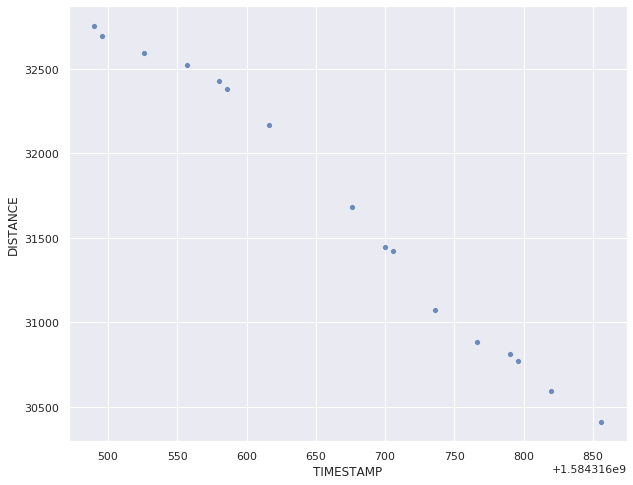

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 40 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


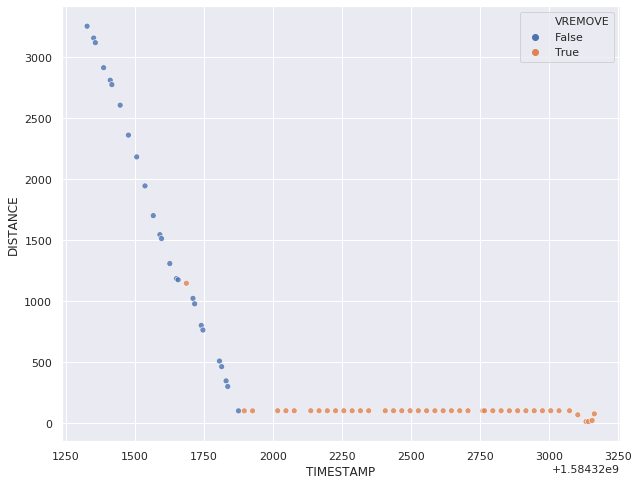

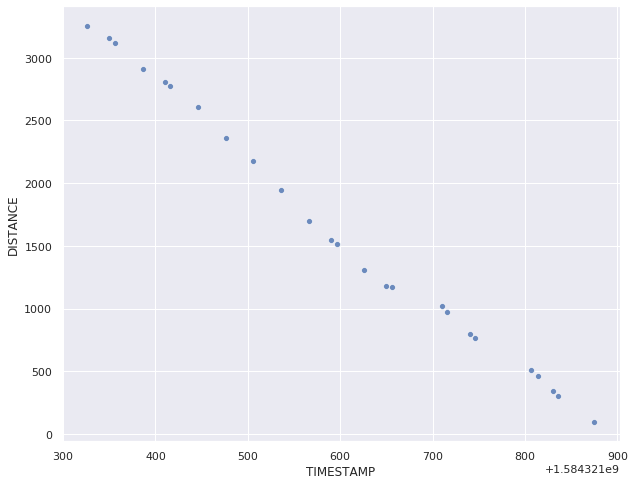

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


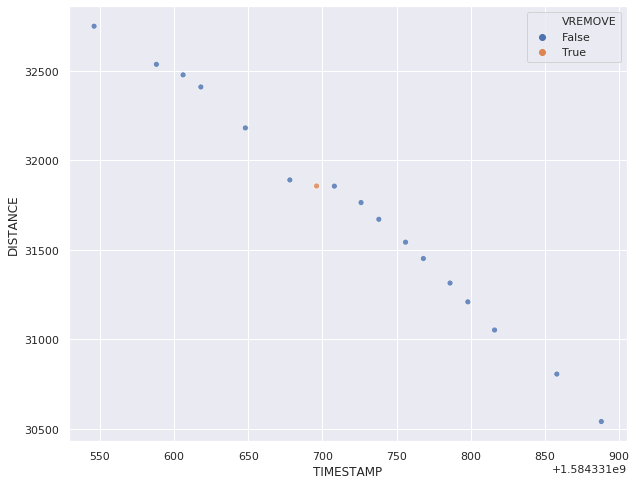

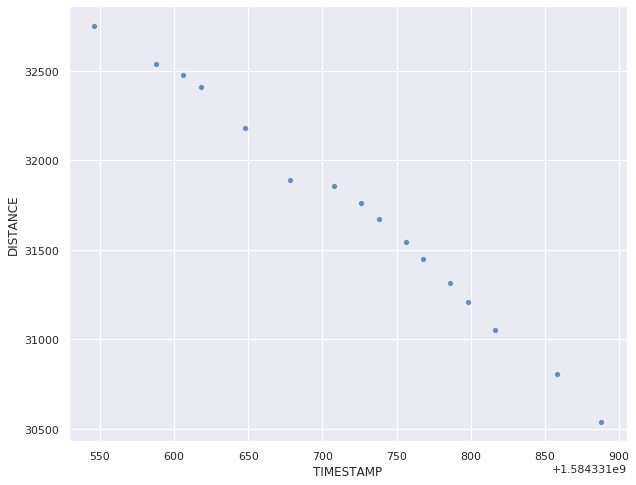

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 86 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


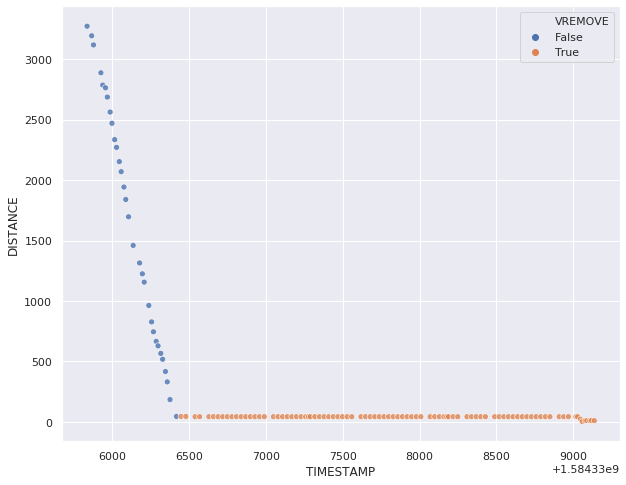

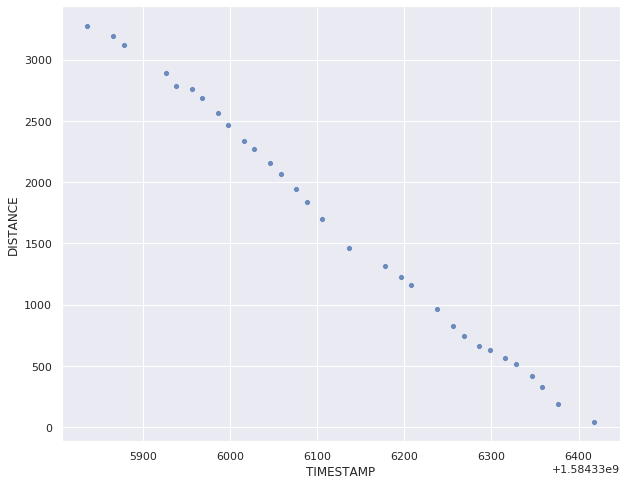

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


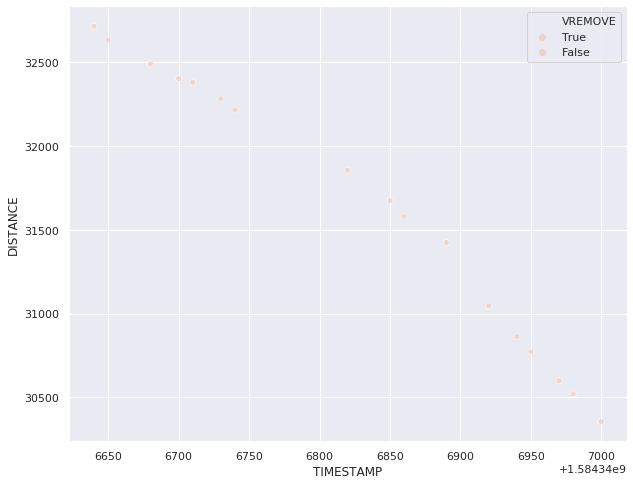

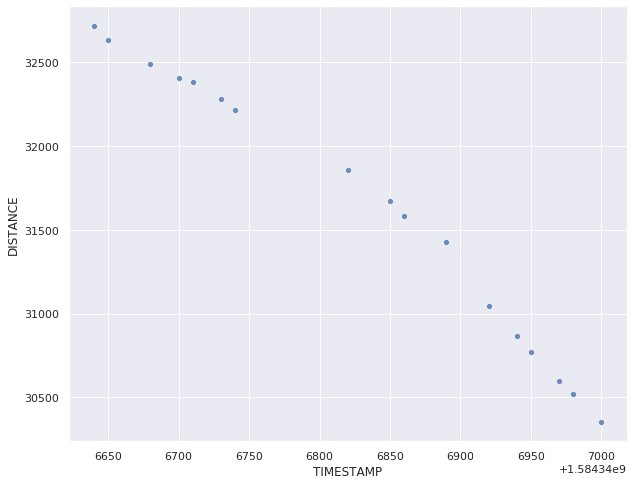

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 74 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


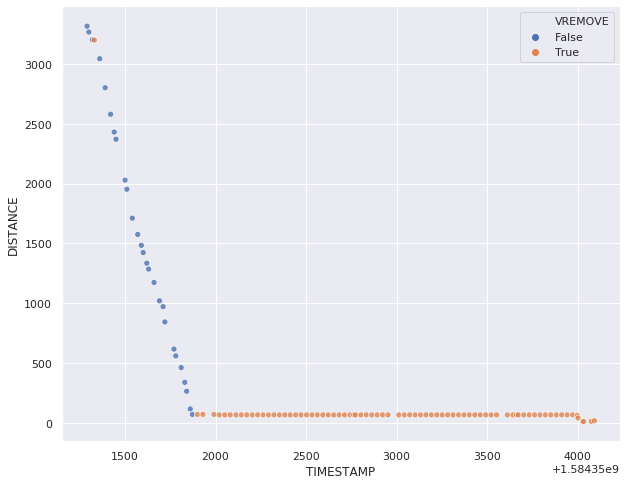

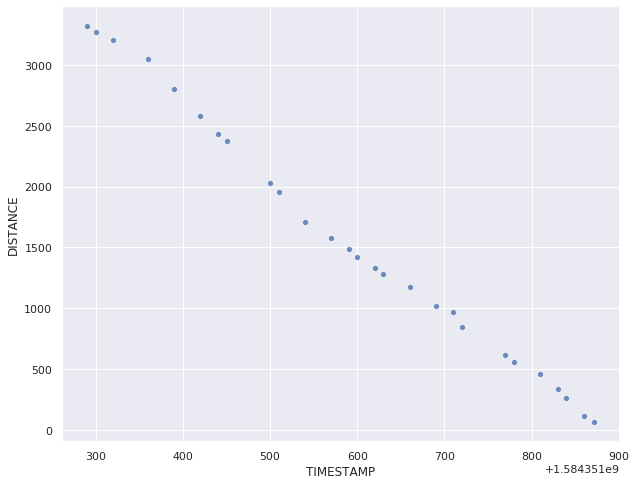

Predict for trips TRIPS00
There is no decrease distance


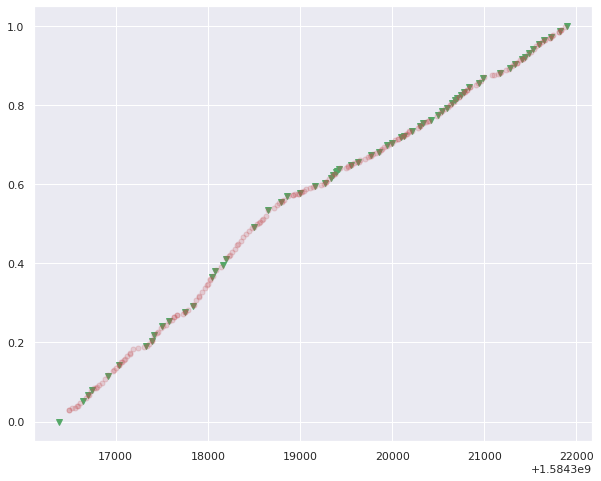

Predict for trips TRIPS01
There is no decrease distance


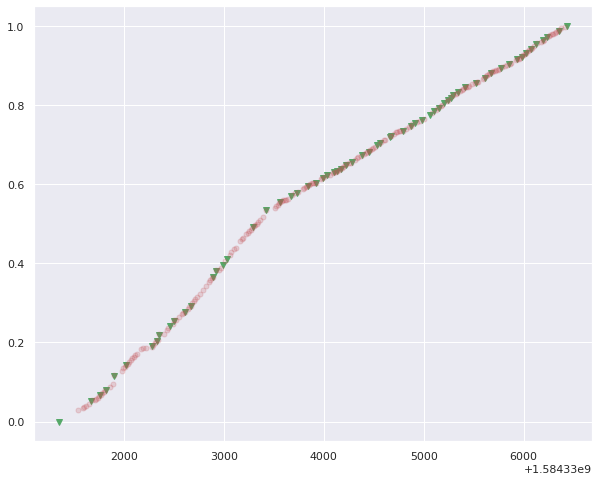

Predict for trips TRIPS02
There is no decrease distance


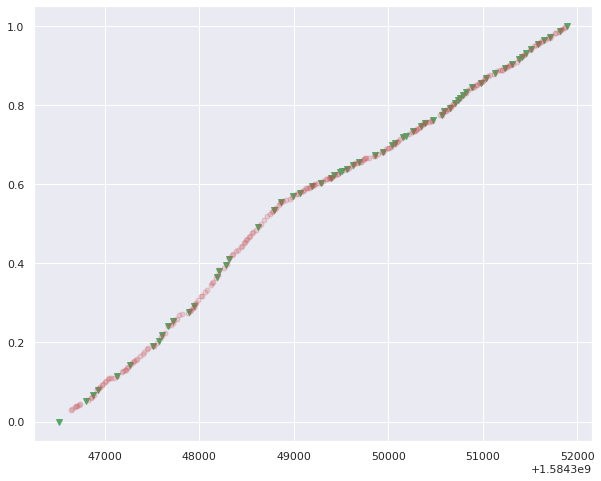

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Predic for bus 53N5002
There are 4 trips: TRIPS00, TRIPS01, TRIPS02, TRIPS03
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 20 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


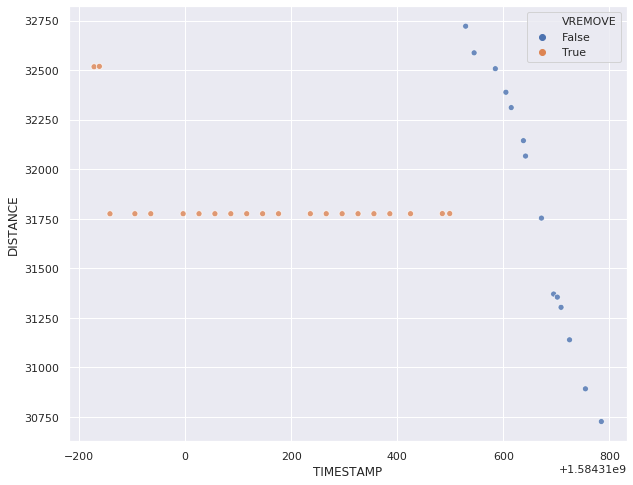

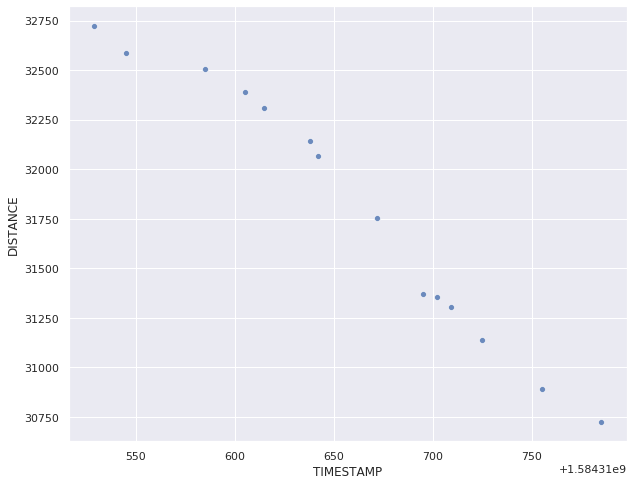

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 51 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


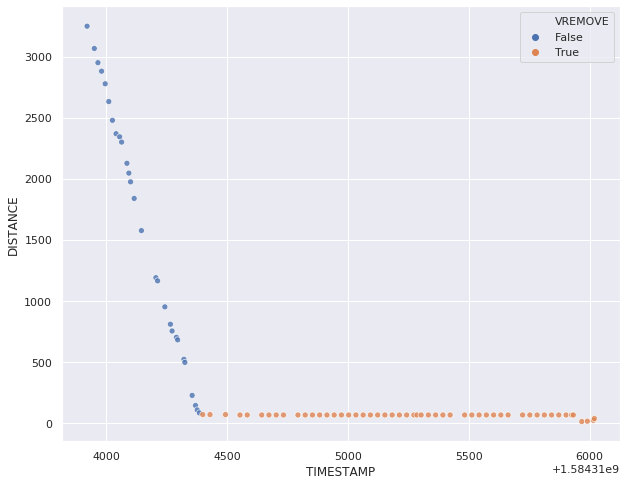

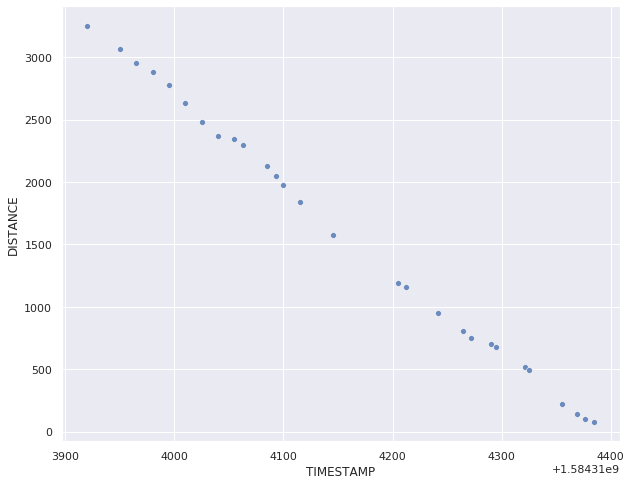

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


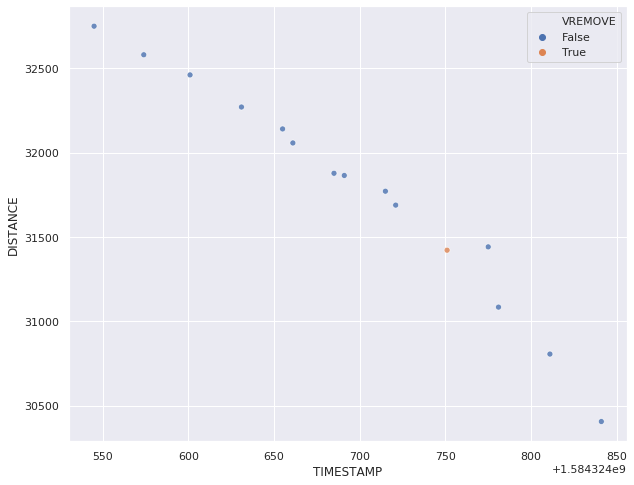

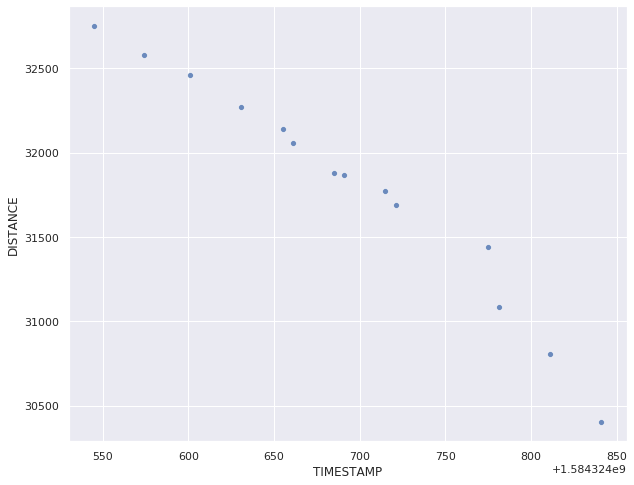

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 78 outlier.
Detected 2 outlier.
Detected 0 outlier.
There is no outliers remain!


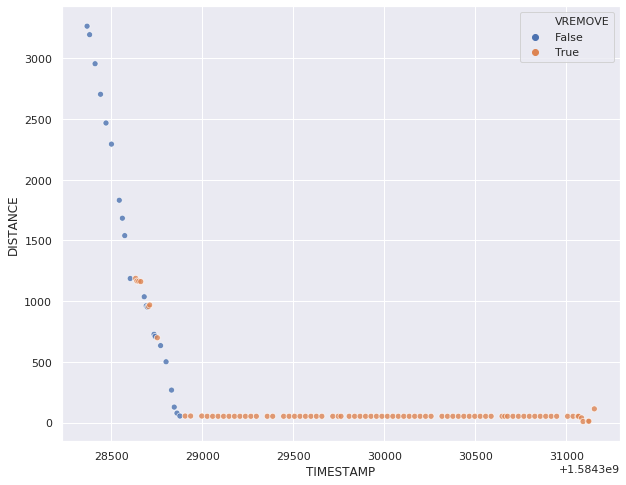

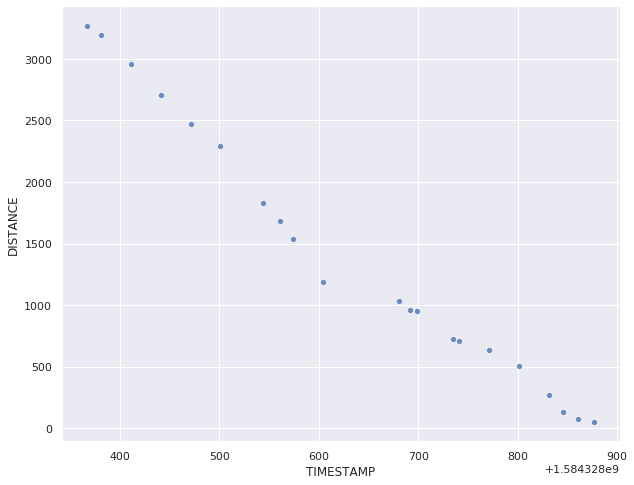

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


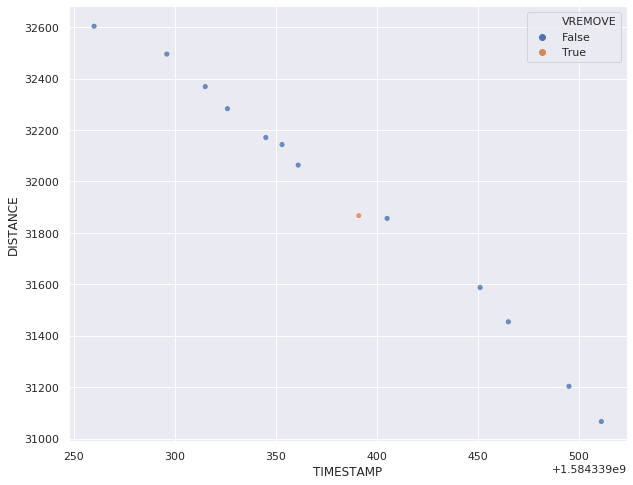

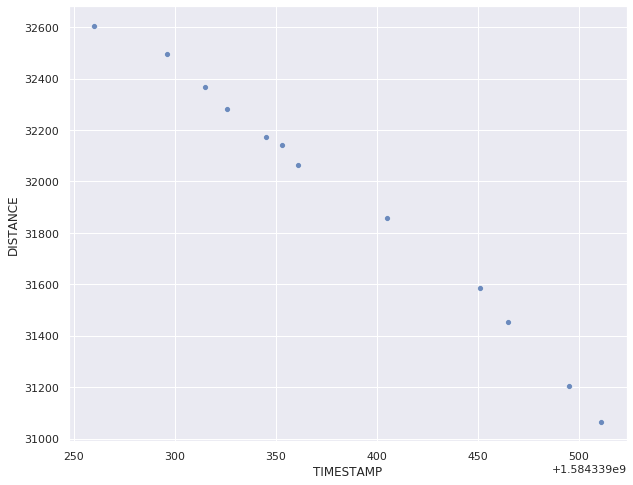

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 121 outlier.
Detected 0 outlier.
There is no outliers remain!


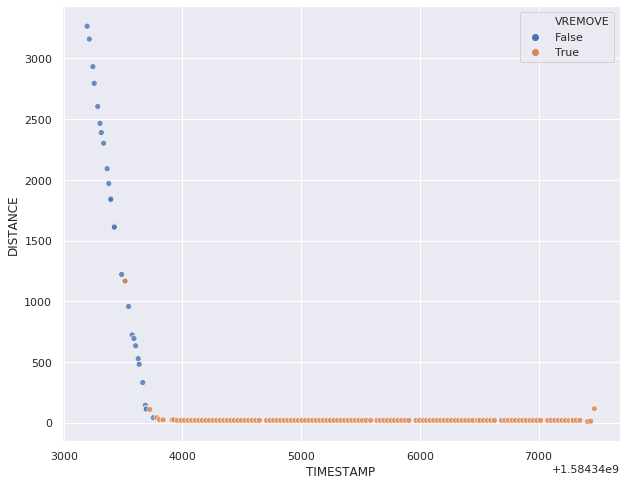

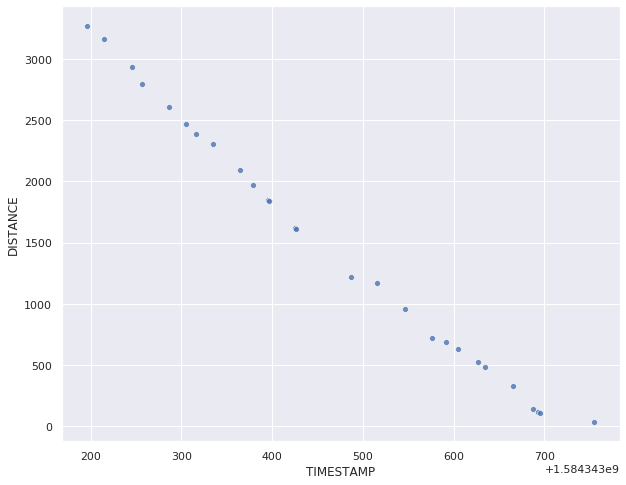

Remove outliers for trips: TRIPS03
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


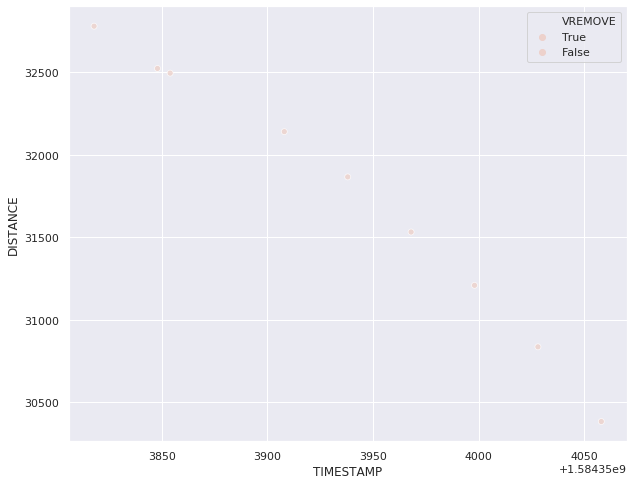

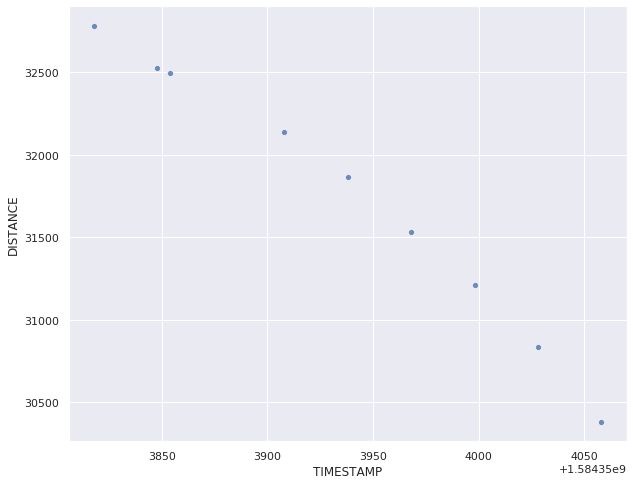

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 12 outlier.
Detected 2 outlier.
Detected 2 outlier.
Detected 0 outlier.
There is no outliers remain!


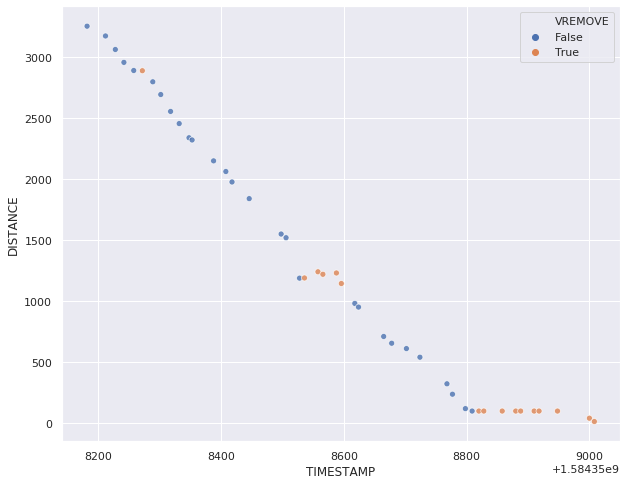

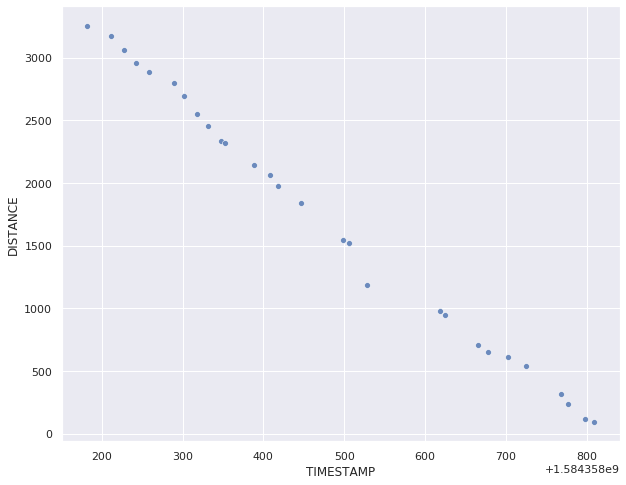

Predict for trips TRIPS00
There is no decrease distance


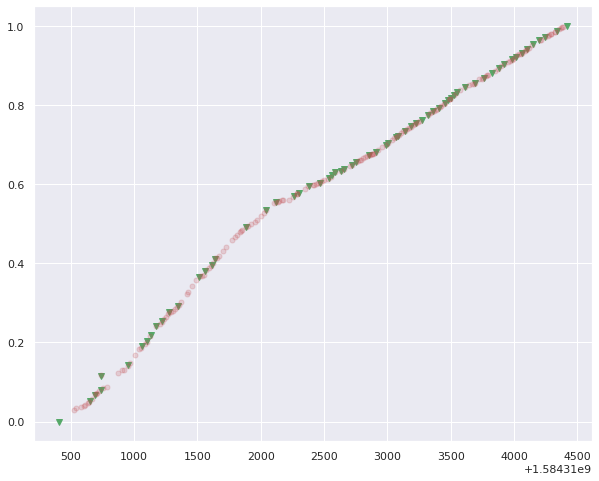

Predict for trips TRIPS01
There is no decrease distance


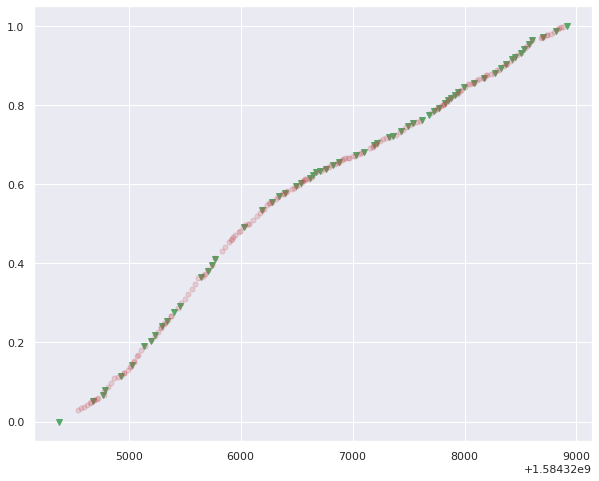

Predict for trips TRIPS02
There is no decrease distance


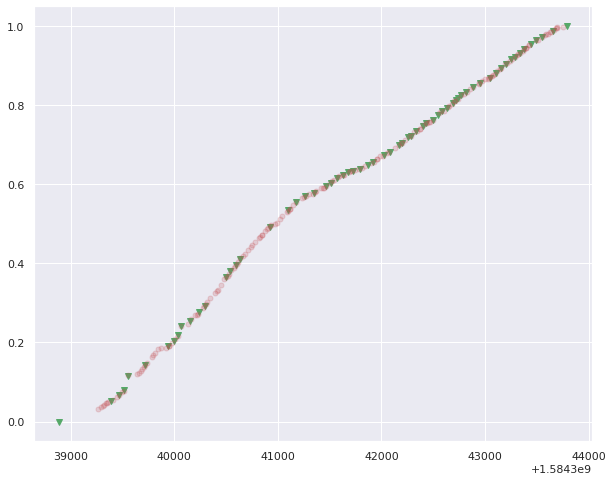

Predict for trips TRIPS03
There is no decrease distance


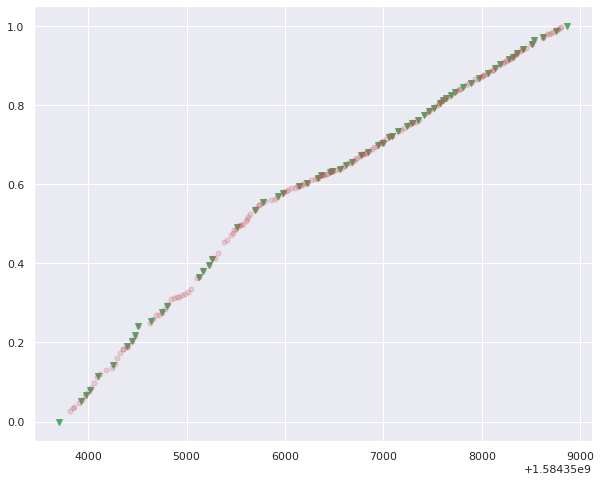

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Convert column name ARRIVETIMETRIPS03
Predic for bus 53N5040
There are 4 trips: TRIPS00, TRIPS01, TRIPS02, TRIPS03
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


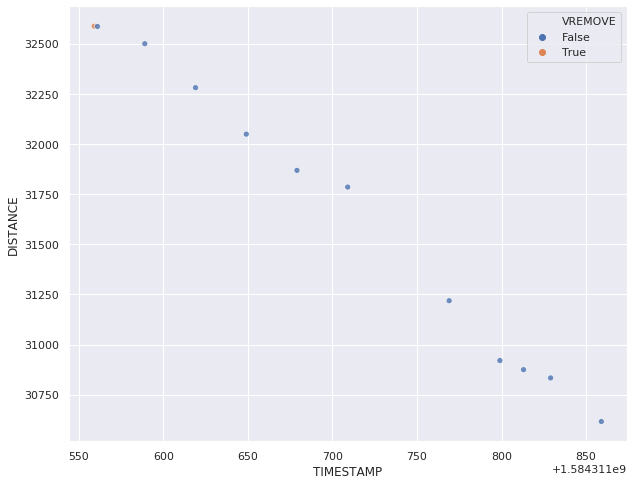

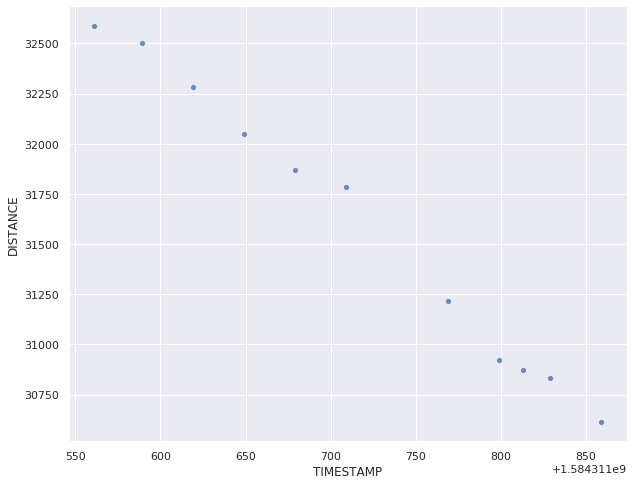

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 46 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


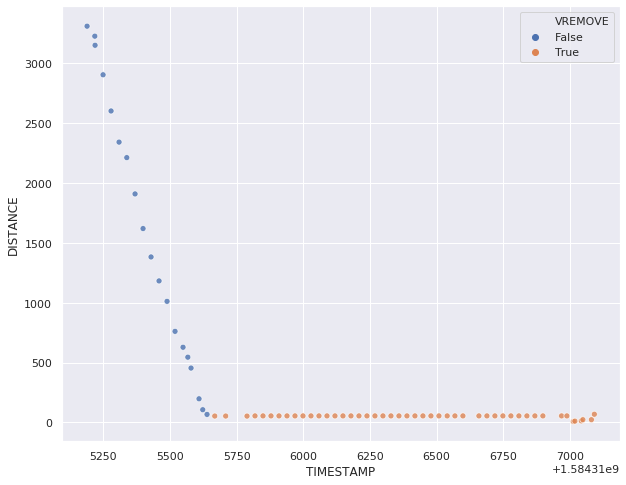

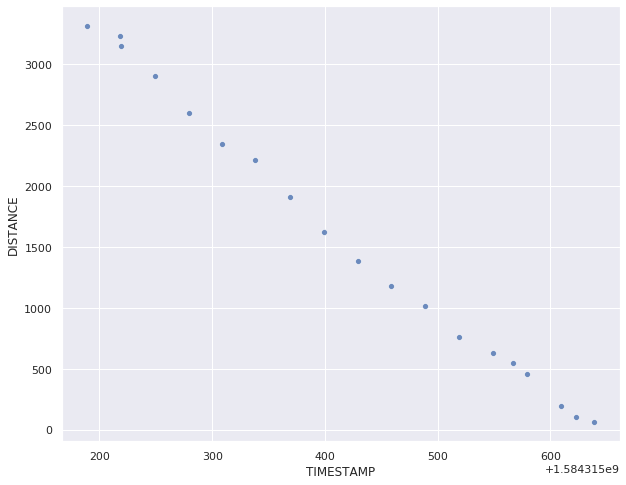

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


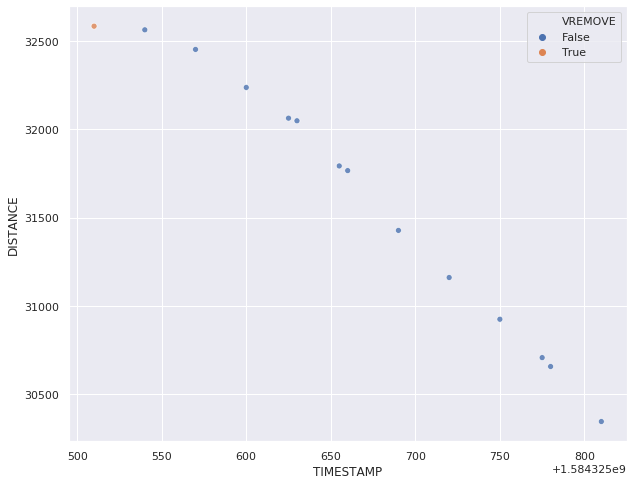

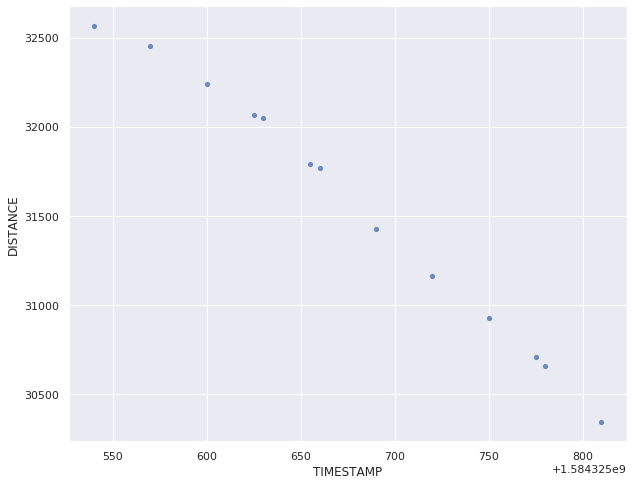

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 69 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


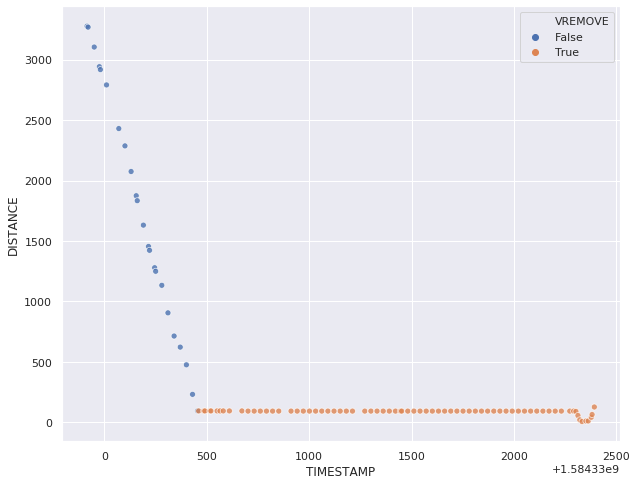

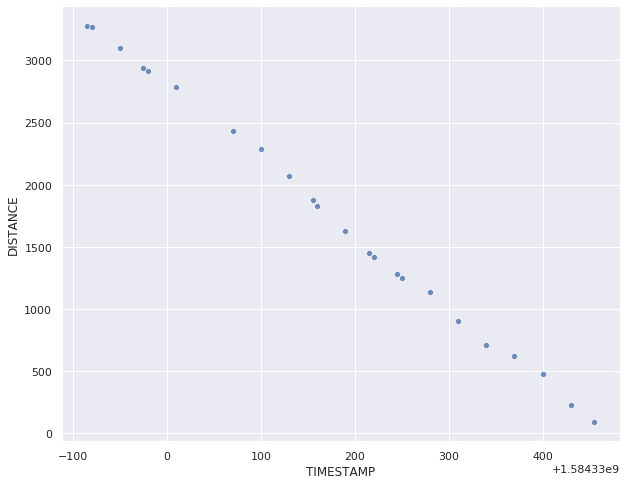

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 2 outlier.
Detected 0 outlier.
There is no outliers remain!


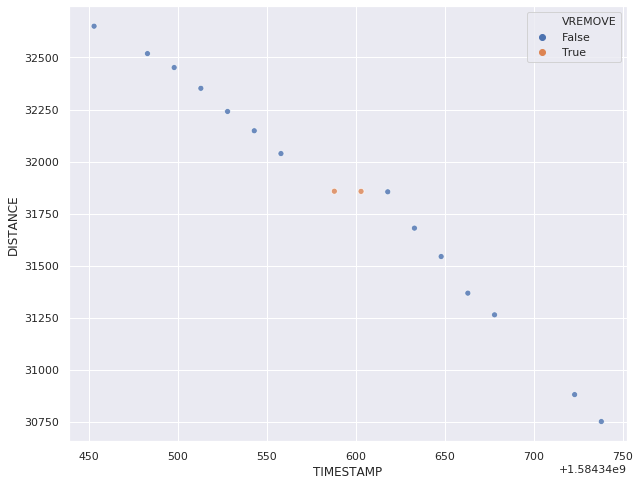

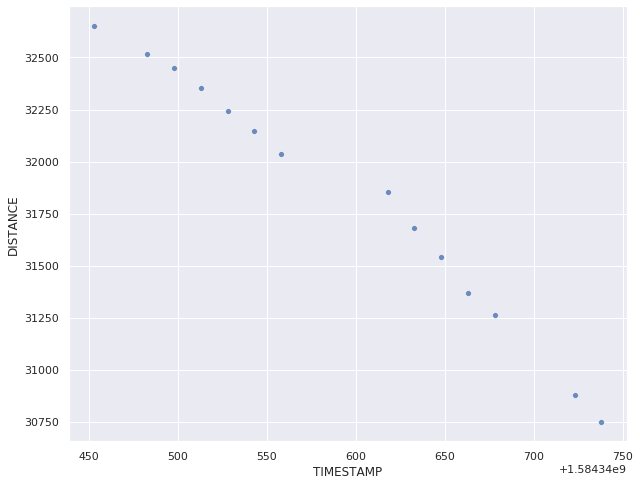

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 113 outlier.
Detected 2 outlier.
Detected 0 outlier.
There is no outliers remain!


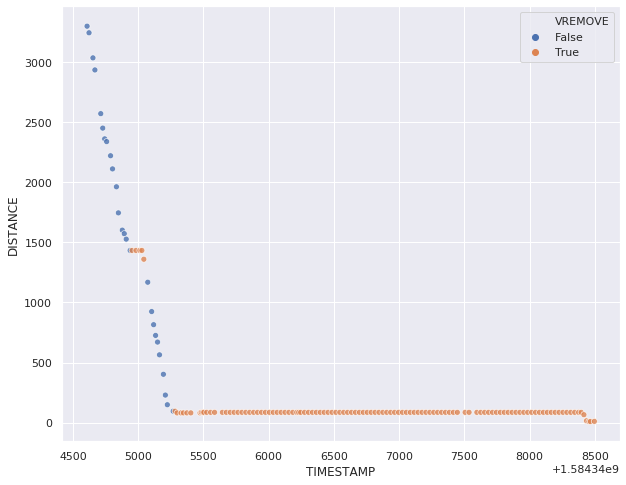

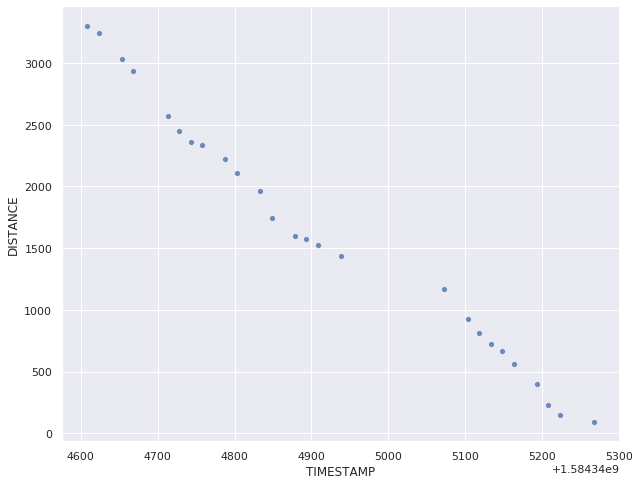

Remove outliers for trips: TRIPS03
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


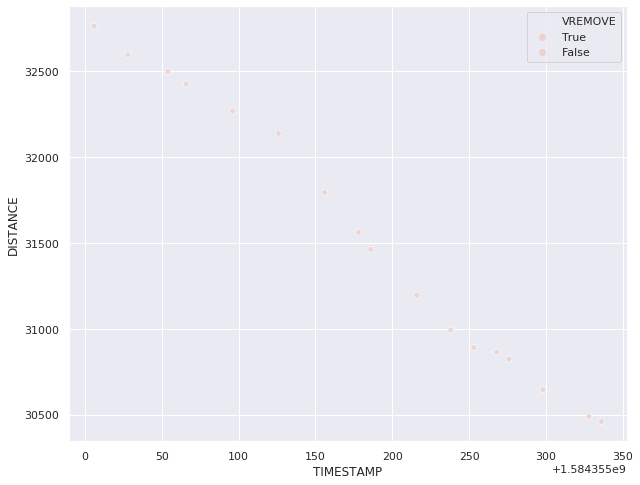

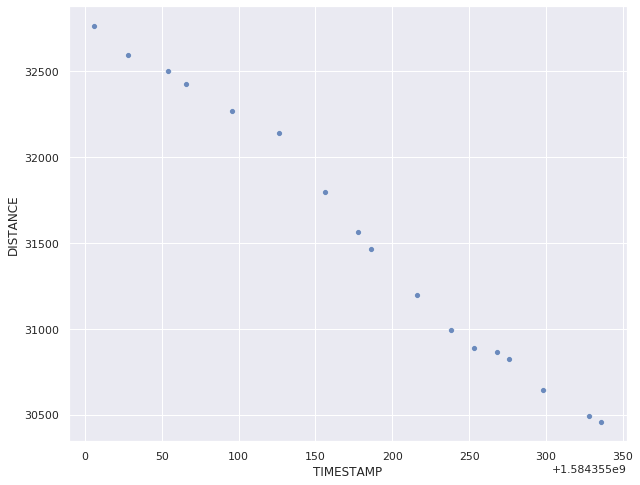

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 6 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


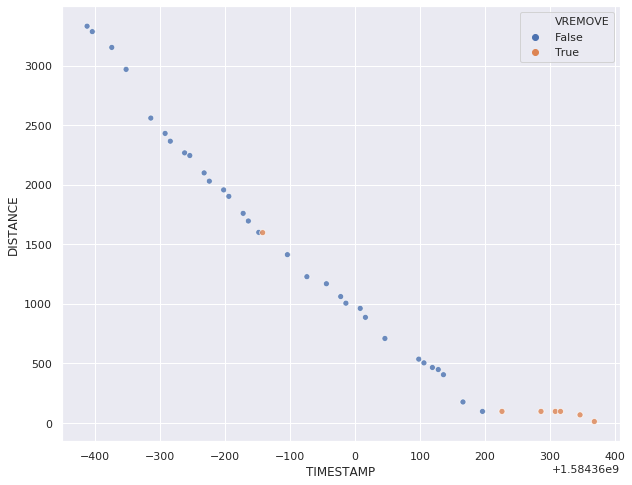

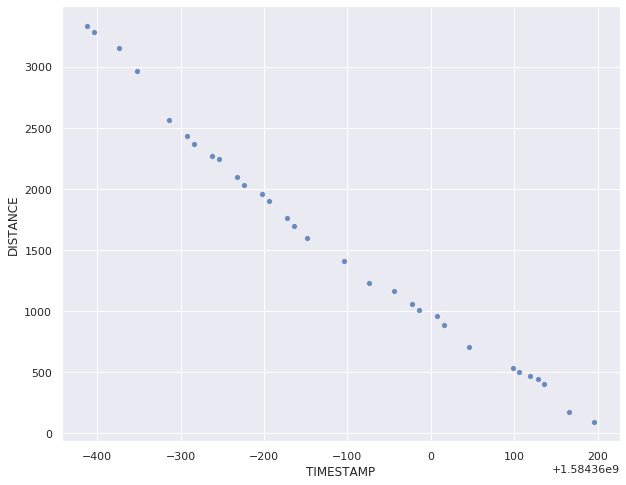

Predict for trips TRIPS00
There is no decrease distance


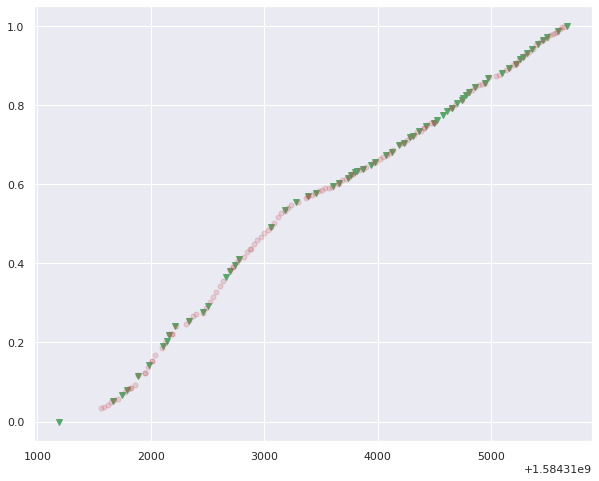

Predict for trips TRIPS01
There is no decrease distance


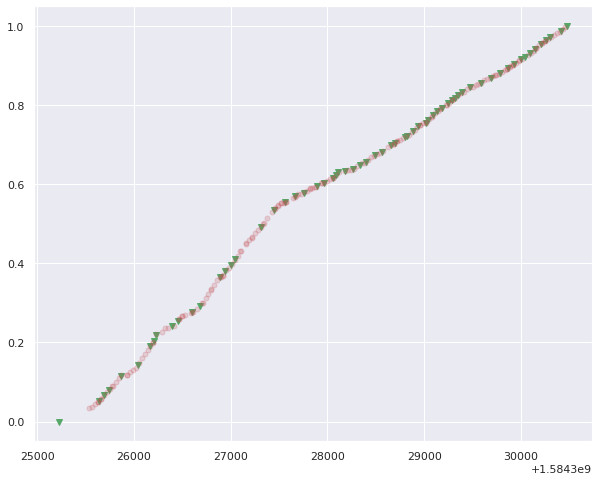

Predict for trips TRIPS02
There is no decrease distance


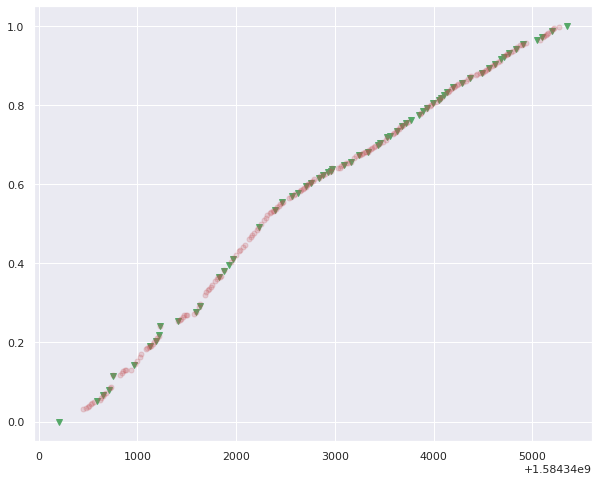

Predict for trips TRIPS03
There is no decrease distance


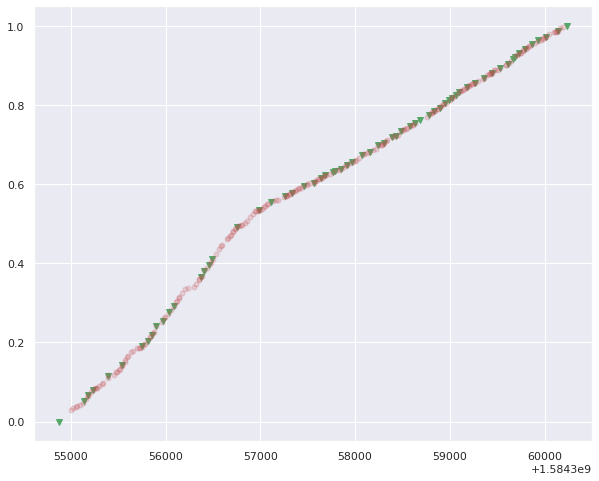

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Convert column name ARRIVETIMETRIPS03
Predic for bus 53N5053
There are 4 trips: TRIPS00, TRIPS01, TRIPS02, TRIPS03
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 32 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


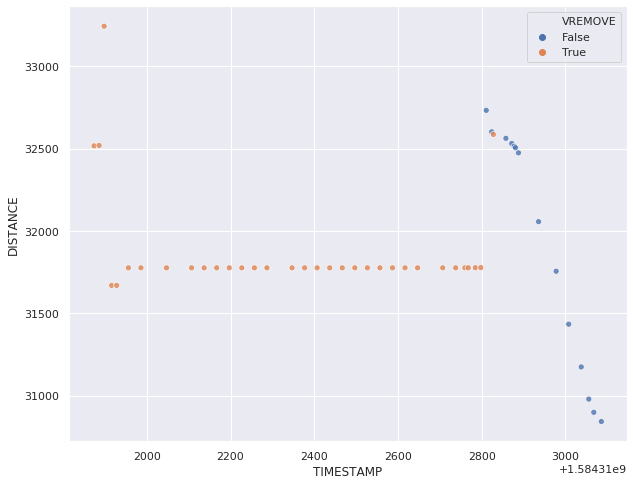

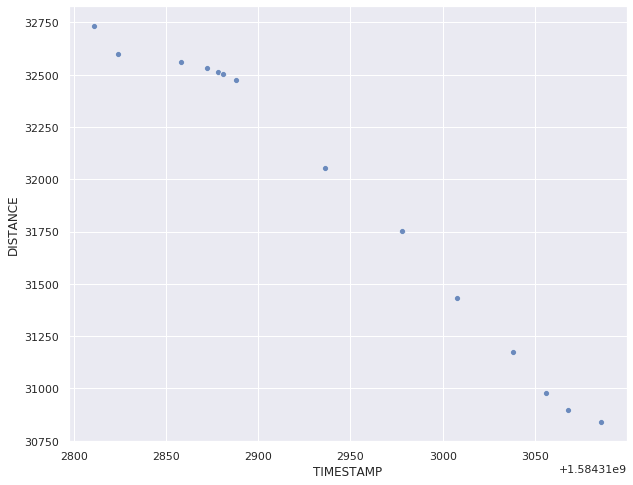

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 53 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


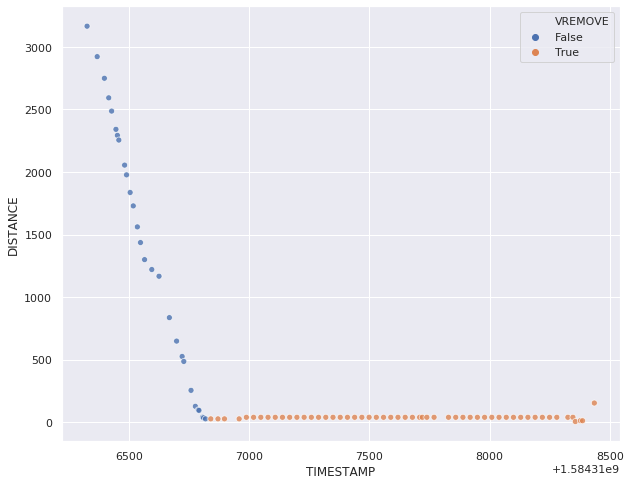

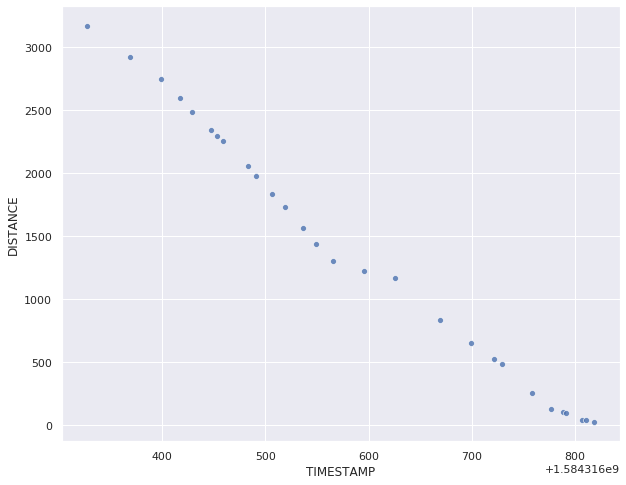

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


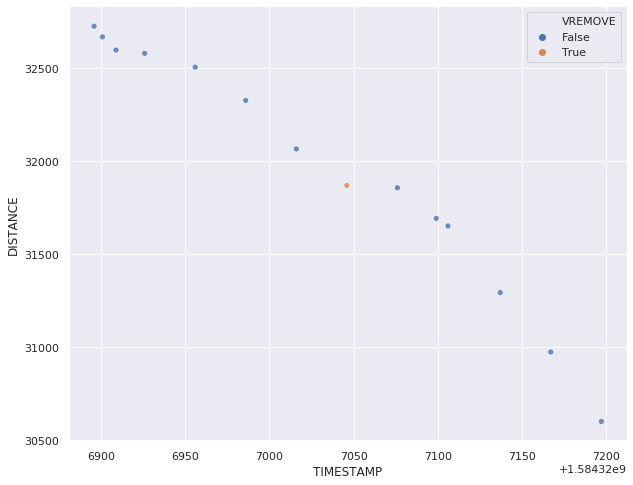

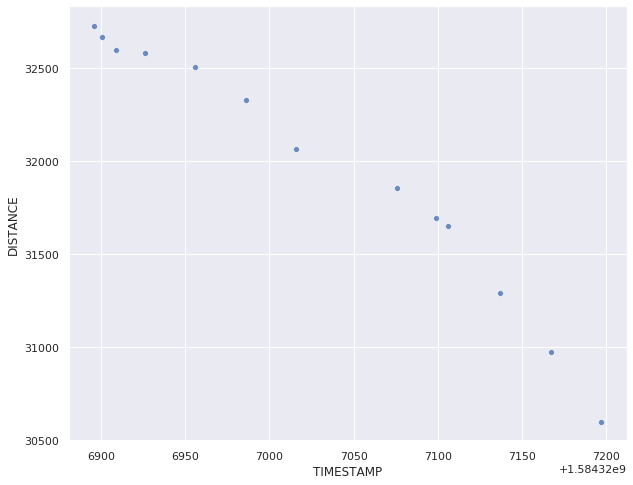

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 76 outlier.
Detected 2 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


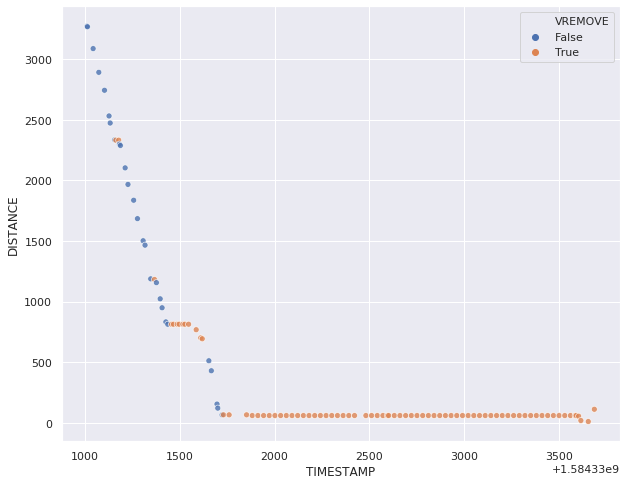

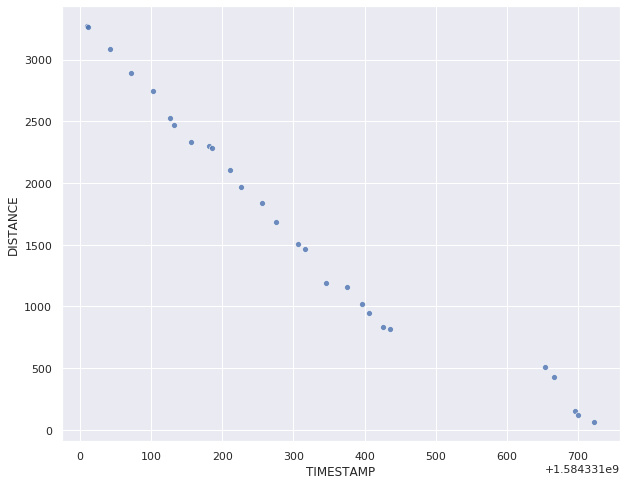

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 2 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


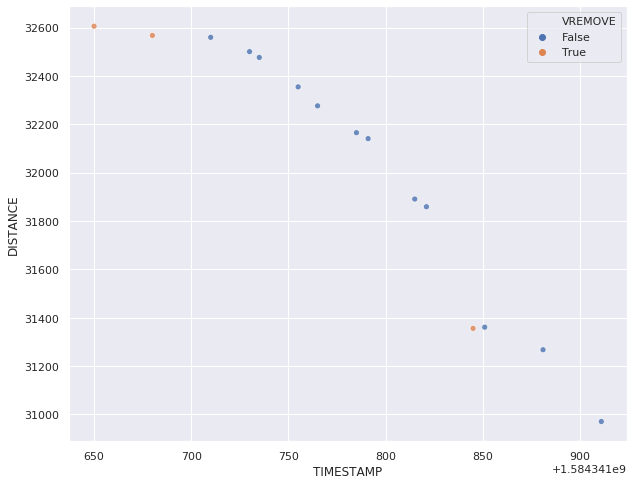

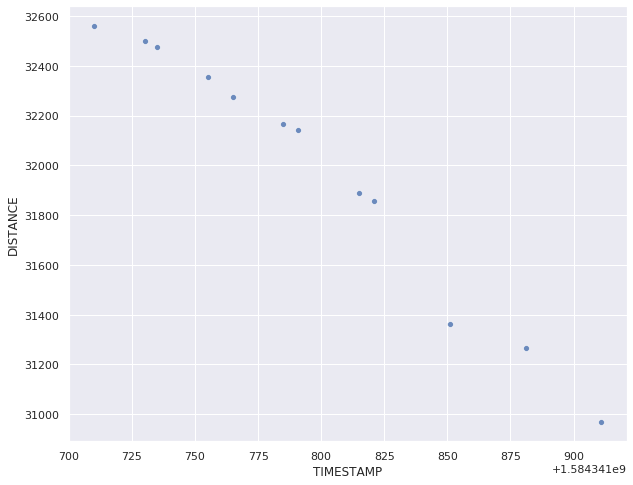

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 116 outlier.
Detected 0 outlier.
There is no outliers remain!


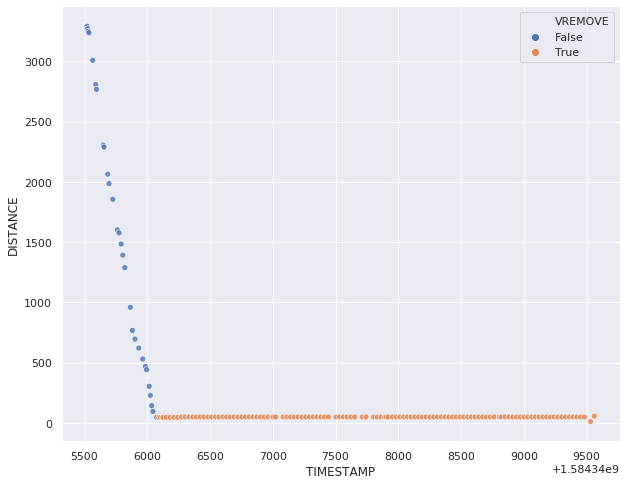

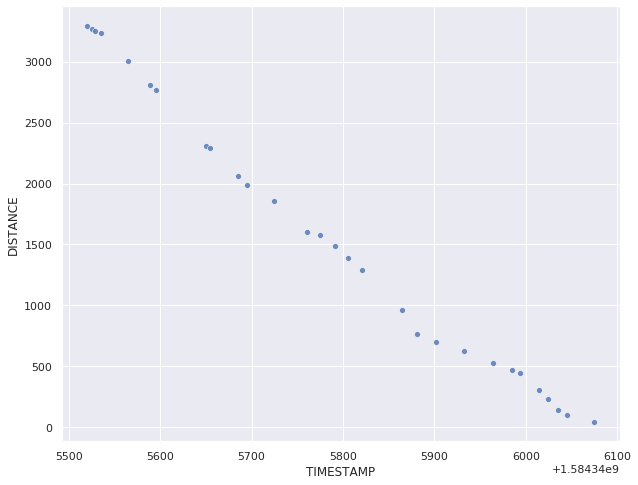

Remove outliers for trips: TRIPS03
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


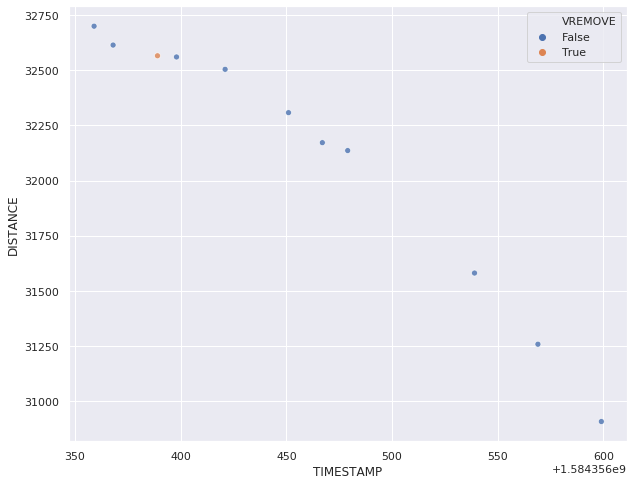

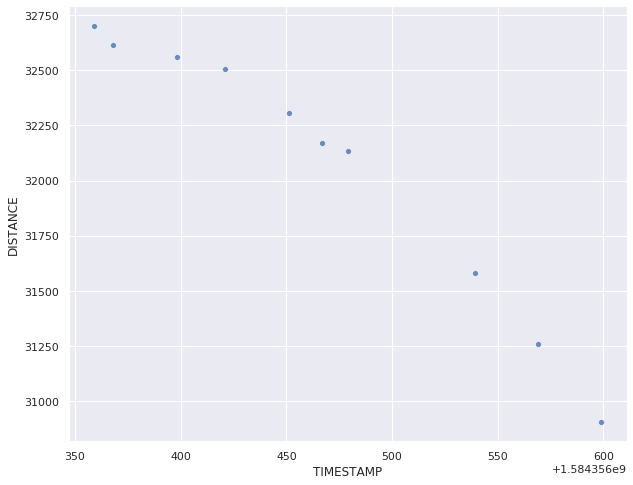

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 10 outlier.
Detected 2 outlier.
Detected 0 outlier.
There is no outliers remain!


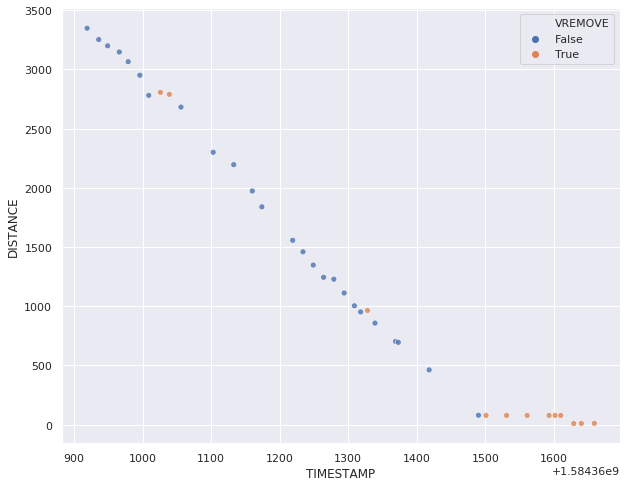

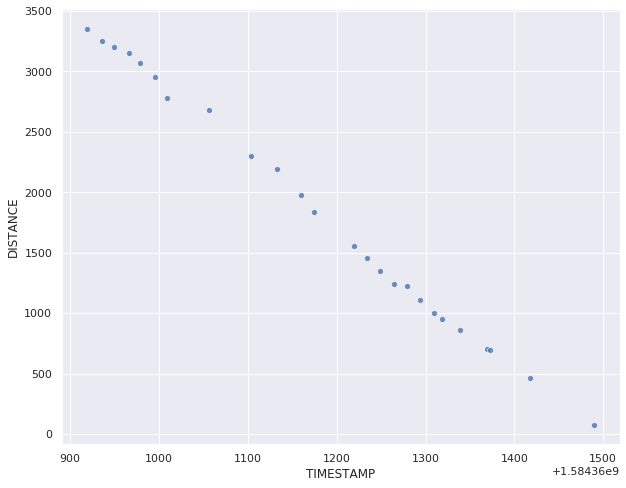

Predict for trips TRIPS00
There is no decrease distance


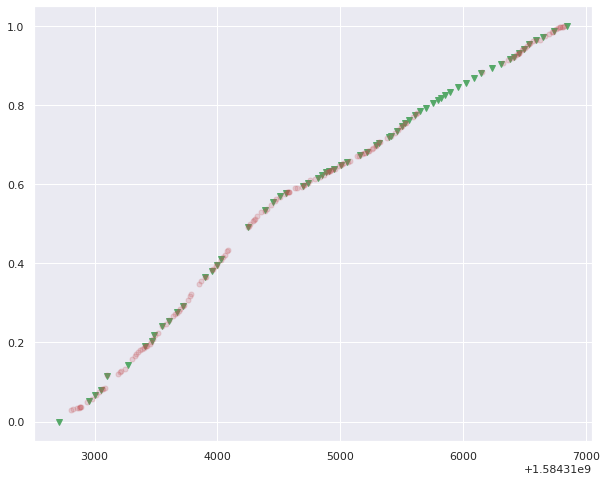

Predict for trips TRIPS01
There is no decrease distance


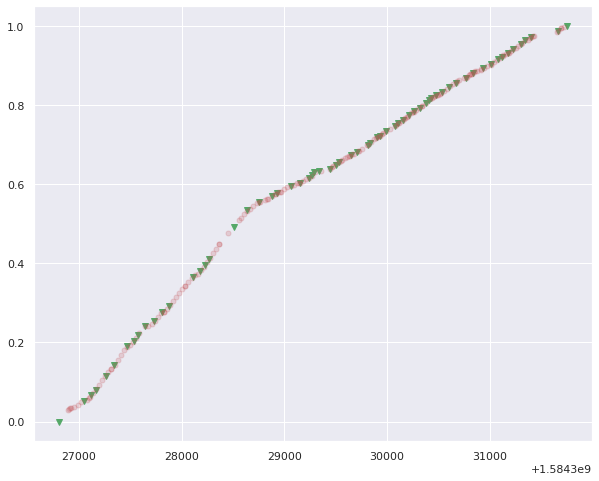

Predict for trips TRIPS02
There is no decrease distance


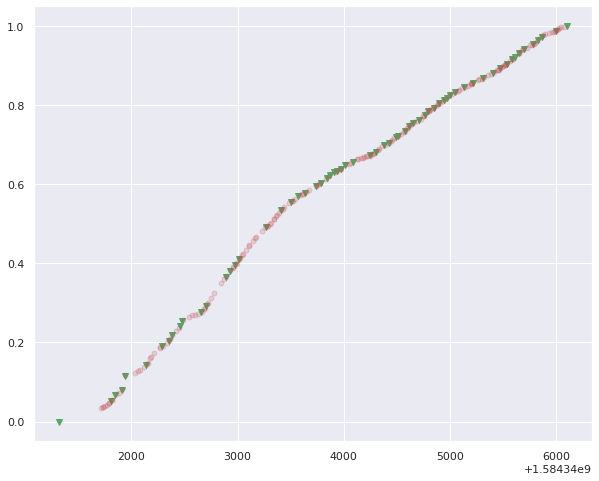

Predict for trips TRIPS03
There is no decrease distance


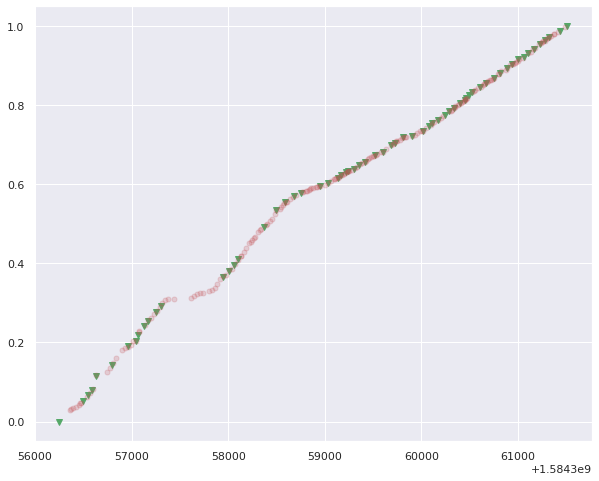

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Convert column name ARRIVETIMETRIPS03
Predic for bus 53N5013
There are 4 trips: TRIPS00, TRIPS01, TRIPS02, TRIPS03
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


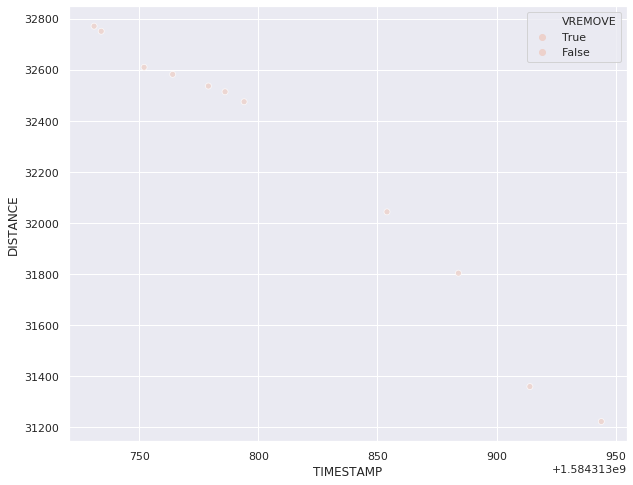

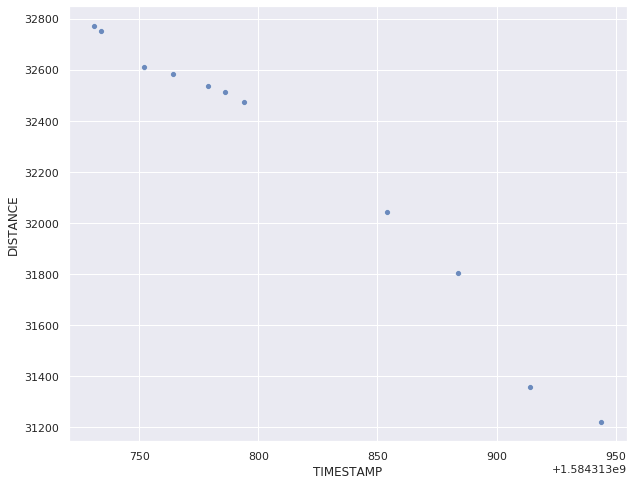

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 53 outlier.
Detected 2 outlier.
Detected 0 outlier.
There is no outliers remain!


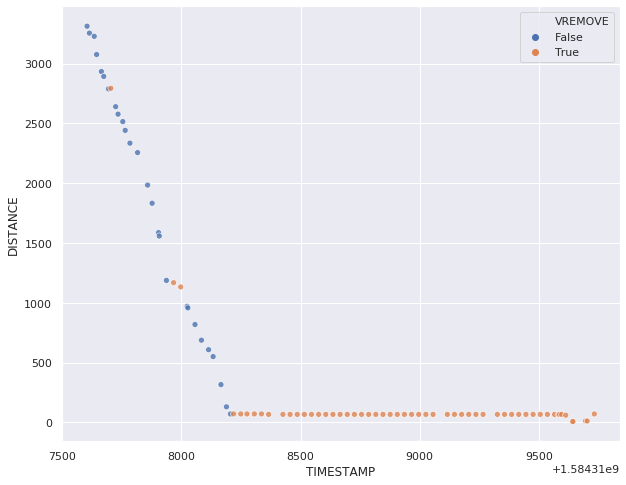

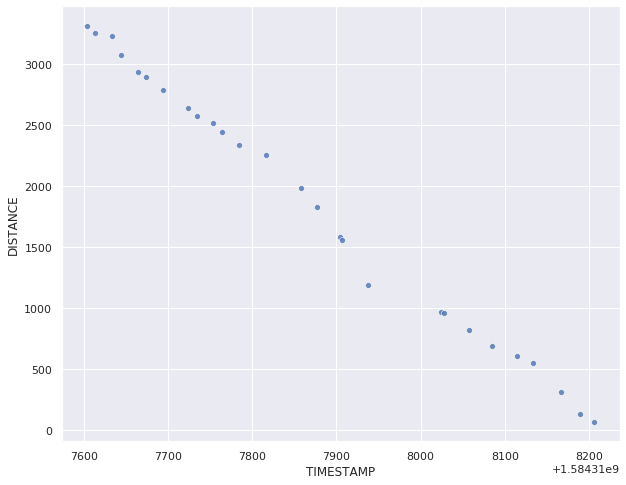

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


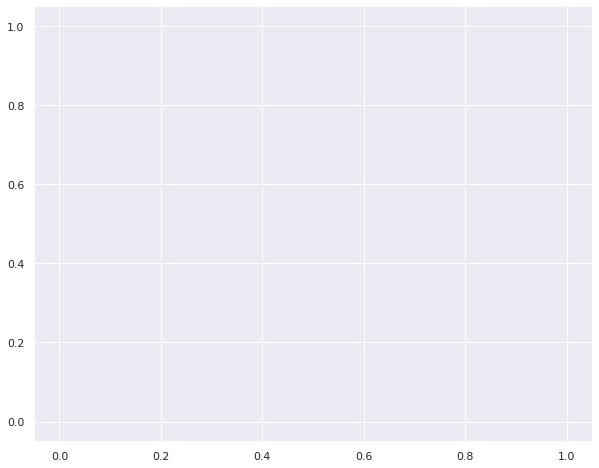

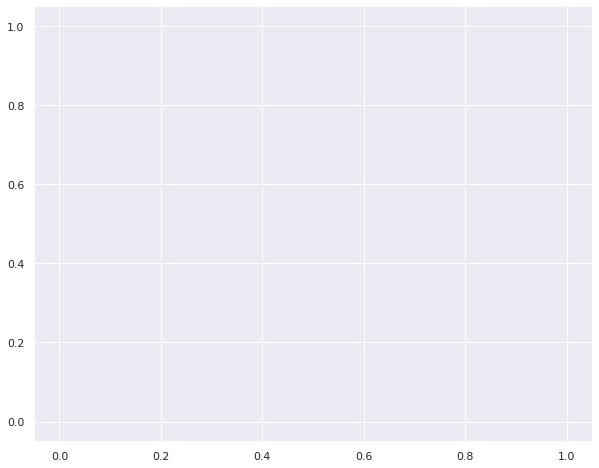

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 78 outlier.
Detected 0 outlier.
There is no outliers remain!


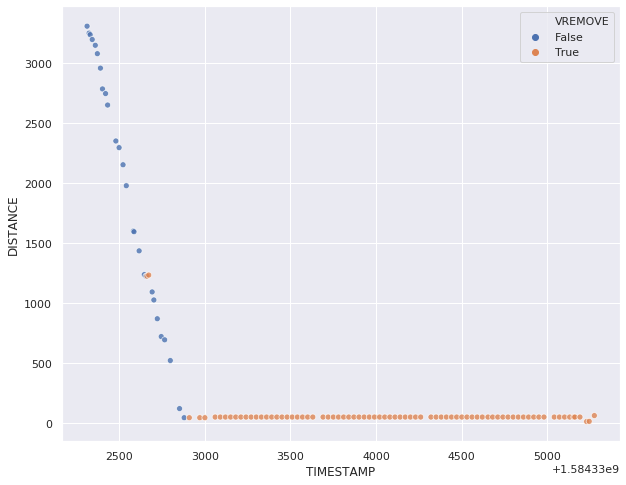

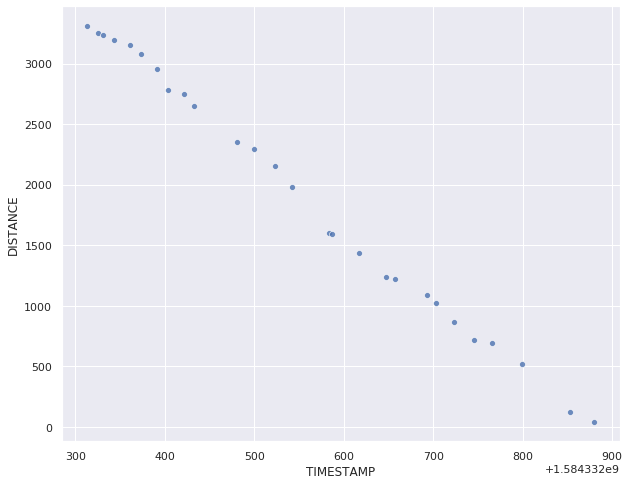

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


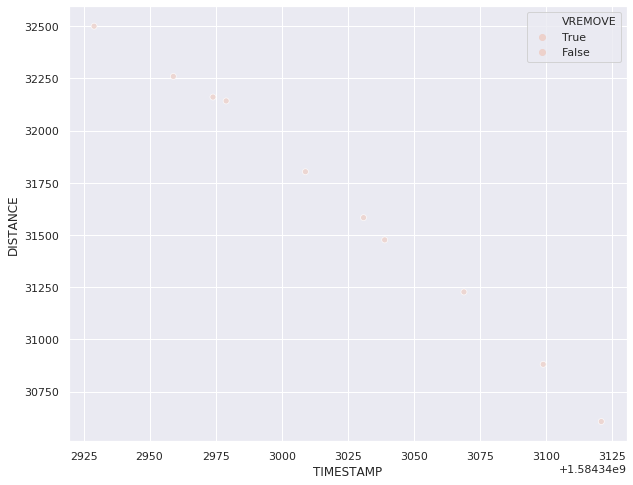

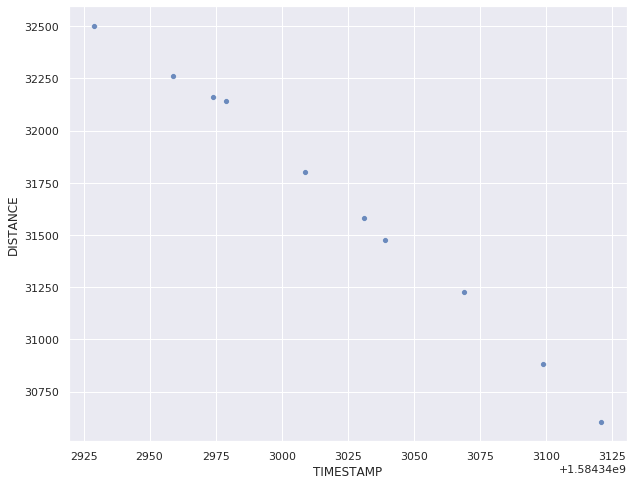

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 94 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


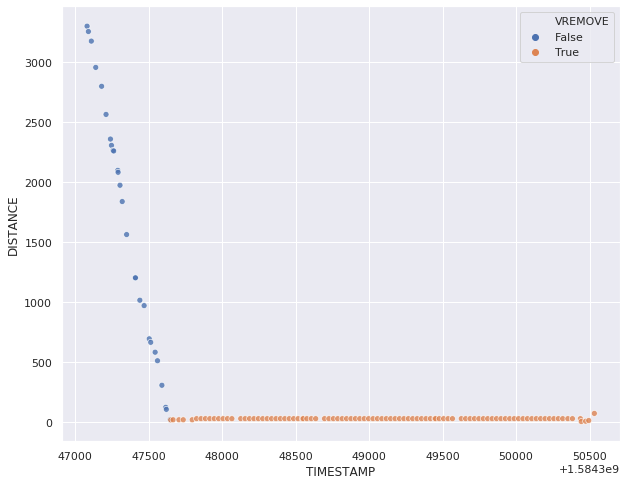

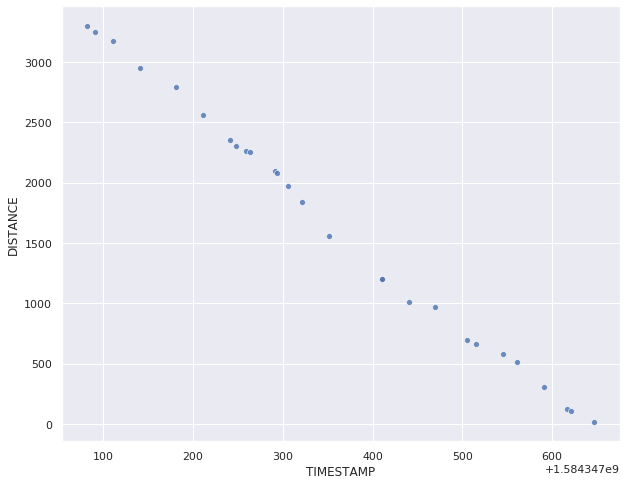

Remove outliers for trips: TRIPS03
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 4 outlier.
Detected 0 outlier.
There is no outliers remain!


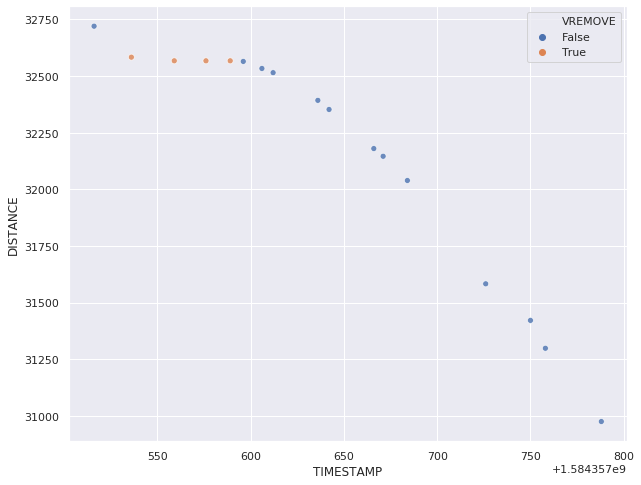

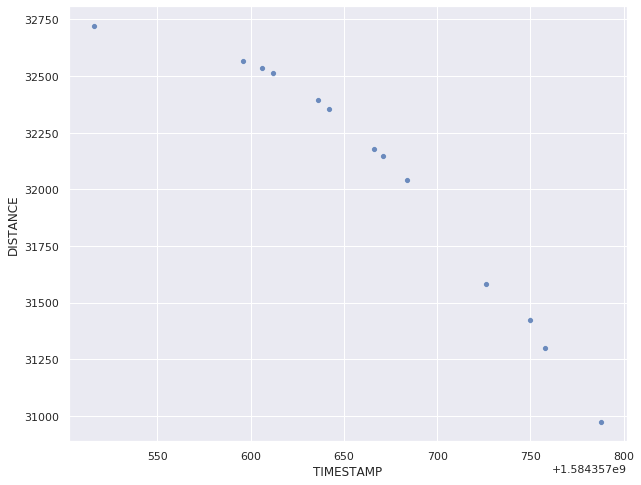

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 7 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


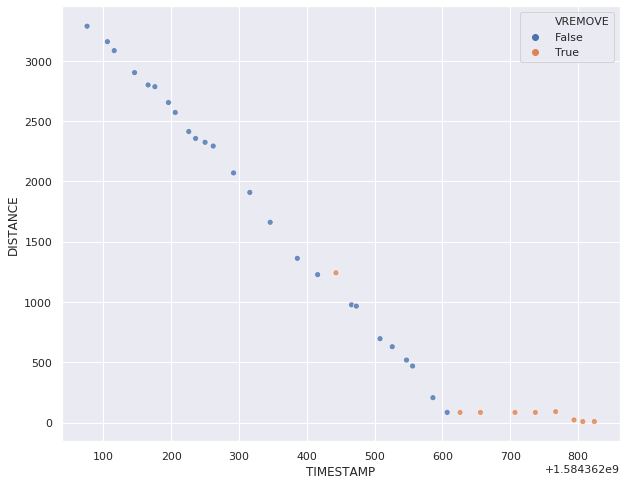

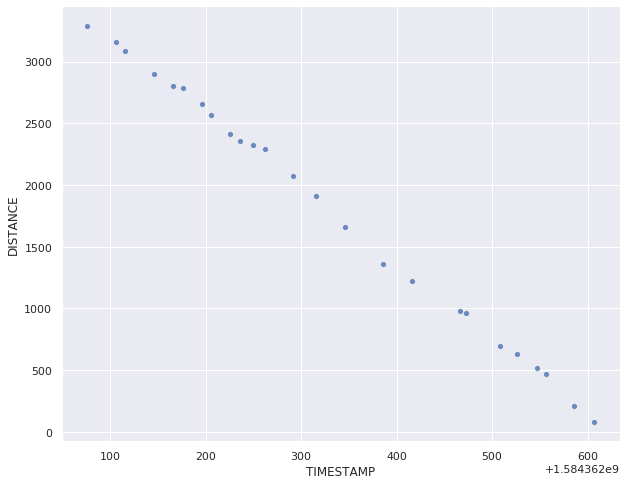

Predict for trips TRIPS00
There is no decrease distance


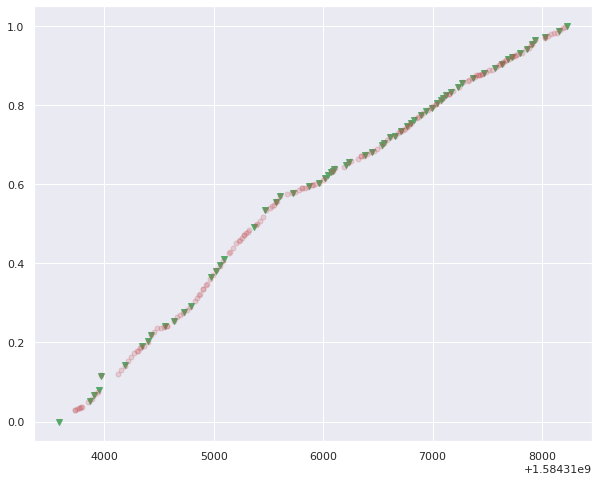

Predict for trips TRIPS01
There is no decrease distance


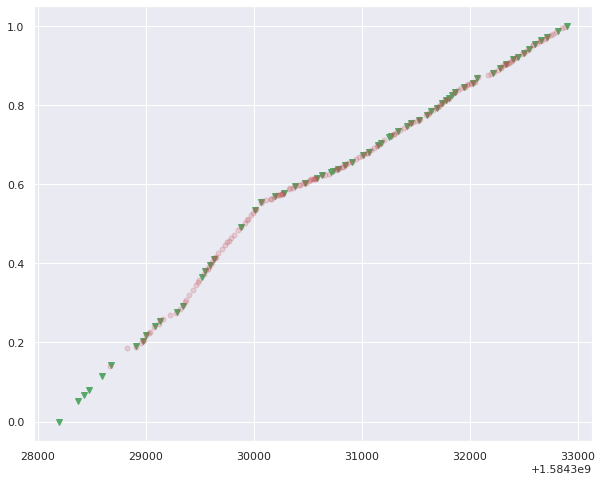

Predict for trips TRIPS02
There is no decrease distance


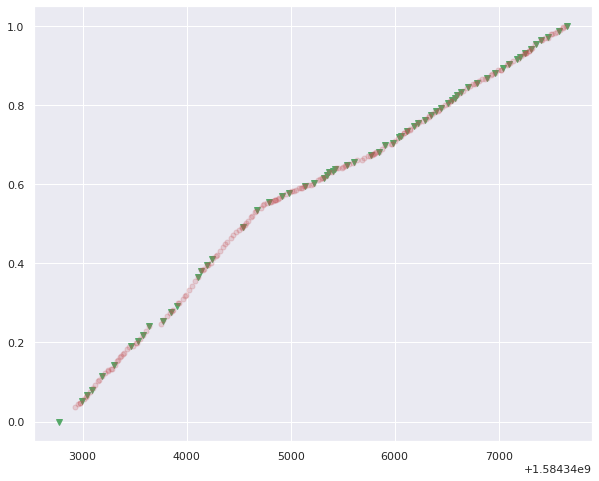

Predict for trips TRIPS03
There is no decrease distance


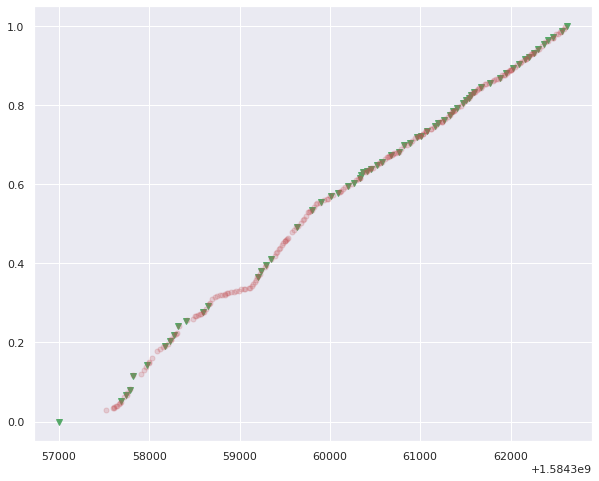

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Convert column name ARRIVETIMETRIPS03
Predic for bus 51B31288
There are 4 trips: TRIPS00, TRIPS01, TRIPS02, TRIPS03
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 2 outlier.
Detected 0 outlier.
There is no outliers remain!


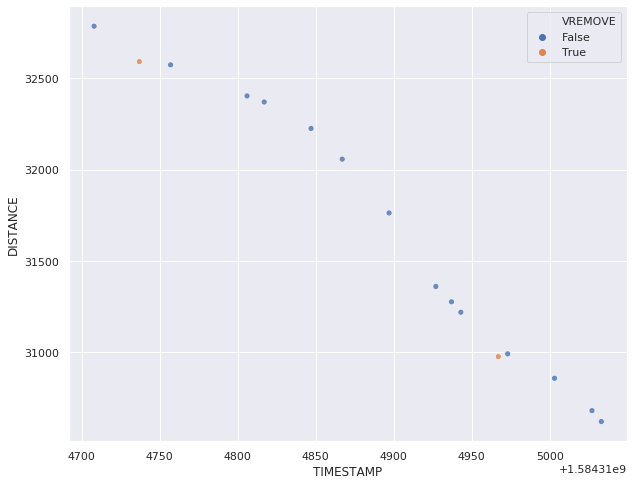

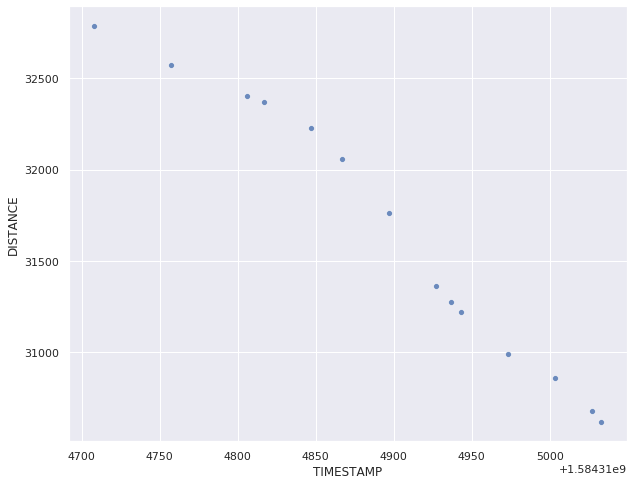

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 48 outlier.
Detected 0 outlier.
There is no outliers remain!


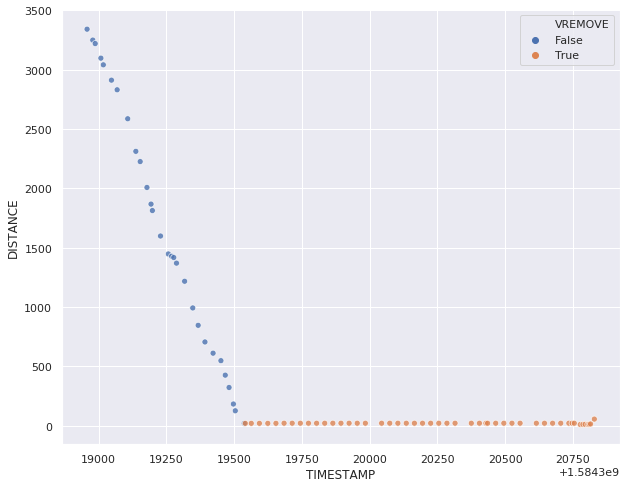

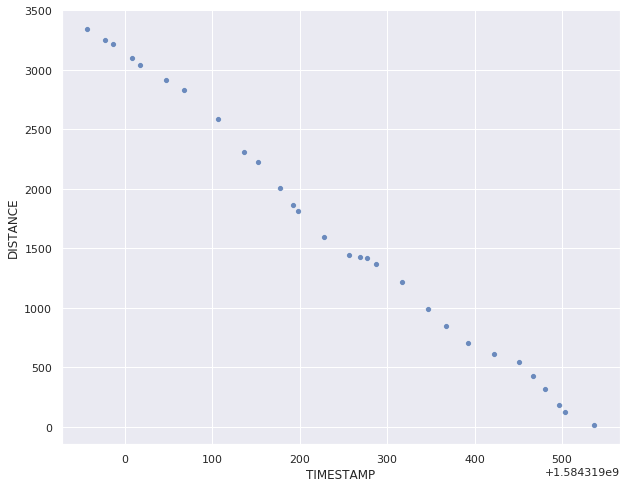

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


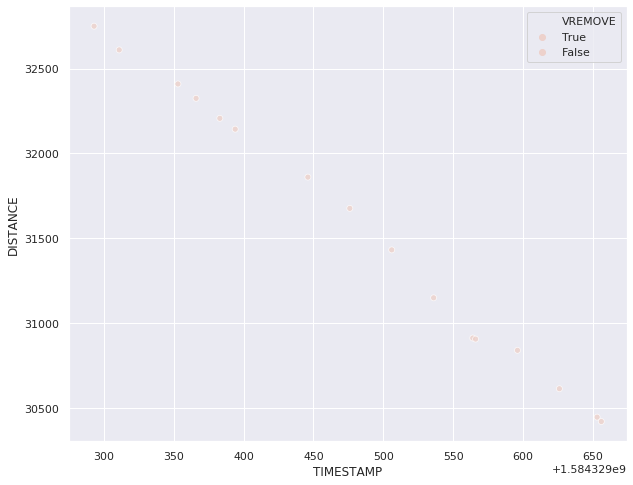

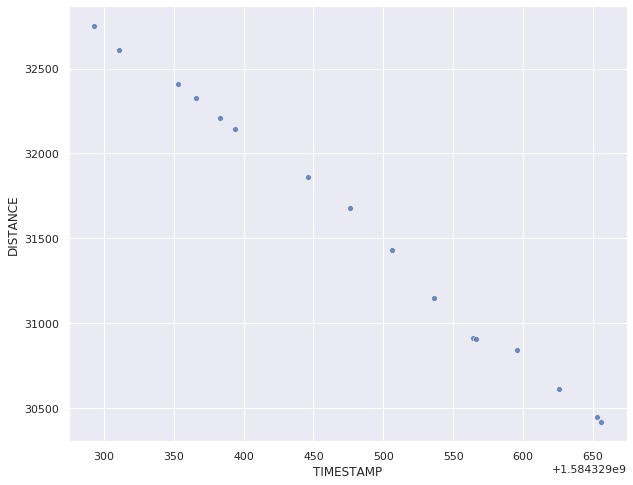

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 87 outlier.
Detected 0 outlier.
There is no outliers remain!


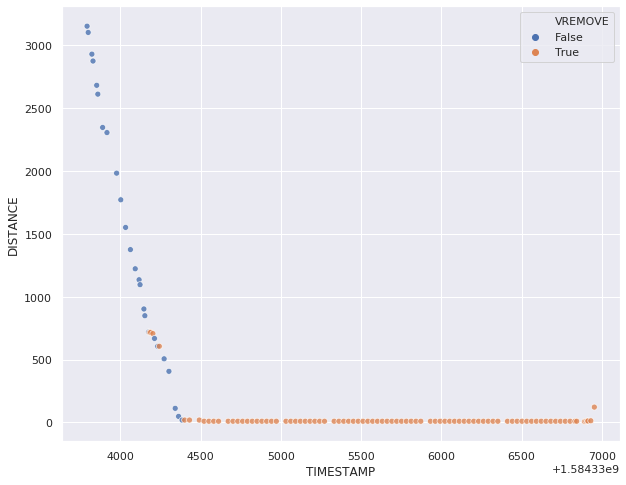

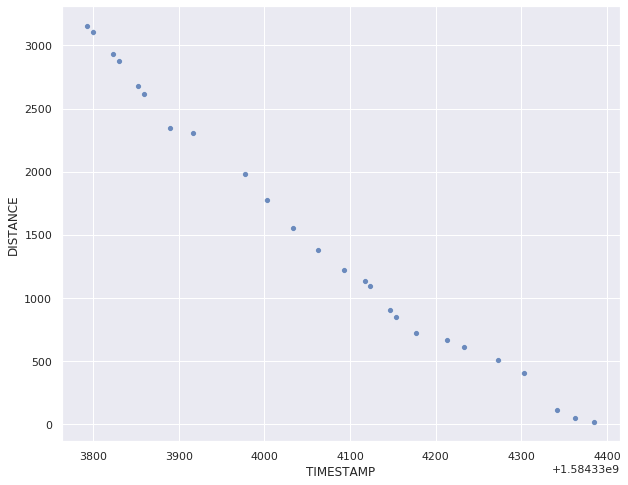

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


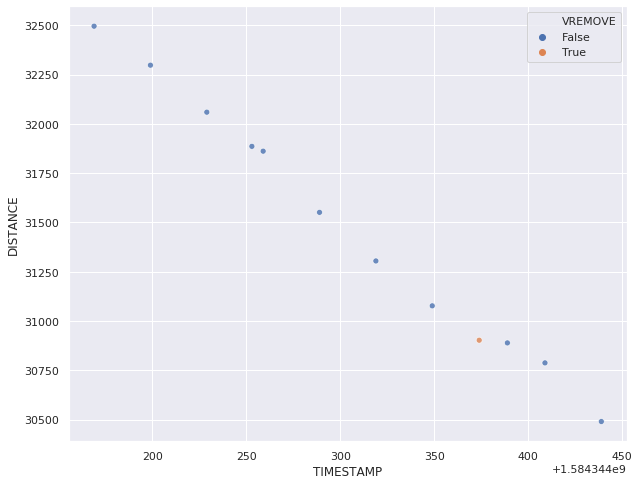

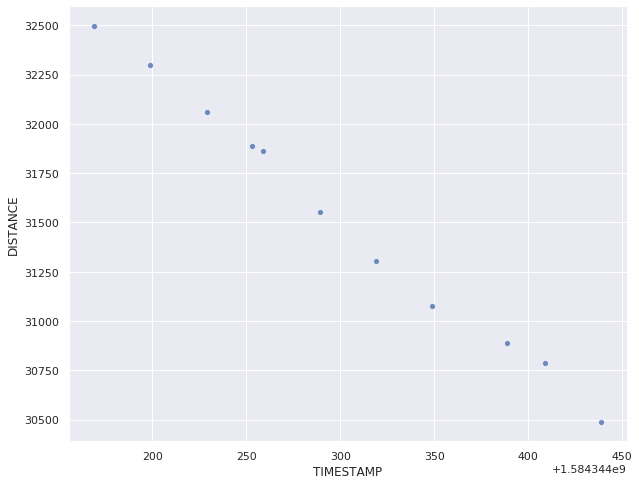

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 93 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


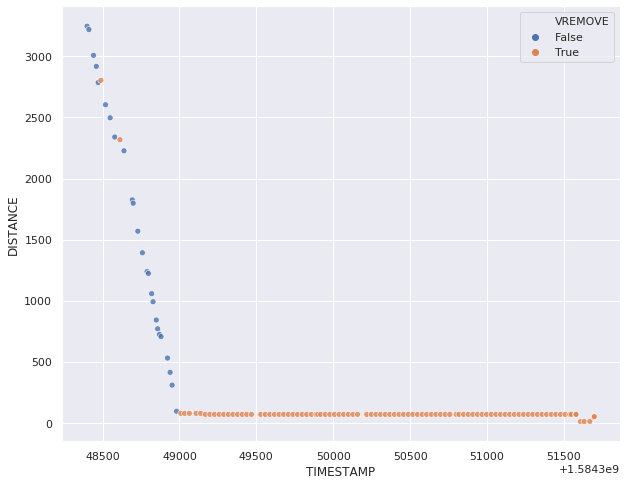

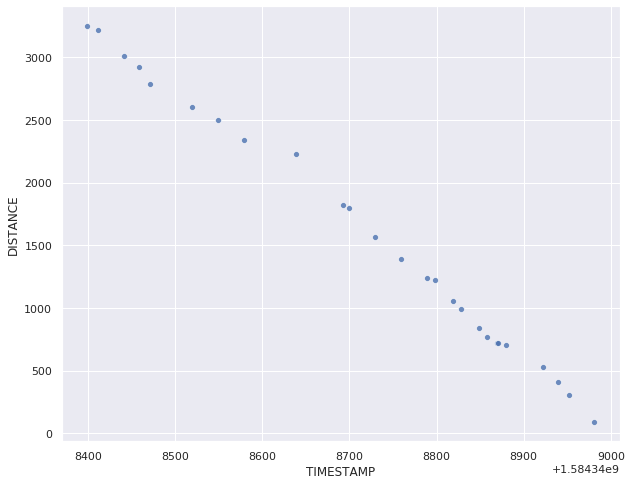

Remove outliers for trips: TRIPS03
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


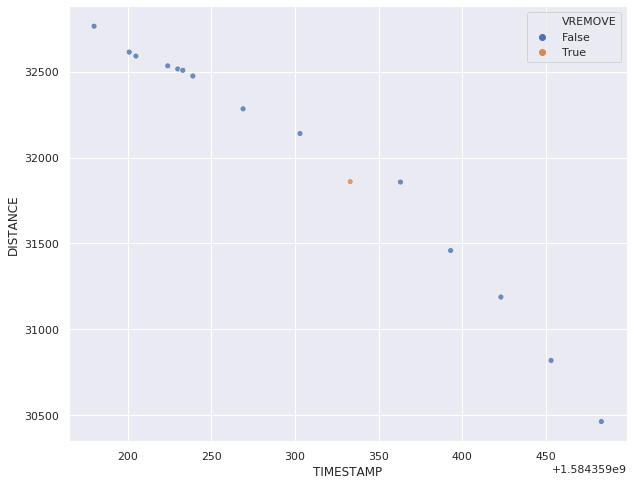

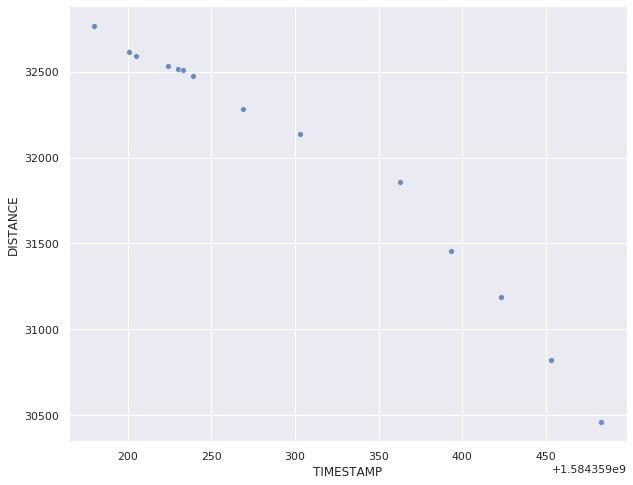

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 3 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


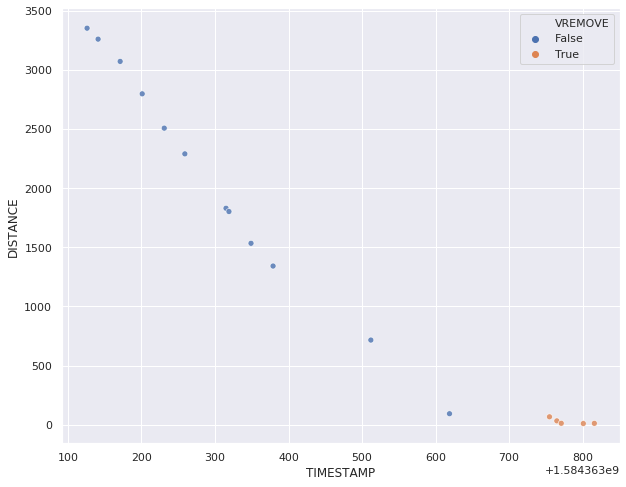

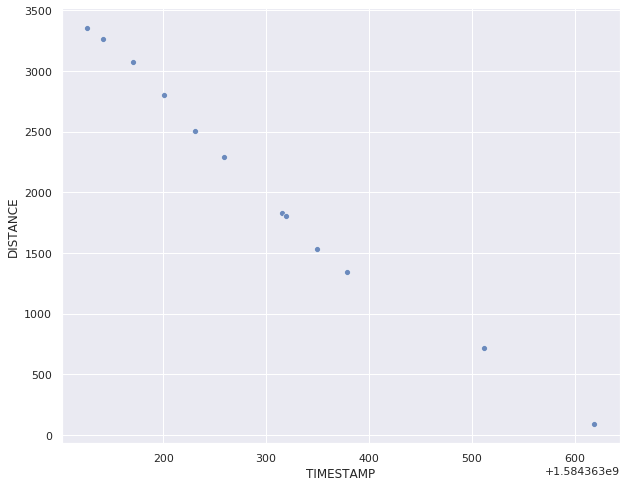

Predict for trips TRIPS00
There is no decrease distance


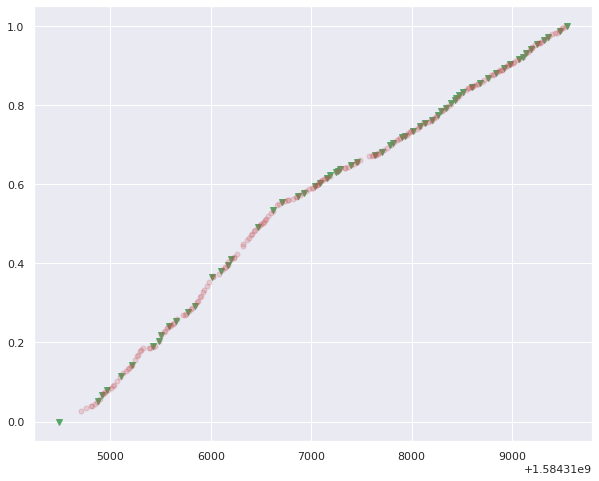

Predict for trips TRIPS01
There is no decrease distance


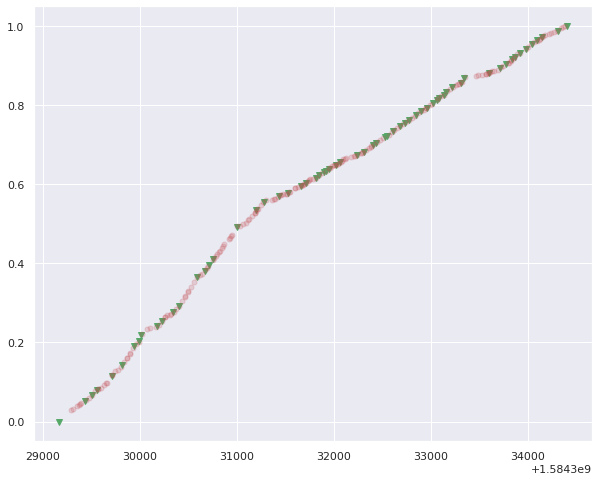

Predict for trips TRIPS02
There is no decrease distance


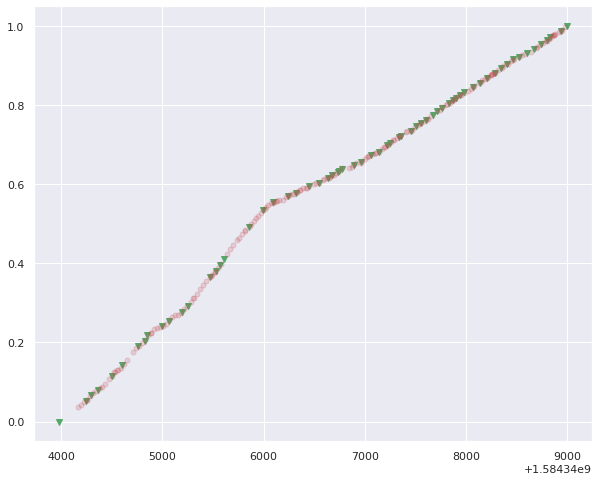

Predict for trips TRIPS03
There is no decrease distance


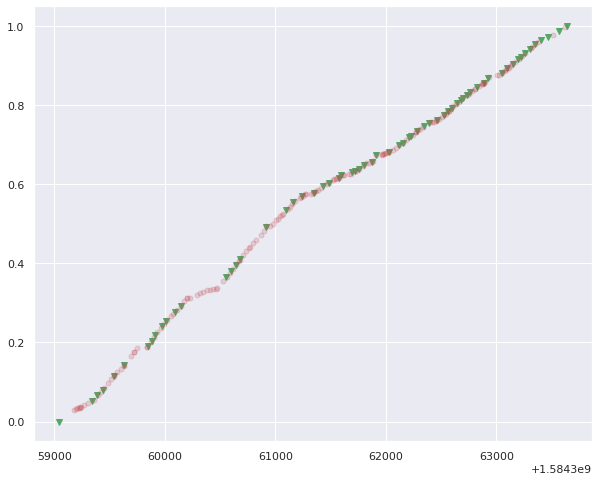

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Convert column name ARRIVETIMETRIPS03
Predic for bus 53N4917
There are 4 trips: TRIPS00, TRIPS01, TRIPS02, TRIPS03
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


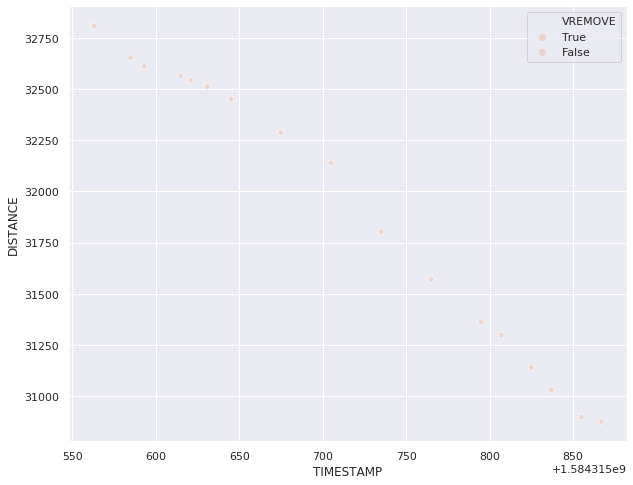

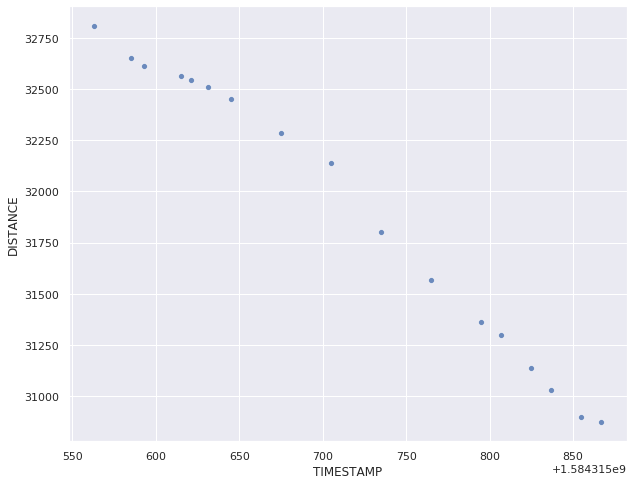

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 40 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


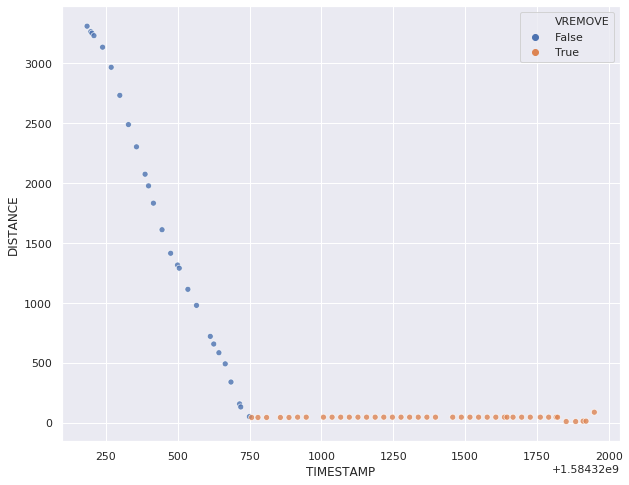

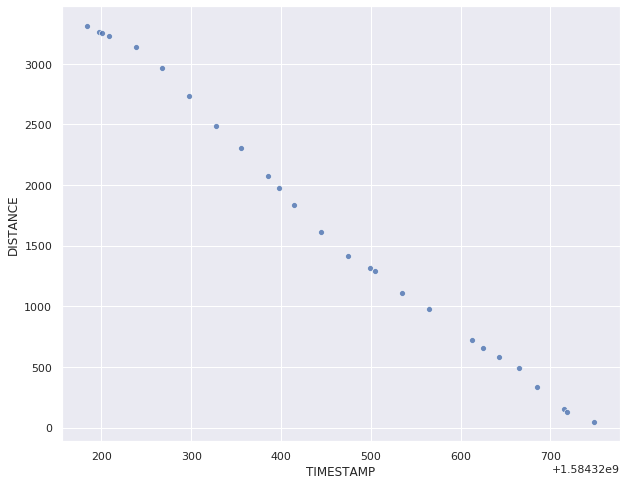

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


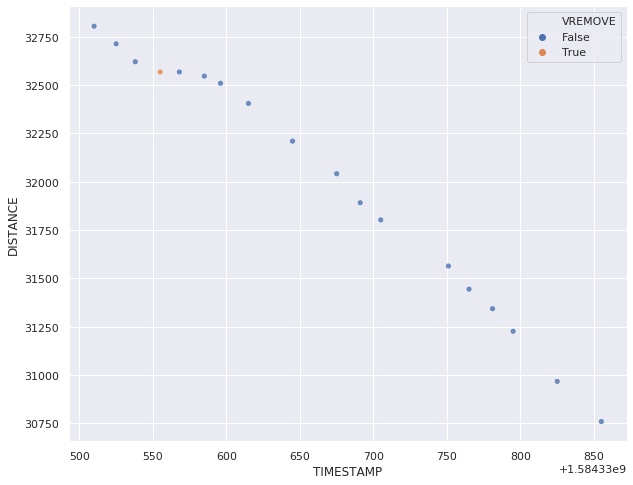

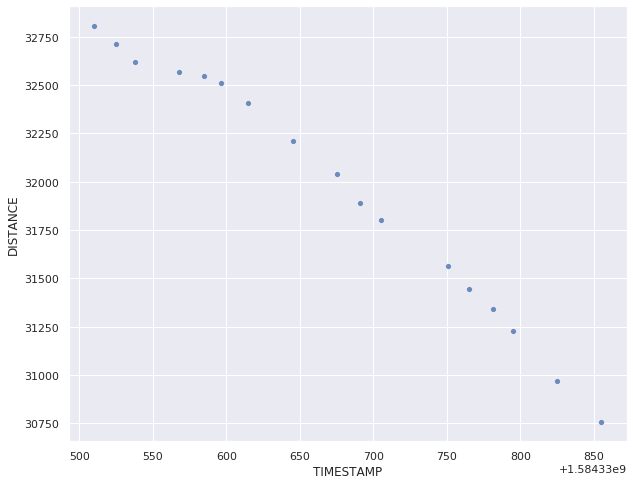

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 67 outlier.
Detected 0 outlier.
There is no outliers remain!


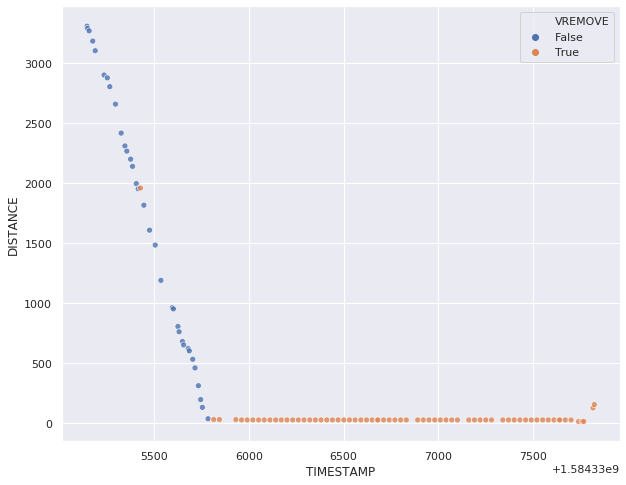

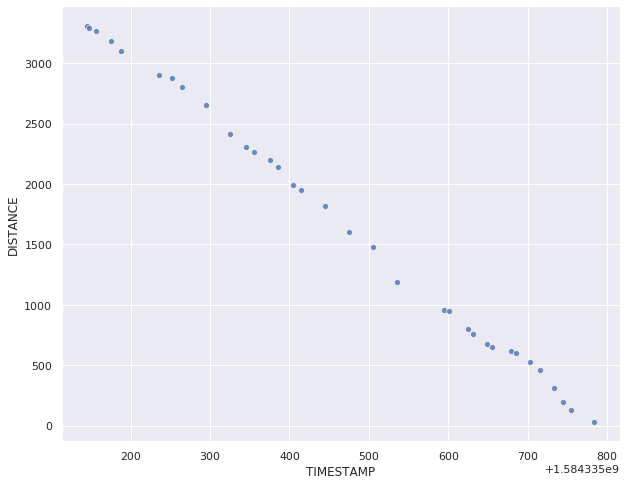

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


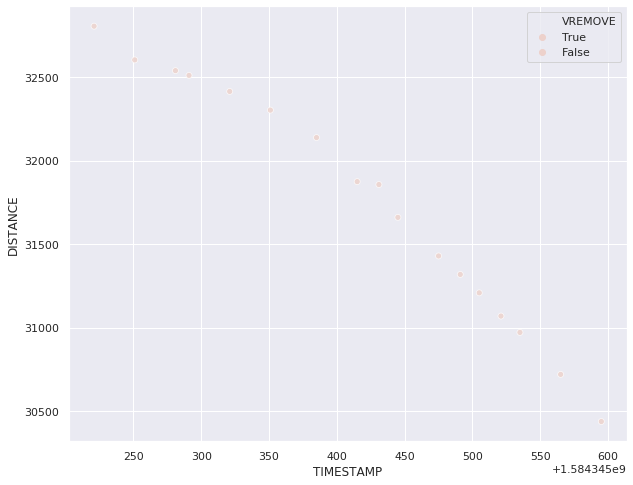

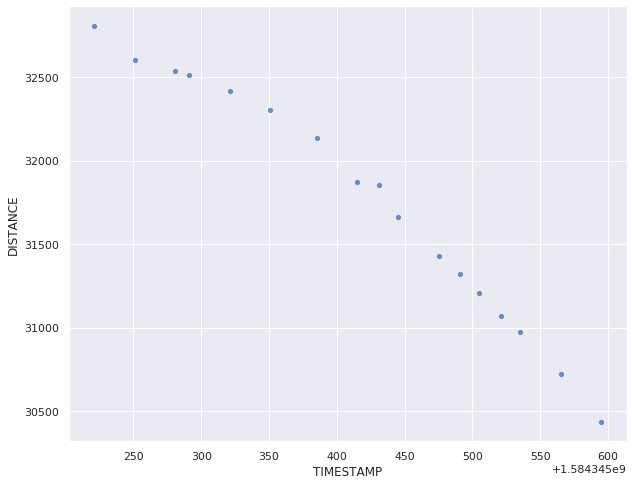

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 80 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


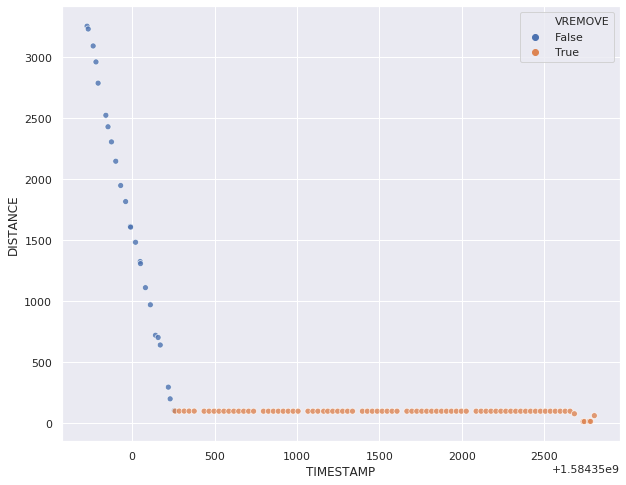

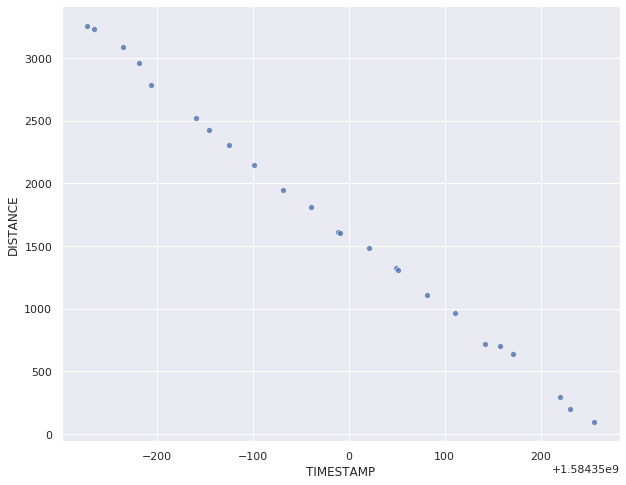

Remove outliers for trips: TRIPS03
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


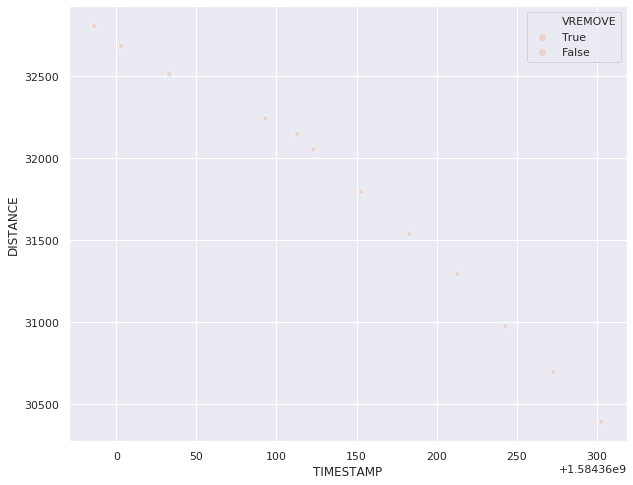

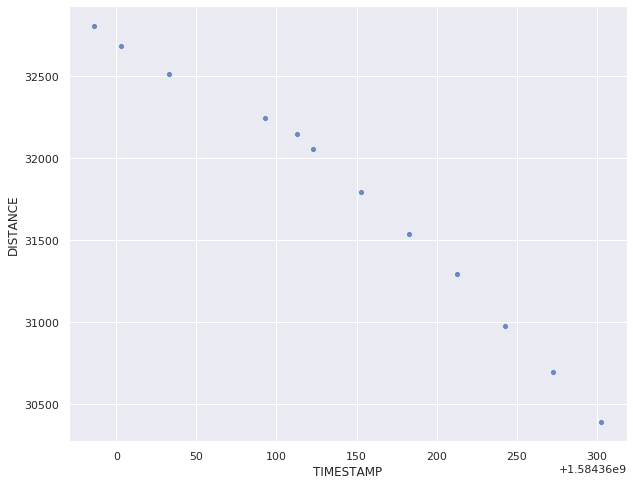

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 8 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


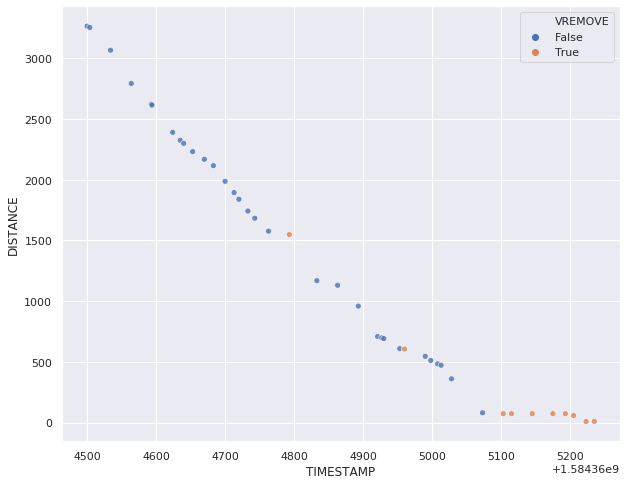

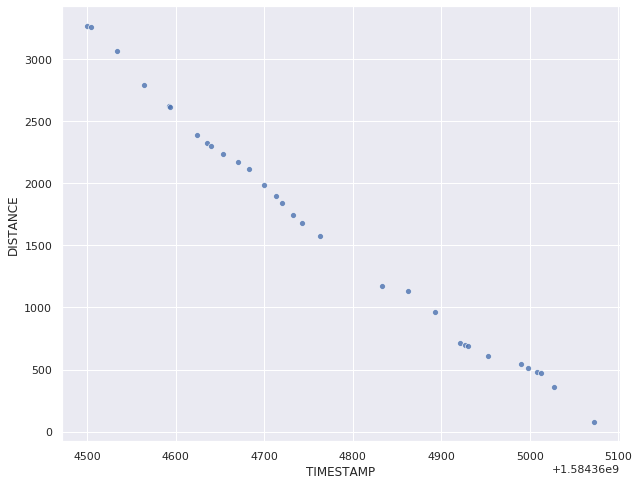

Predict for trips TRIPS00
There is no decrease distance


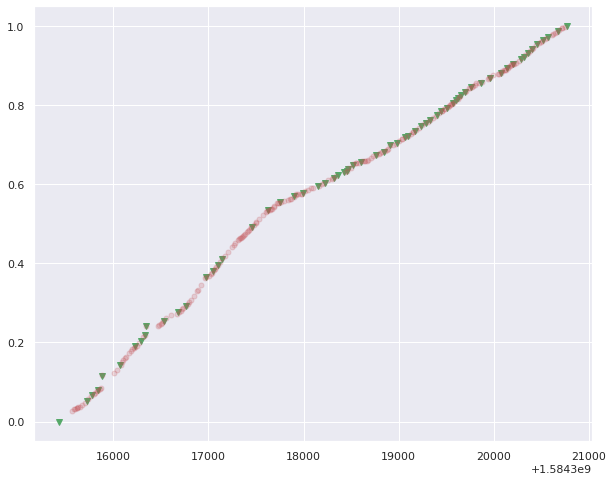

Predict for trips TRIPS01
There is no decrease distance


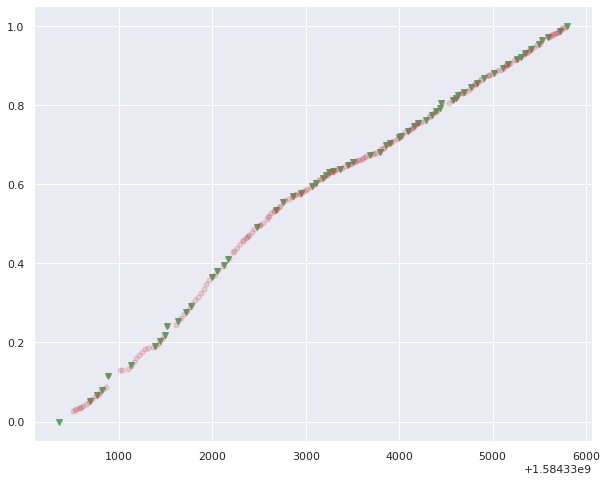

Predict for trips TRIPS02
There is no decrease distance


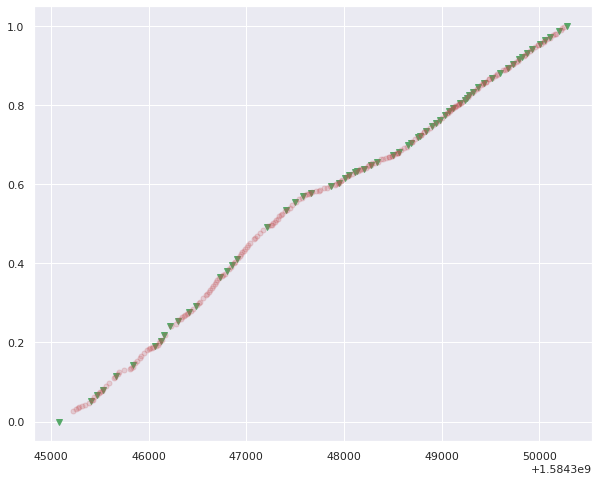

Predict for trips TRIPS03
There is no decrease distance


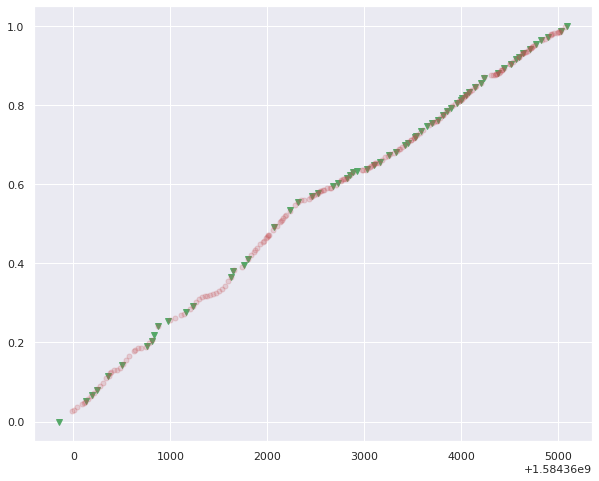

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Convert column name ARRIVETIMETRIPS03
Predic for bus 51B28892
There are 3 trips: TRIPS00, TRIPS01, TRIPS02
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 5 outlier.
Detected 0 outlier.
There is no outliers remain!


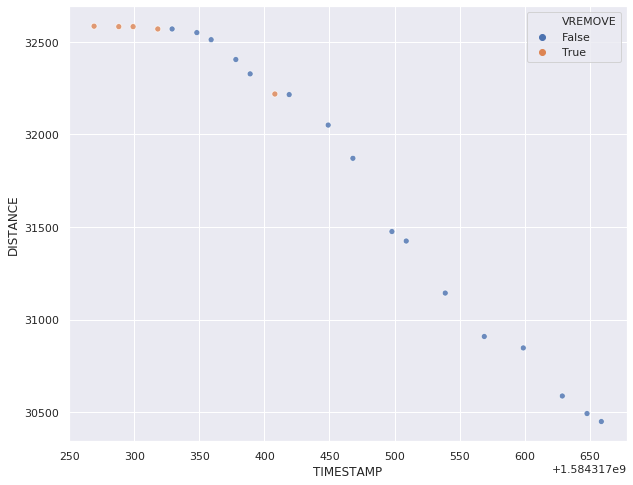

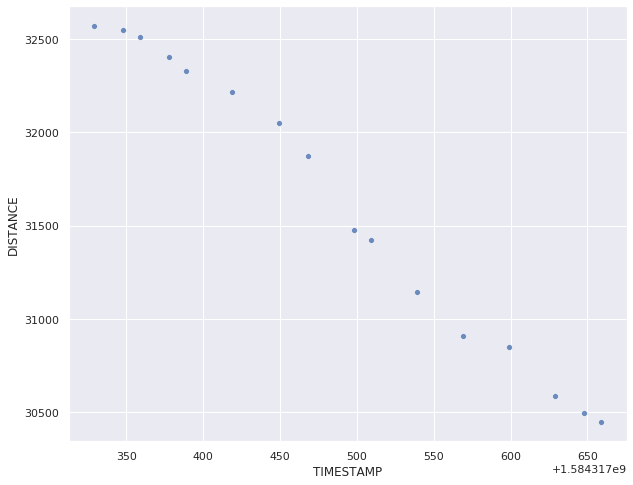

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 62 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


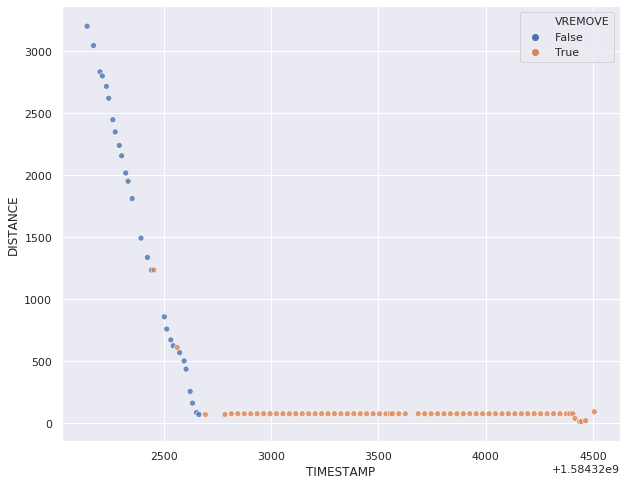

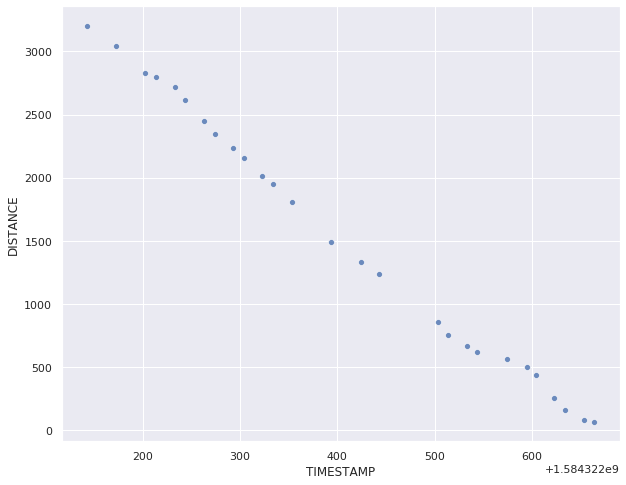

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 2 outlier.
Detected 0 outlier.
There is no outliers remain!


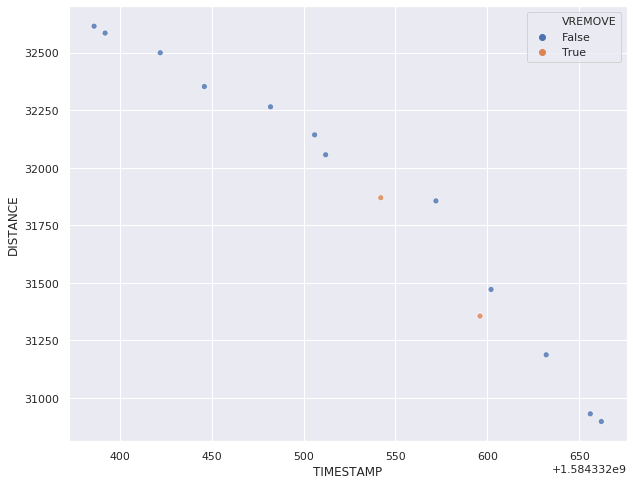

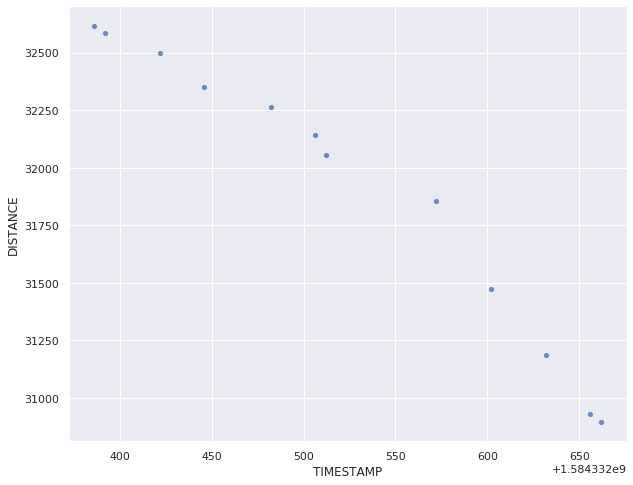

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 112 outlier.
Detected 0 outlier.
There is no outliers remain!


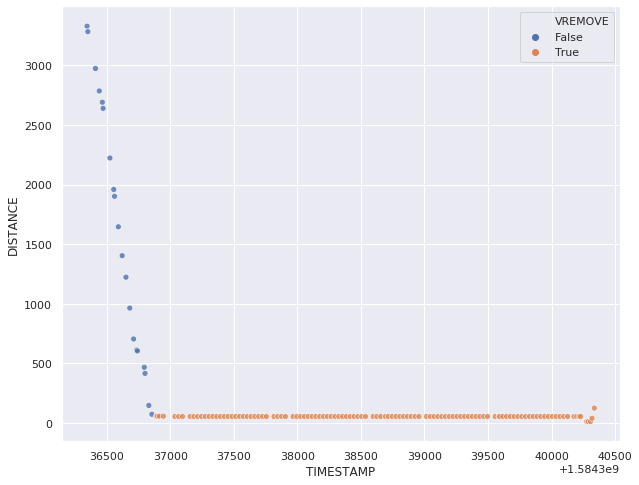

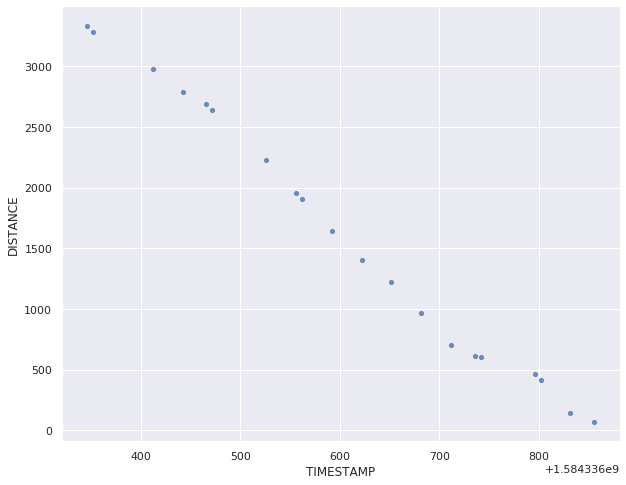

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


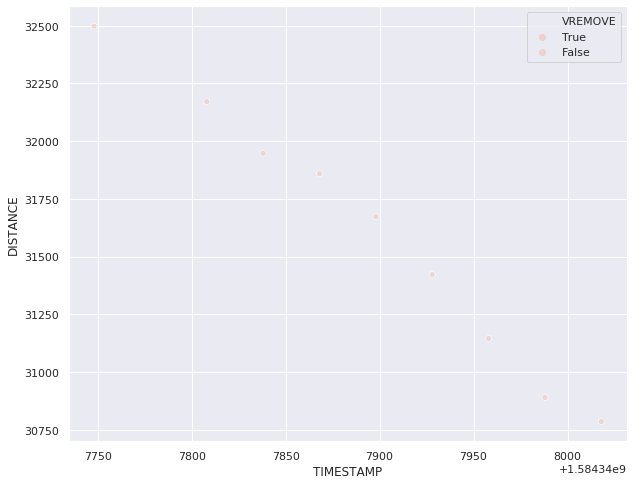

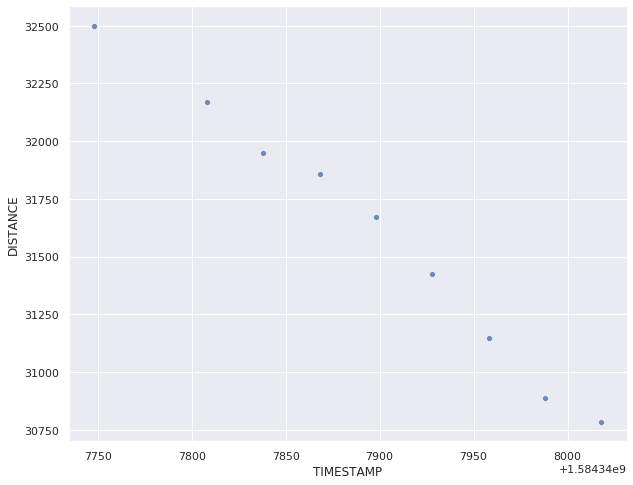

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 101 outlier.
Detected 0 outlier.
There is no outliers remain!


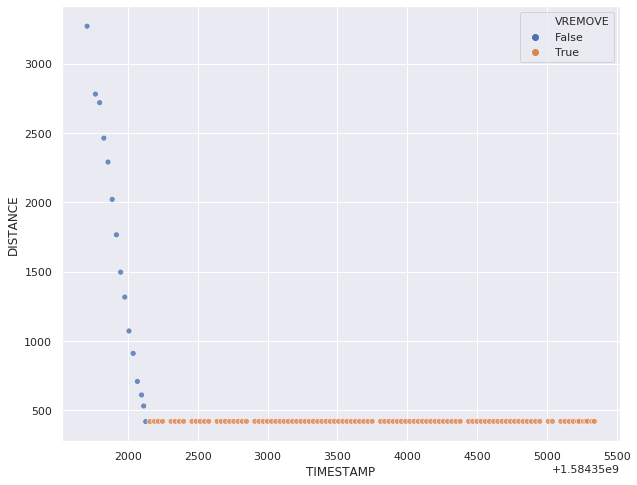

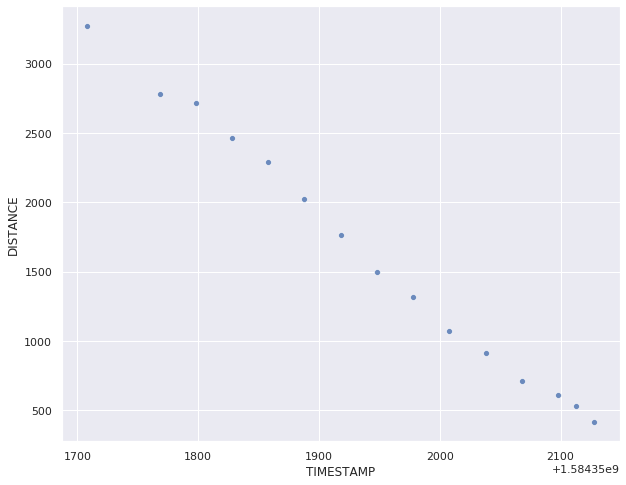

Predict for trips TRIPS00
There is no decrease distance


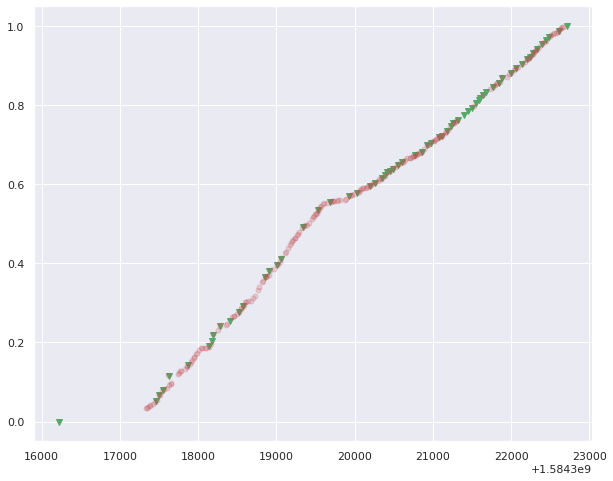

Predict for trips TRIPS01
There is no decrease distance


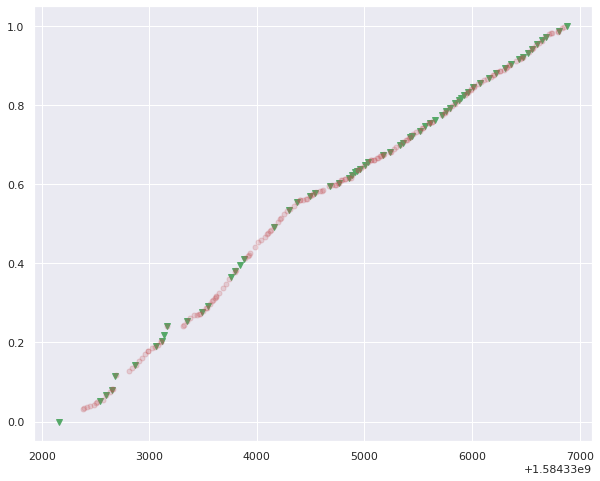

Predict for trips TRIPS02
There is no decrease distance


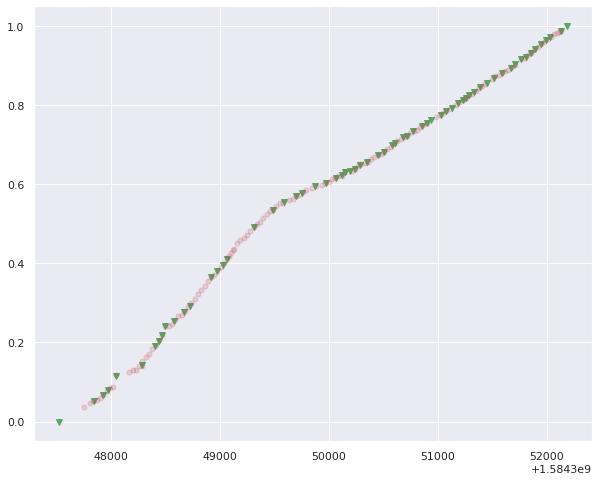

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Predic for bus 51B31233
There are 3 trips: TRIPS00, TRIPS01, TRIPS02
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


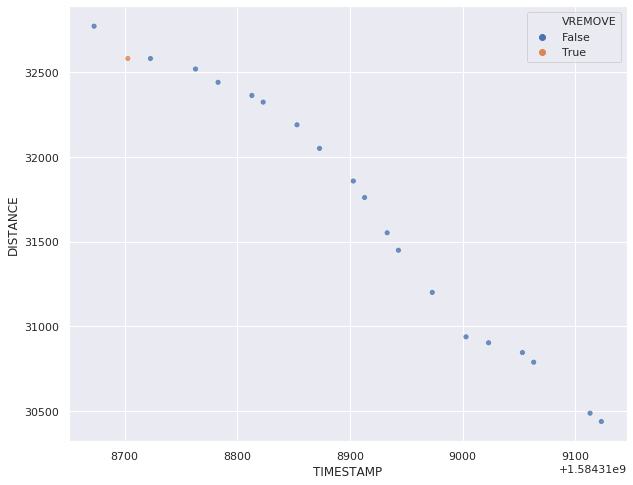

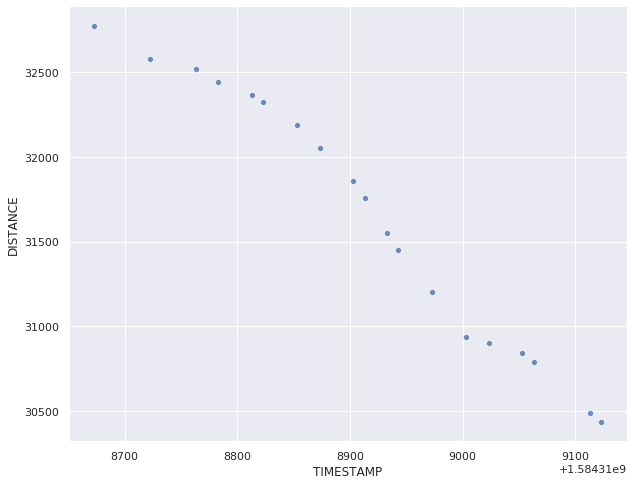

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 40 outlier.
Detected 2 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


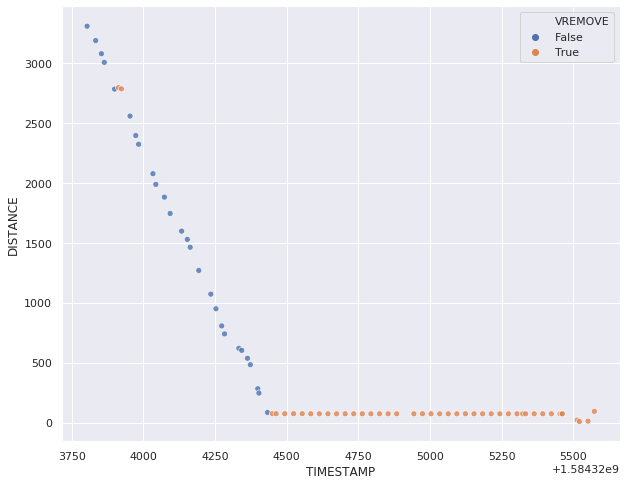

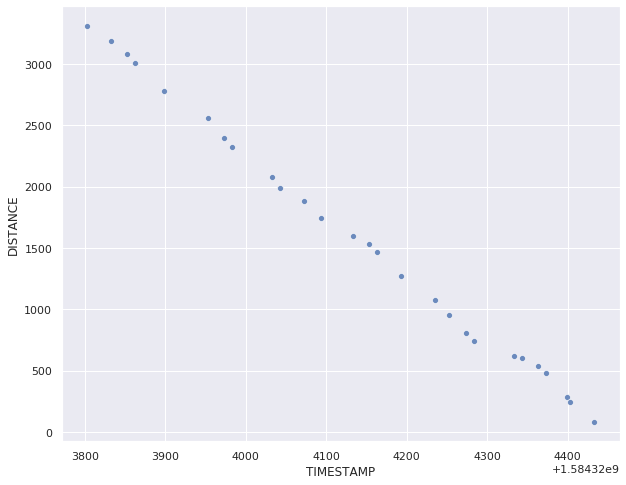

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


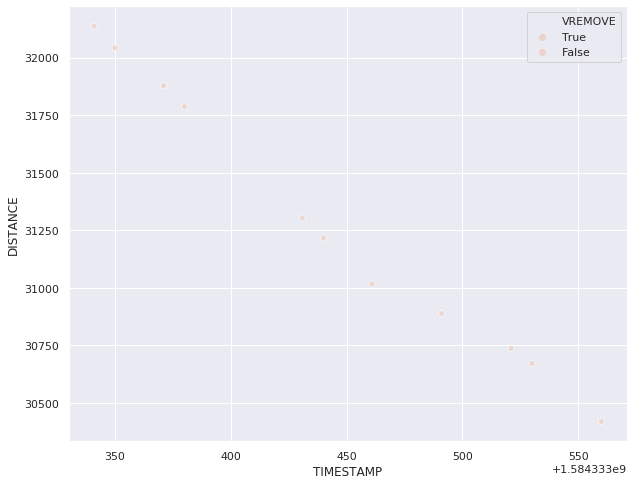

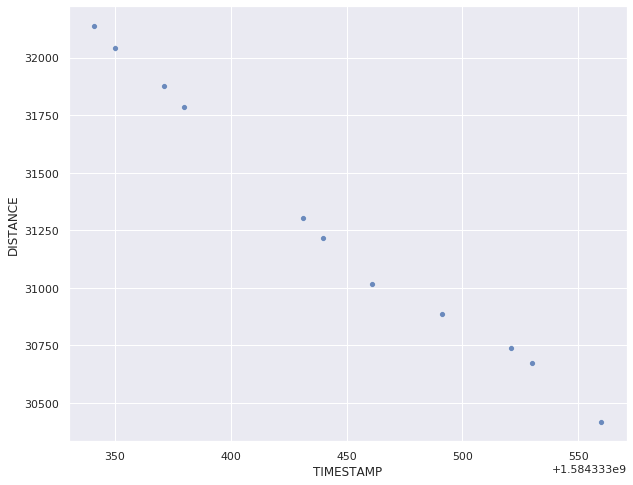

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 116 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


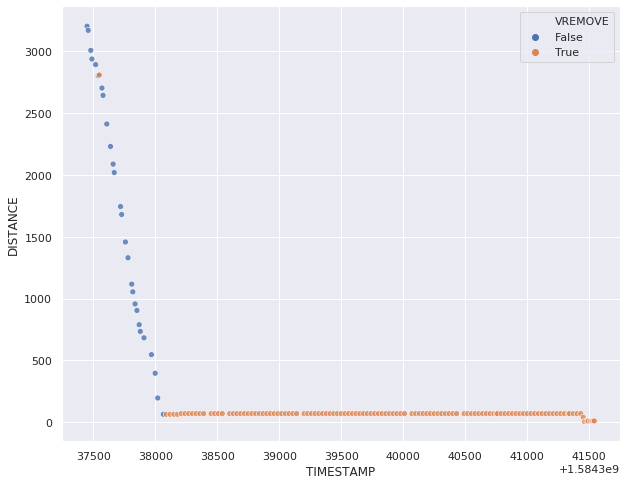

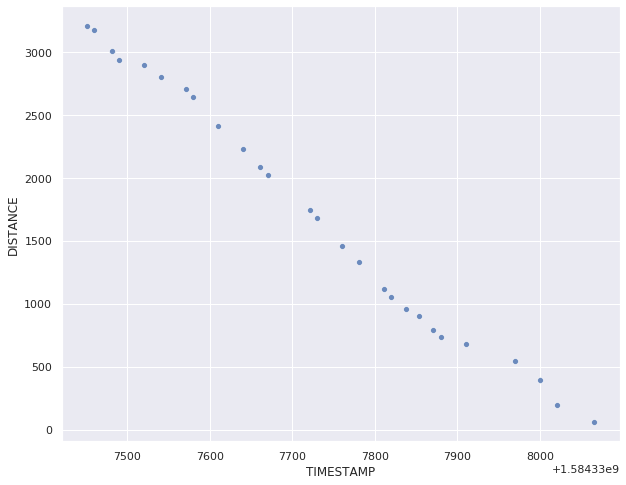

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


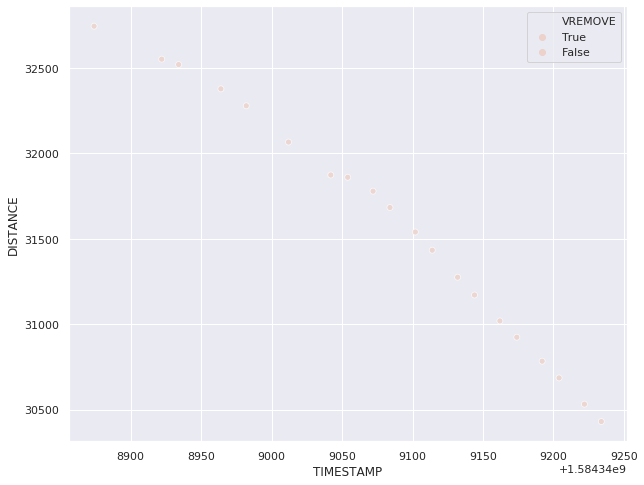

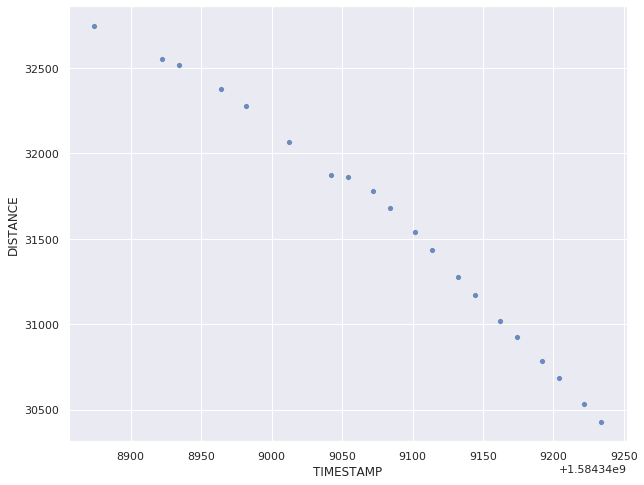

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 87 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


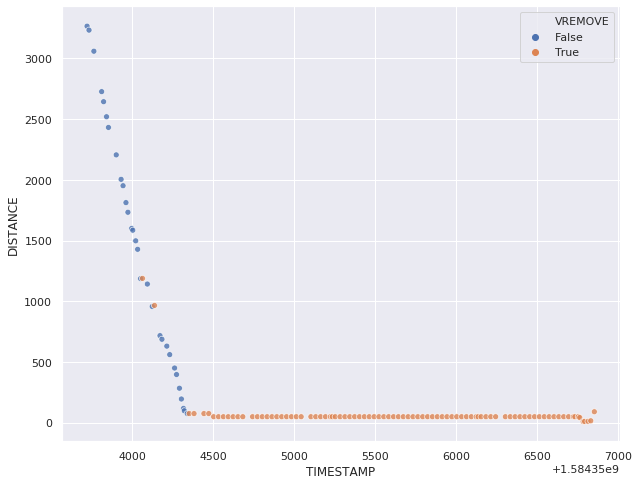

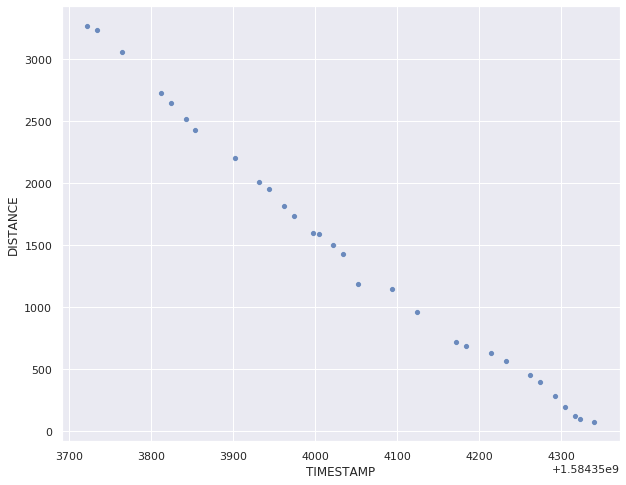

Predict for trips TRIPS00
There is no decrease distance


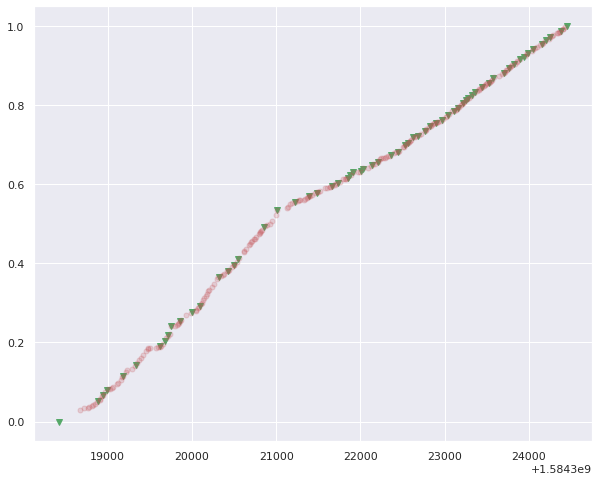

Predict for trips TRIPS01
There is no decrease distance


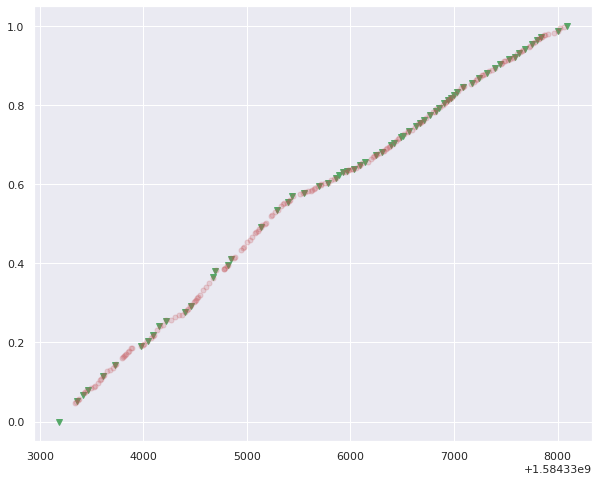

Predict for trips TRIPS02
There is no decrease distance


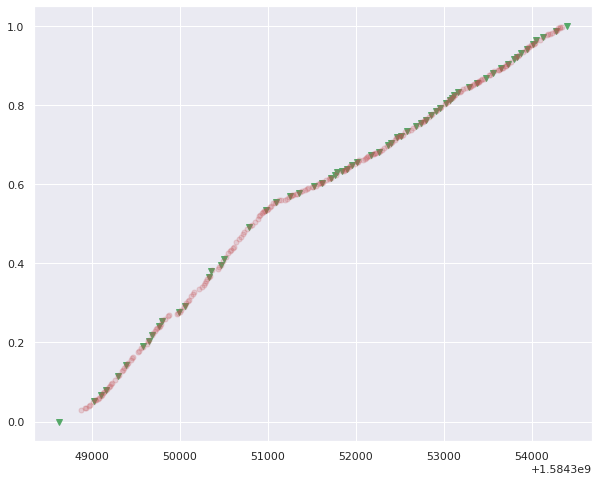

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Predic for bus 53N5049
There are 3 trips: TRIPS00, TRIPS01, TRIPS02
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 3 outlier.
Detected 0 outlier.
There is no outliers remain!


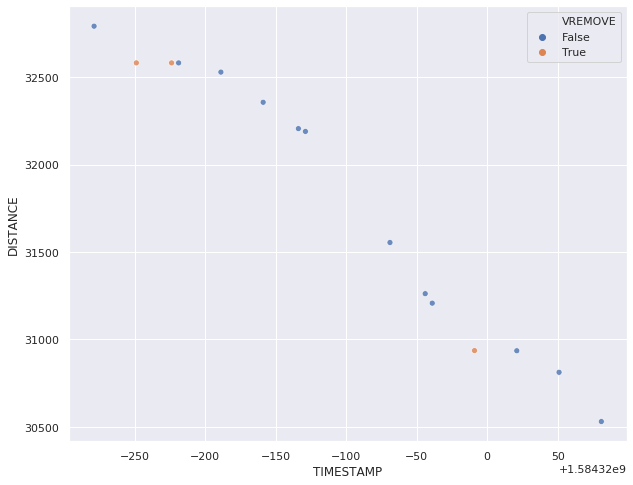

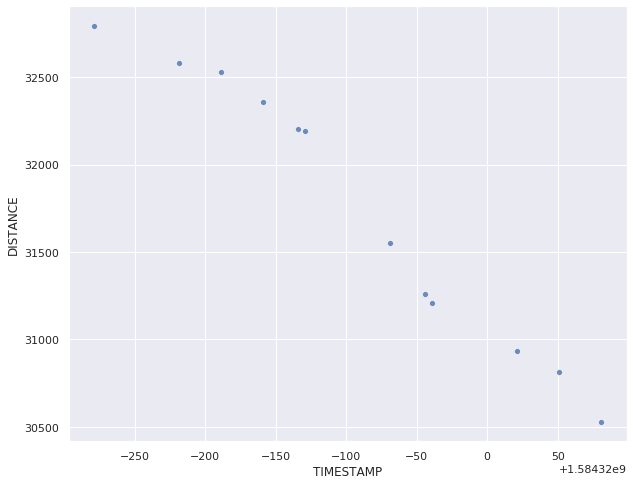

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 65 outlier.
Detected 3 outlier.
Detected 0 outlier.
There is no outliers remain!


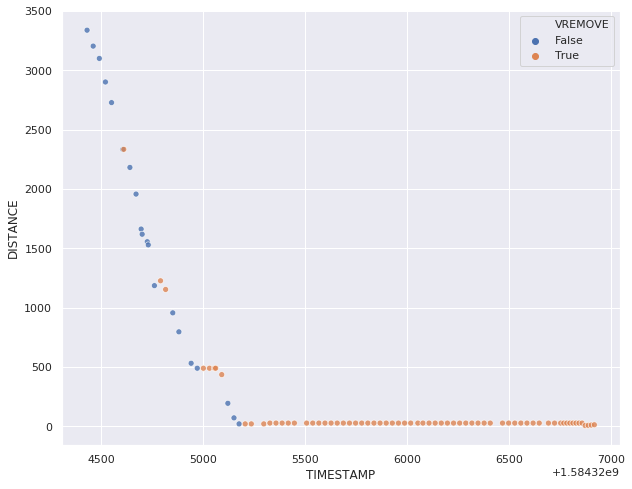

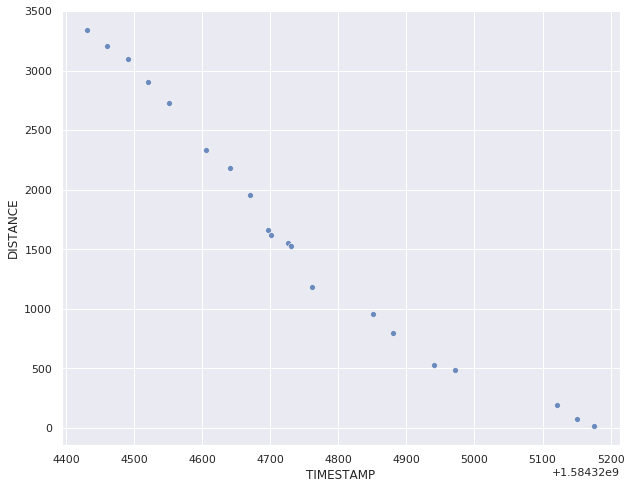

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


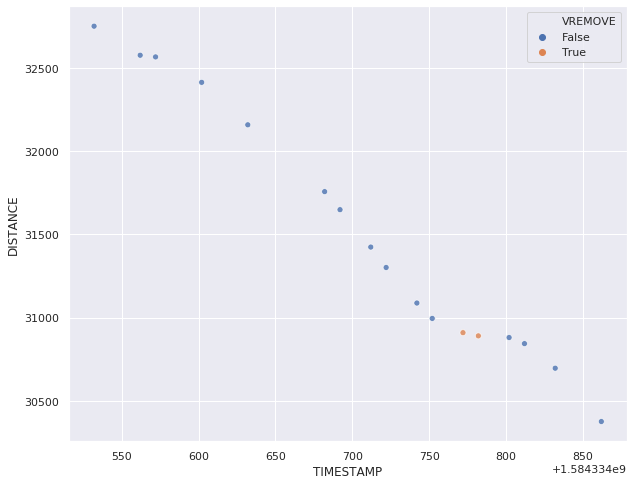

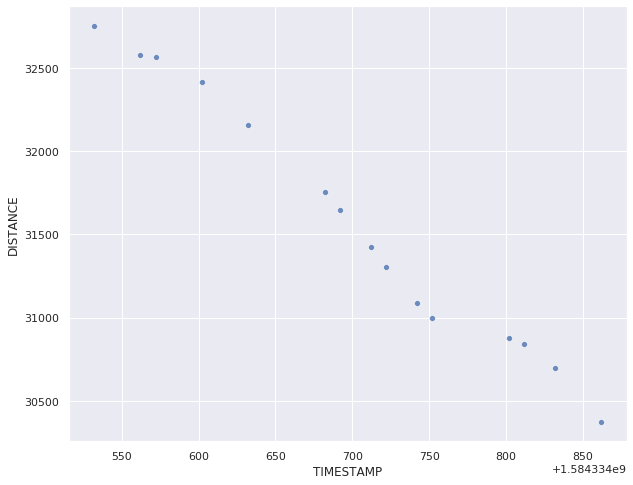

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 129 outlier.
Detected 2 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


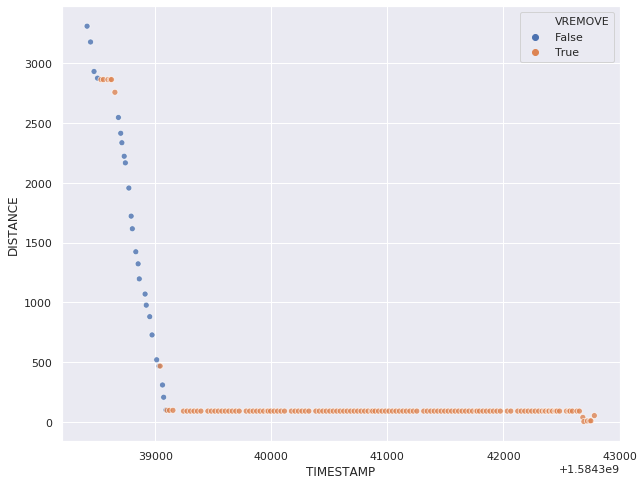

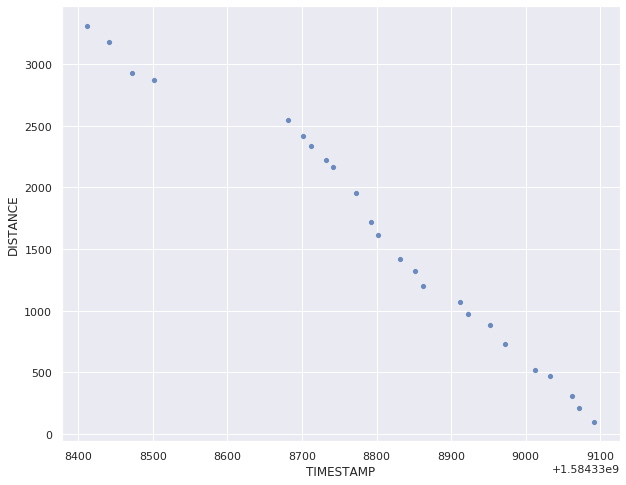

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 3 outlier.
Detected 0 outlier.
There is no outliers remain!


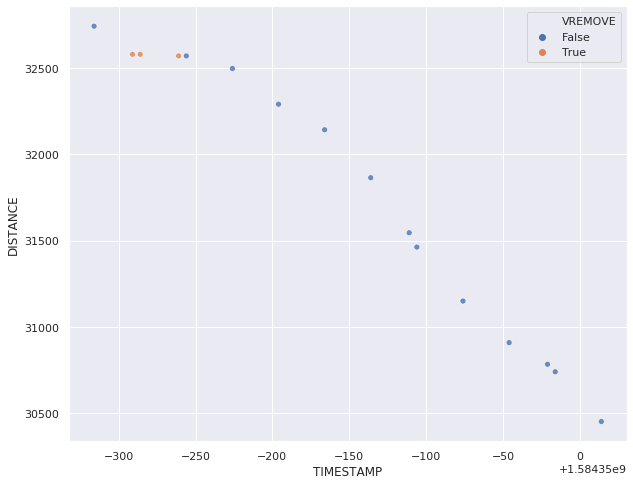

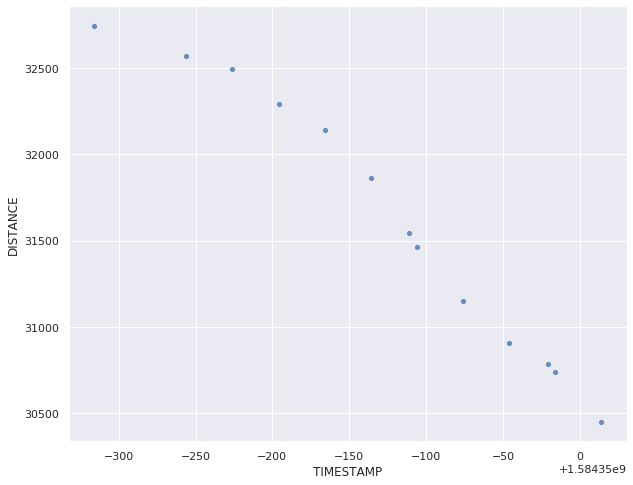

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 107 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


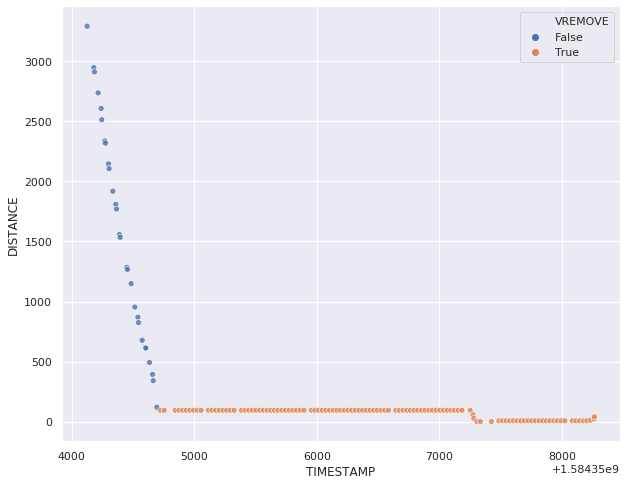

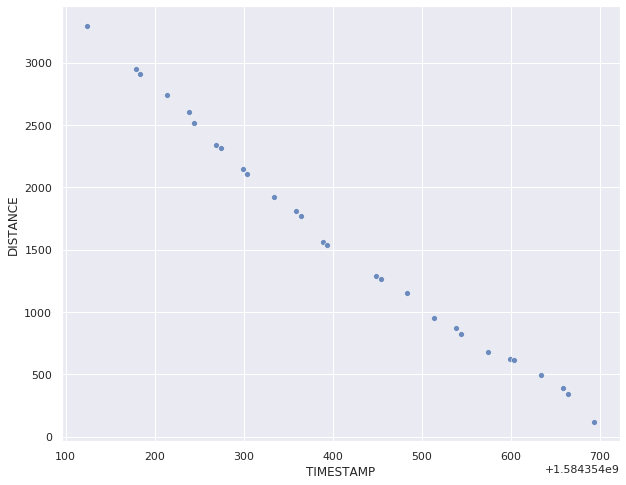

Predict for trips TRIPS00
There is no decrease distance


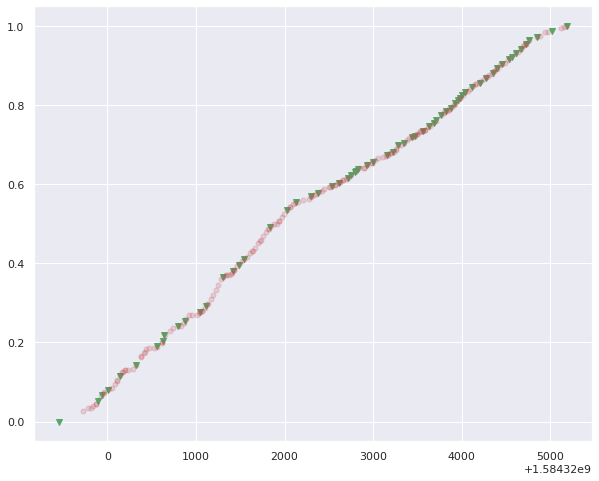

Predict for trips TRIPS01
There is no decrease distance


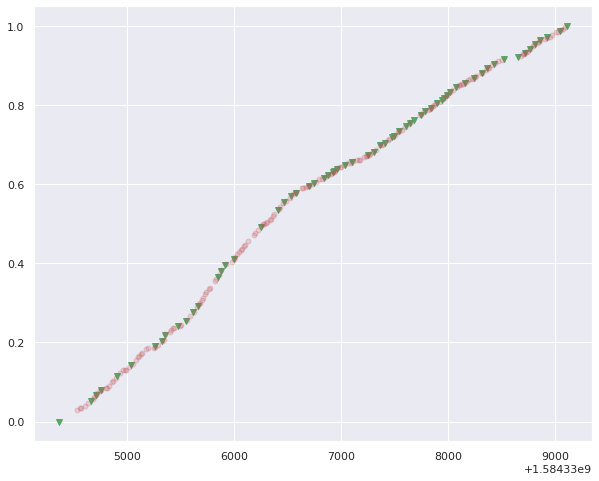

Predict for trips TRIPS02
There is no decrease distance


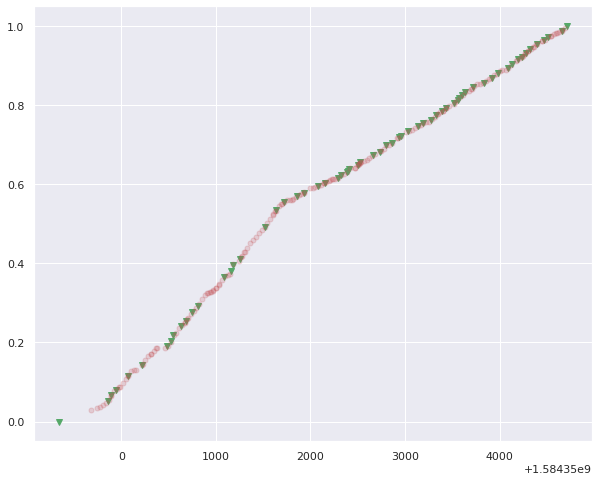

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Predic for bus 51B26267
There are 3 trips: TRIPS00, TRIPS01, TRIPS02
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 121 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


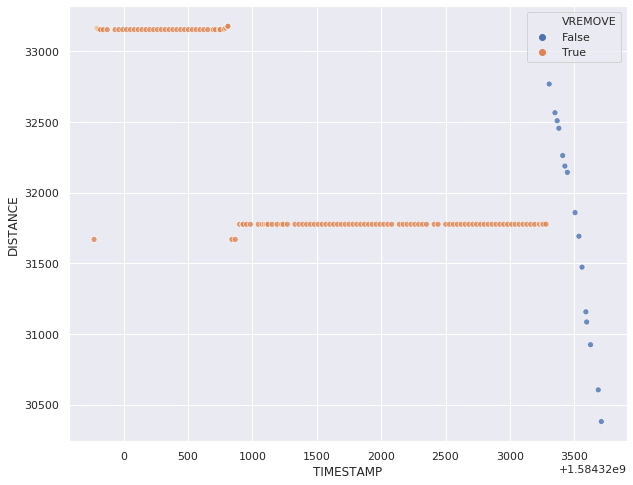

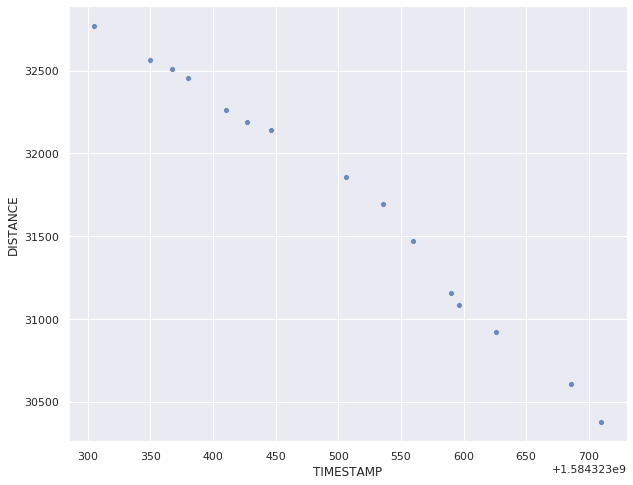

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 51 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


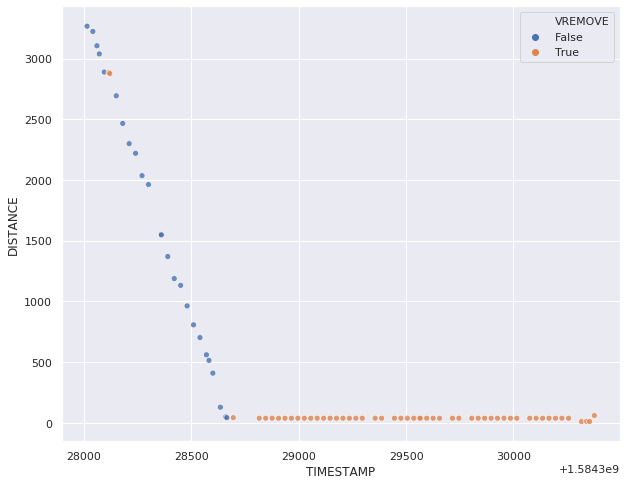

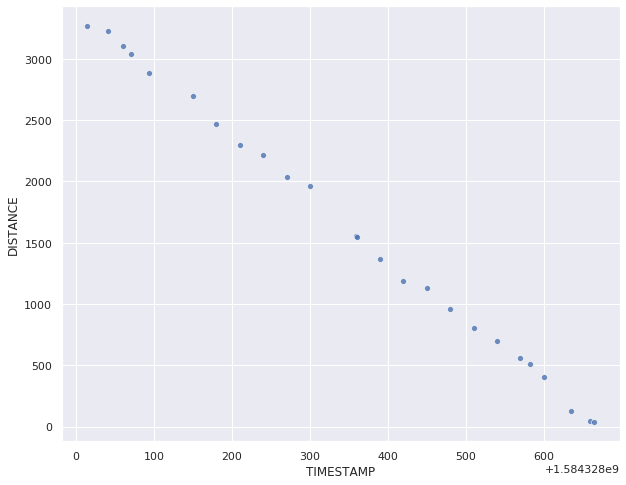

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 4 outlier.
Detected 0 outlier.
There is no outliers remain!


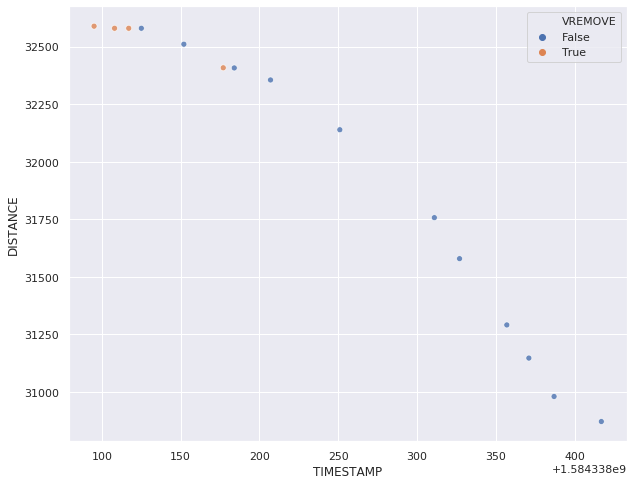

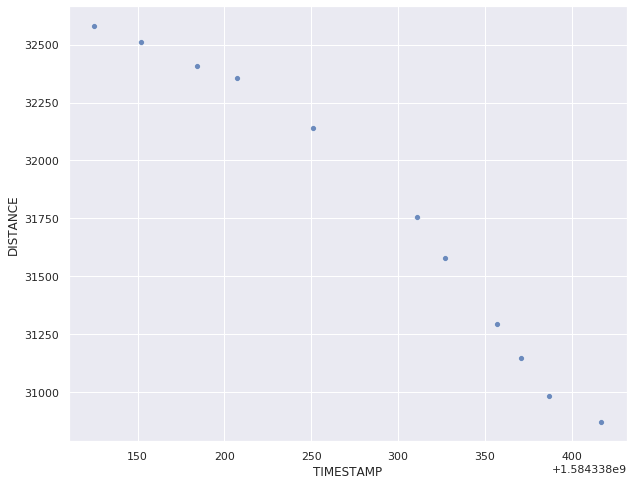

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 105 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


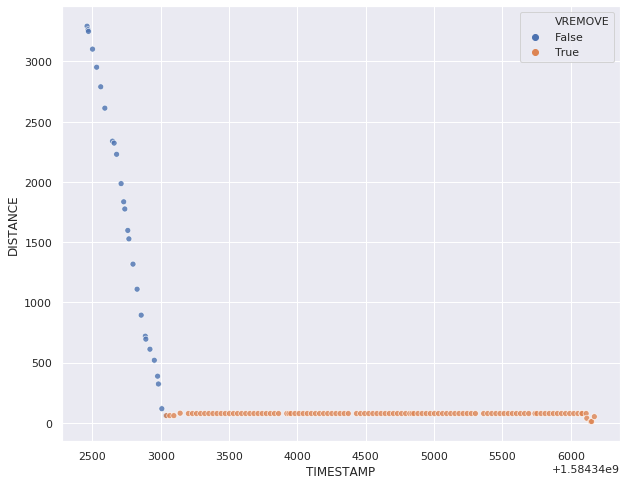

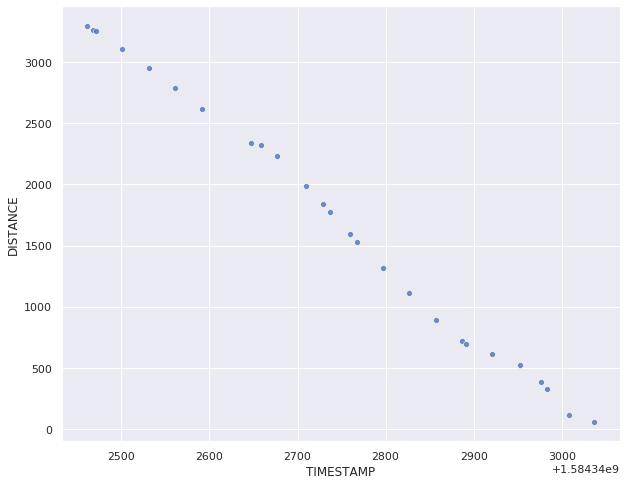

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


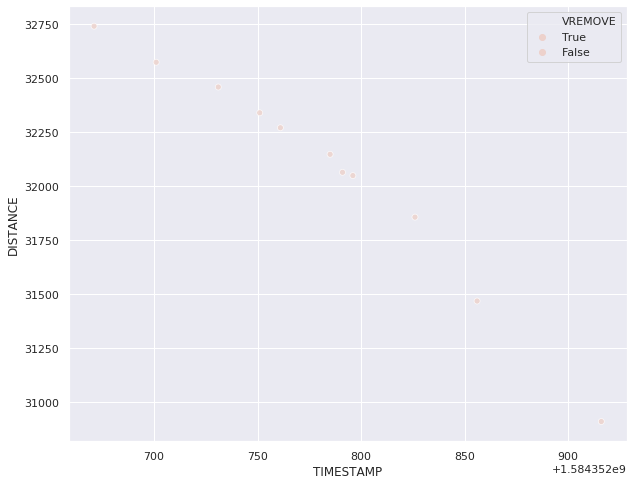

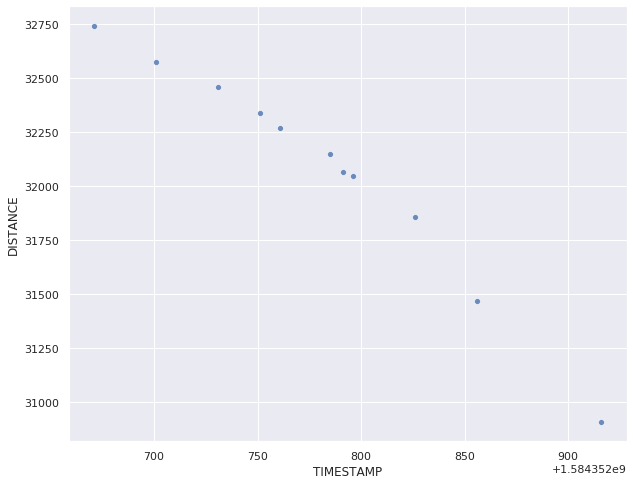

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 5 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


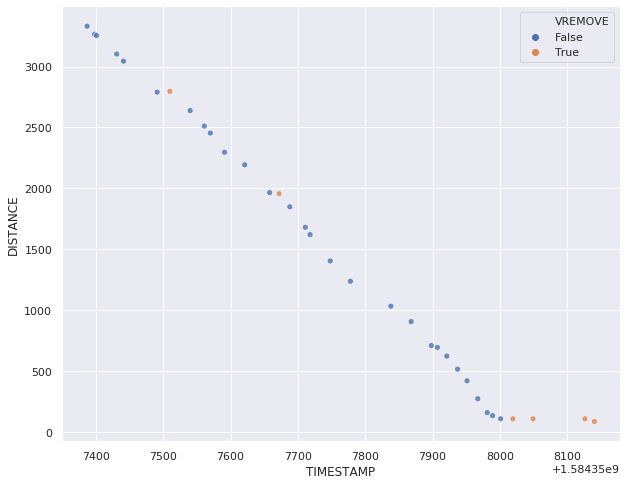

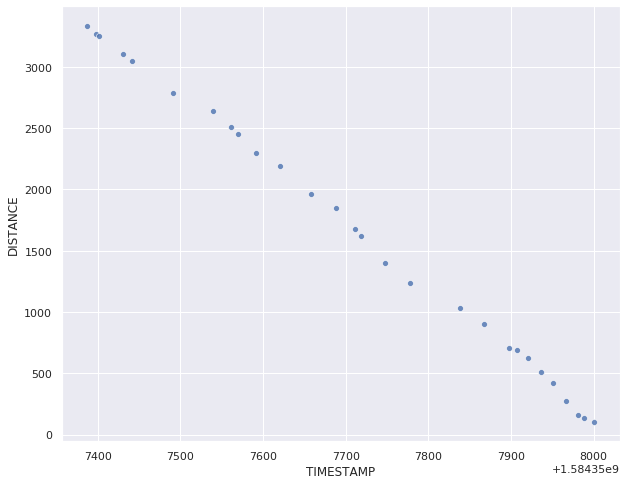

Predict for trips TRIPS00
There is no decrease distance


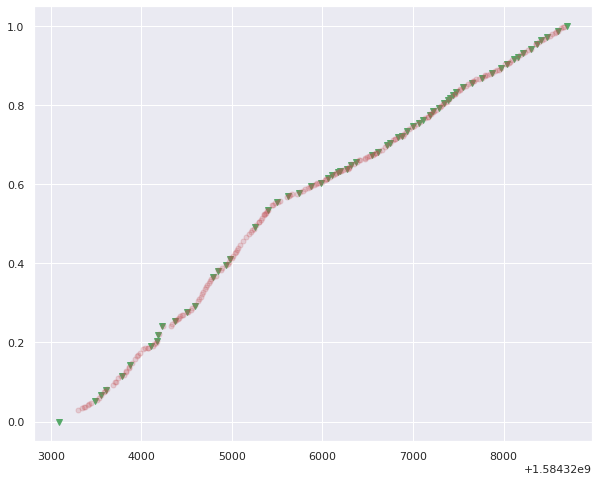

Predict for trips TRIPS01
There is no decrease distance


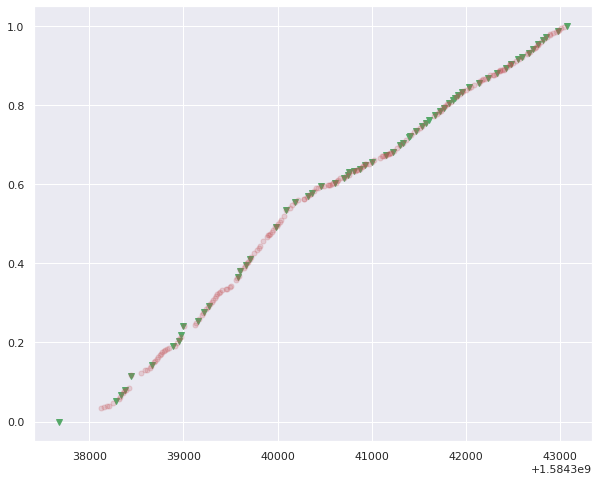

Predict for trips TRIPS02
There is no decrease distance


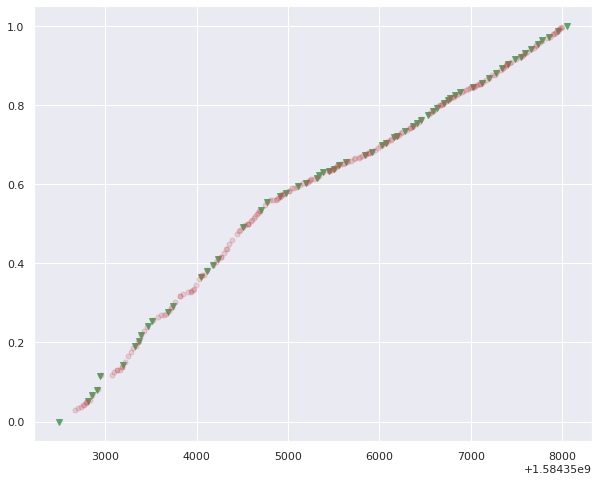

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Predic for bus 51B26345
There are 3 trips: TRIPS00, TRIPS01, TRIPS02
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


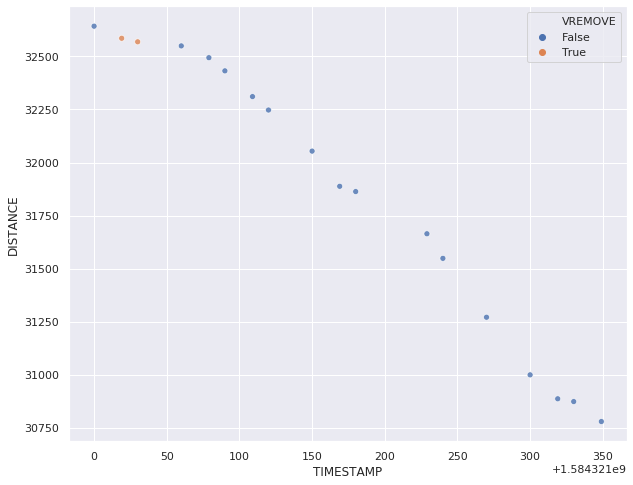

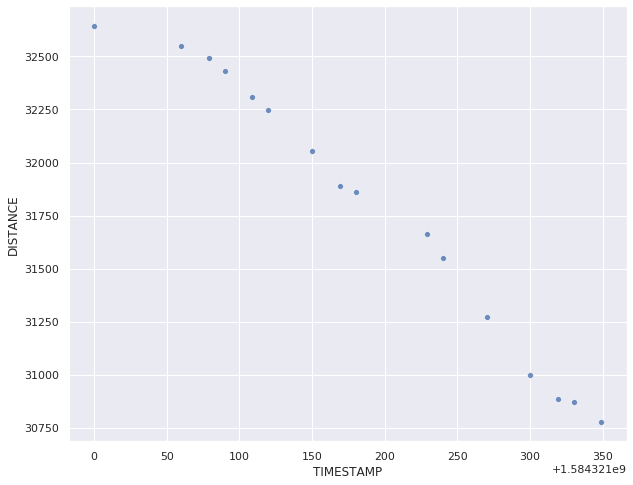

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 71 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


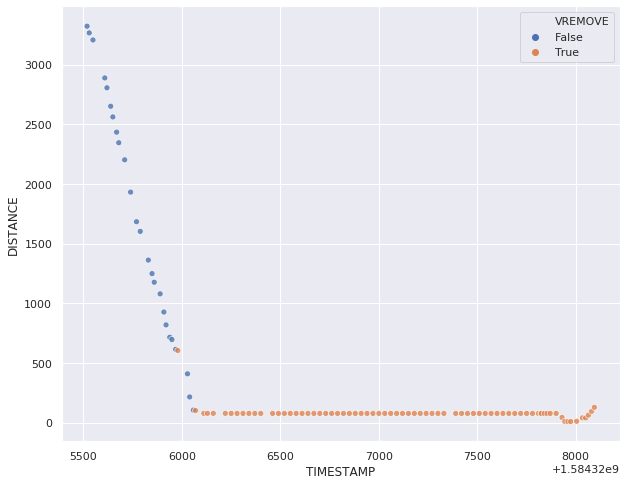

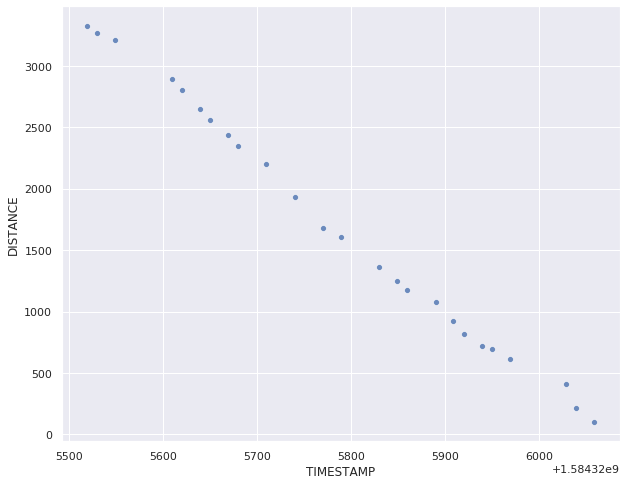

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


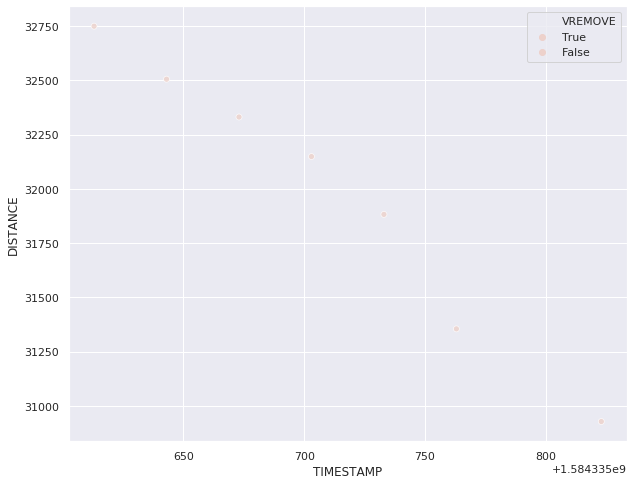

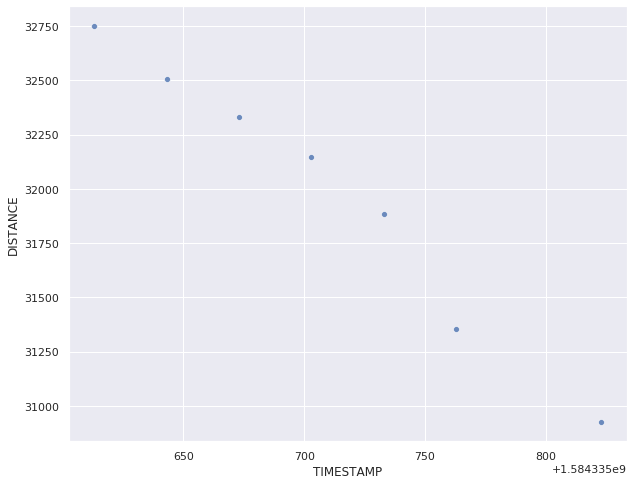

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 107 outlier.
Detected 0 outlier.
There is no outliers remain!


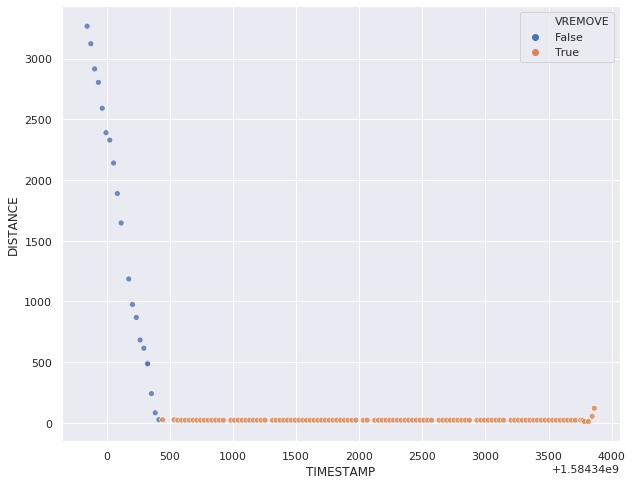

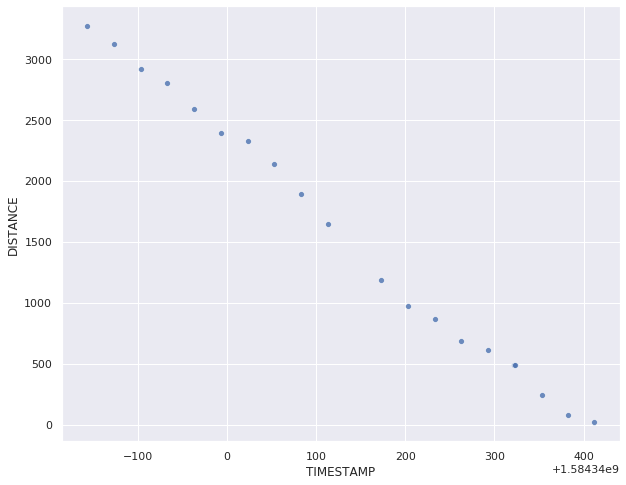

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


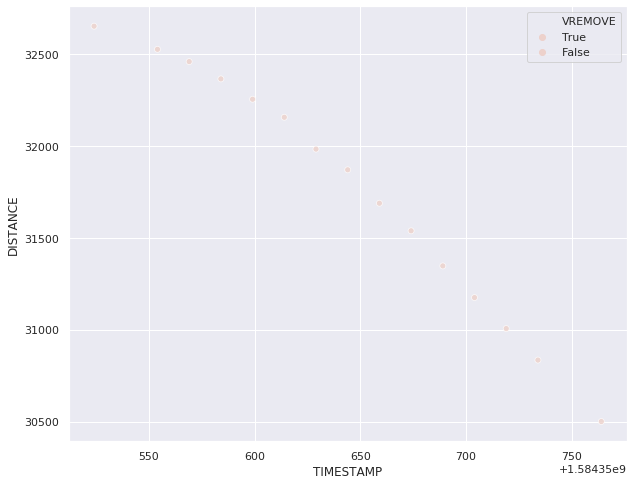

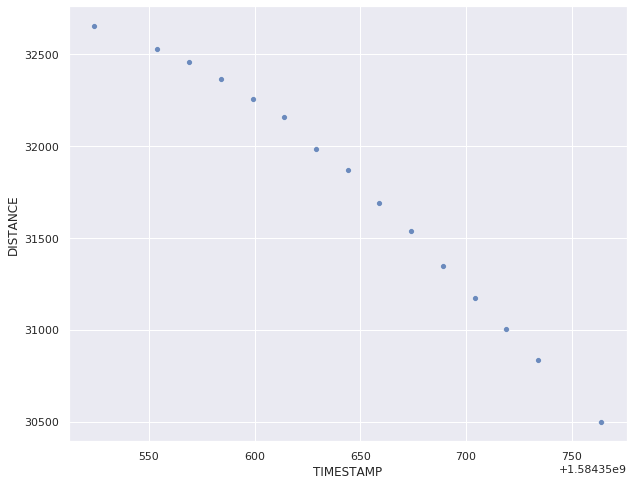

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 129 outlier.
Detected 0 outlier.
There is no outliers remain!


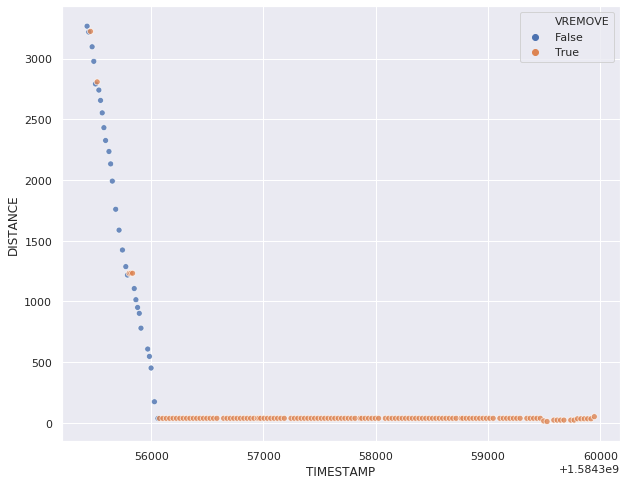

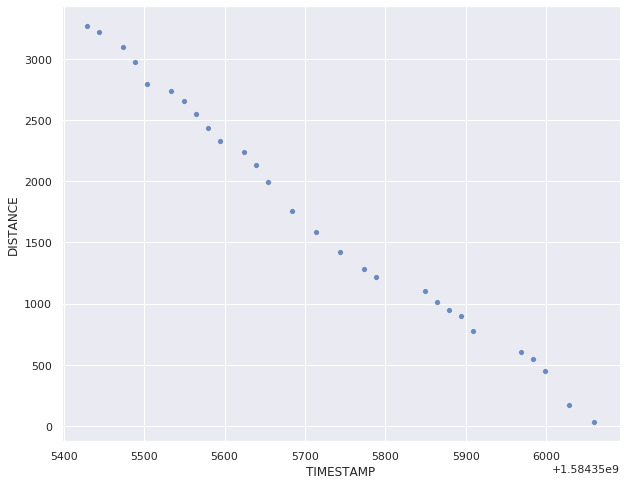

Predict for trips TRIPS00
There is no decrease distance


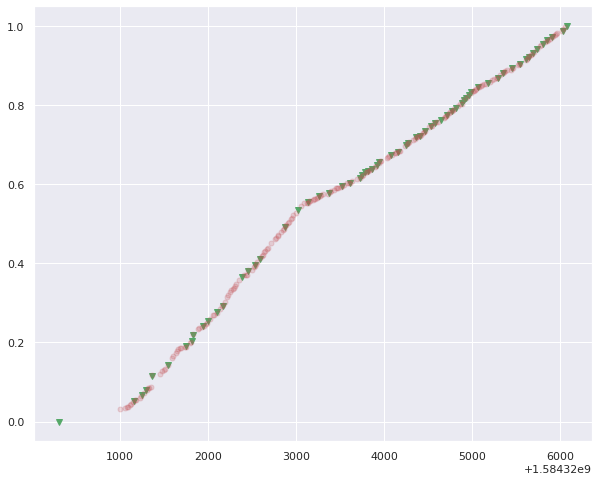

Predict for trips TRIPS01
There is no decrease distance


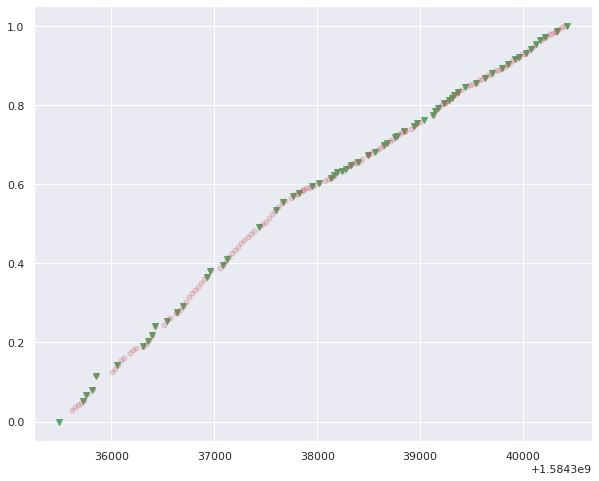

Predict for trips TRIPS02
There is no decrease distance


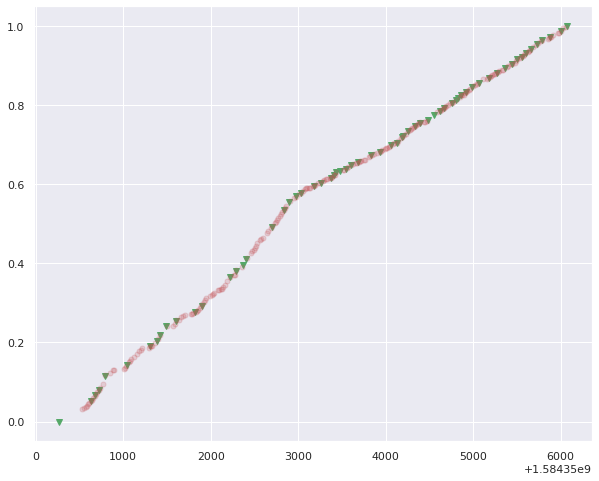

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Predic for bus 53N4967
There are 3 trips: TRIPS00, TRIPS01, TRIPS02
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


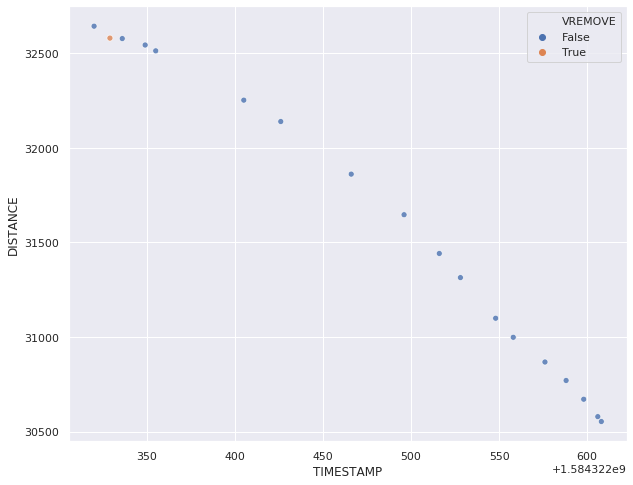

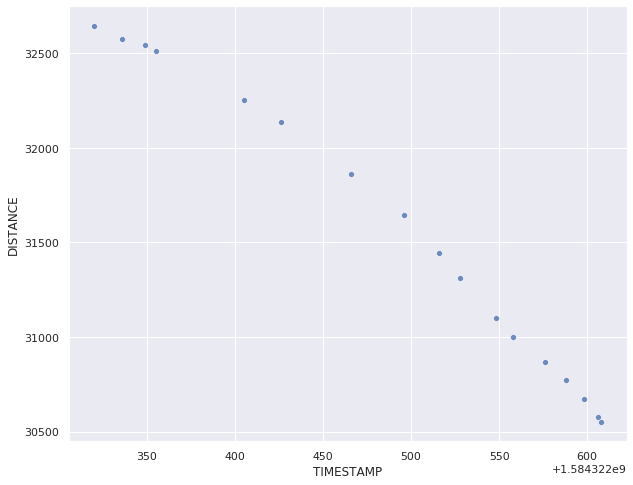

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 118 outlier.
Detected 0 outlier.
There is no outliers remain!


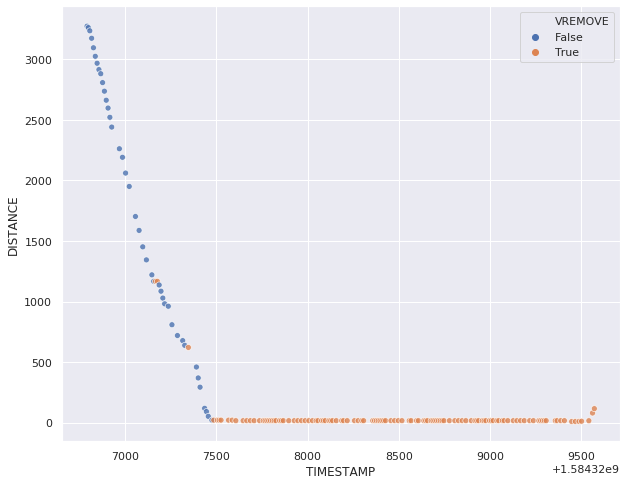

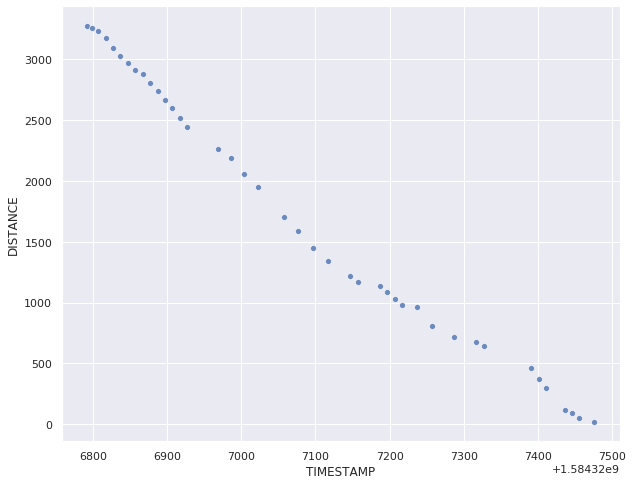

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


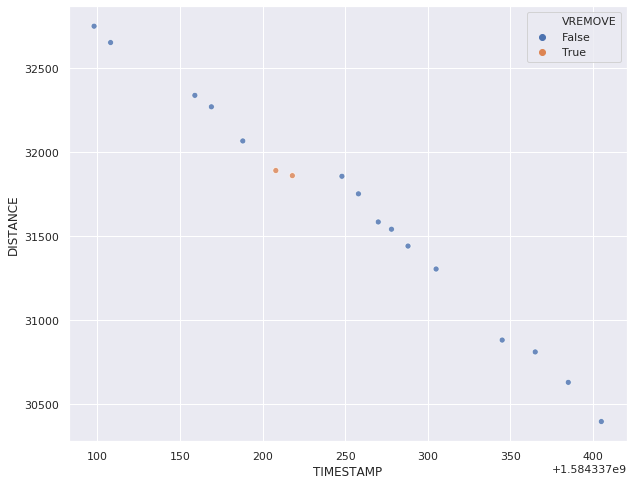

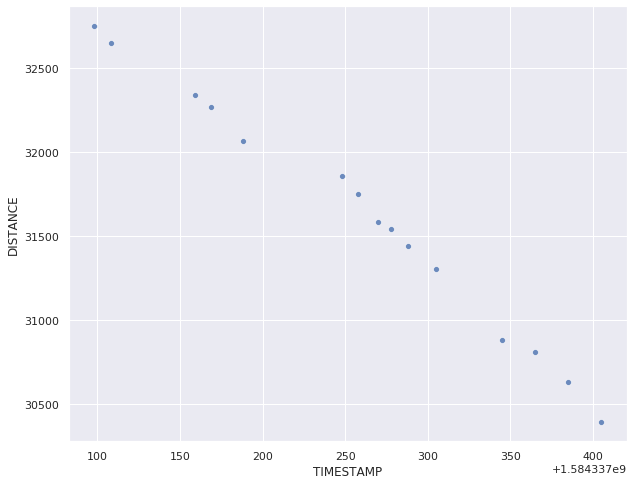

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 174 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


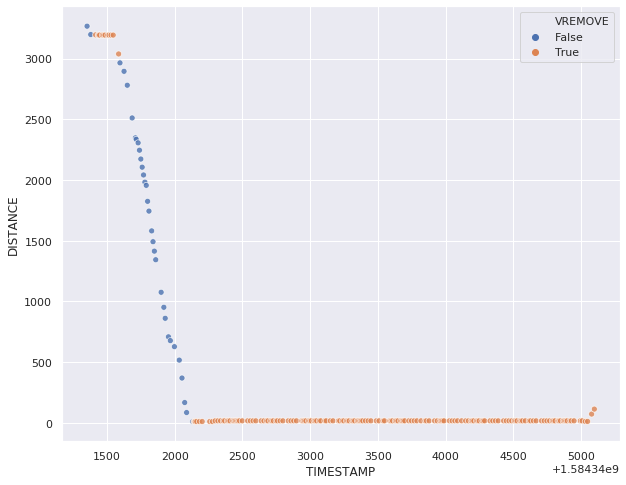

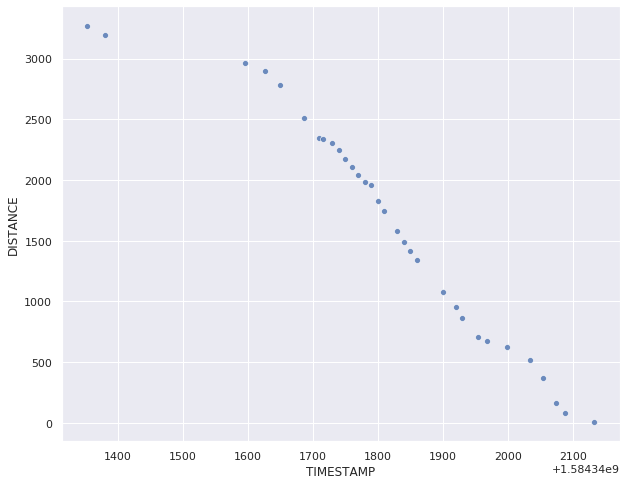

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


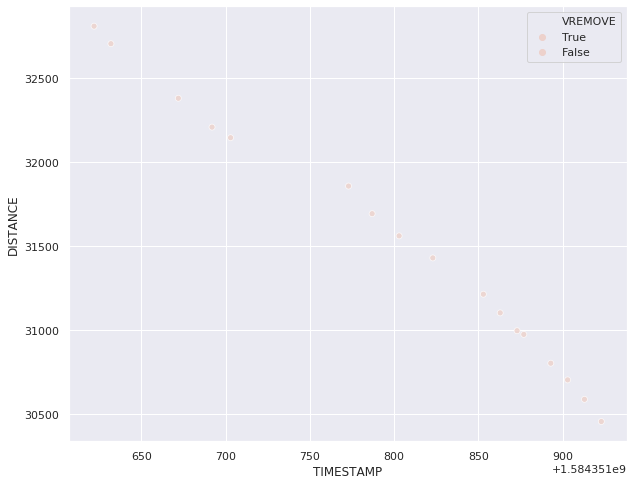

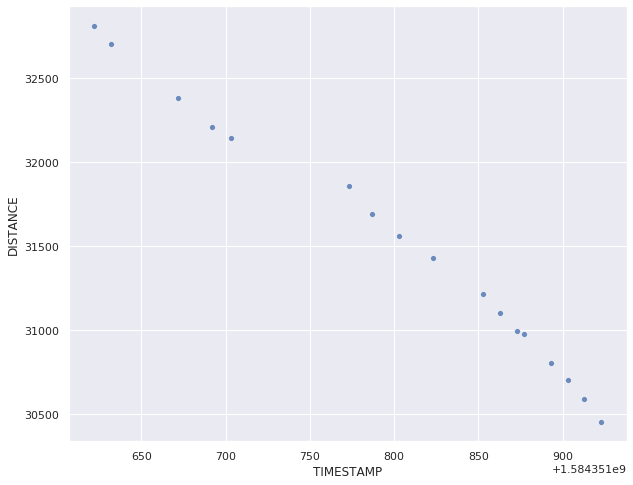

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 14 outlier.
Detected 0 outlier.
There is no outliers remain!


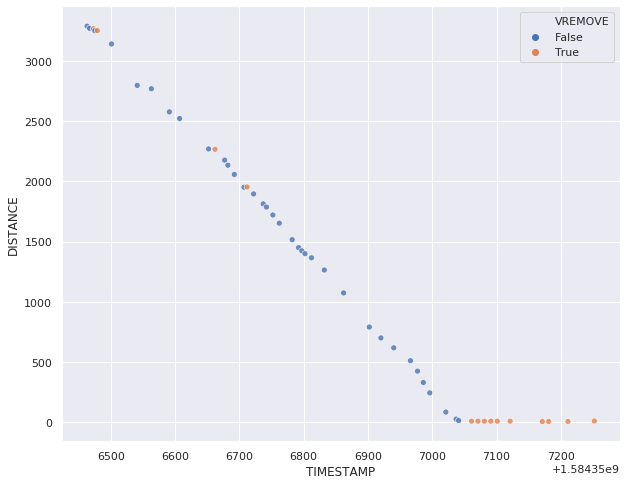

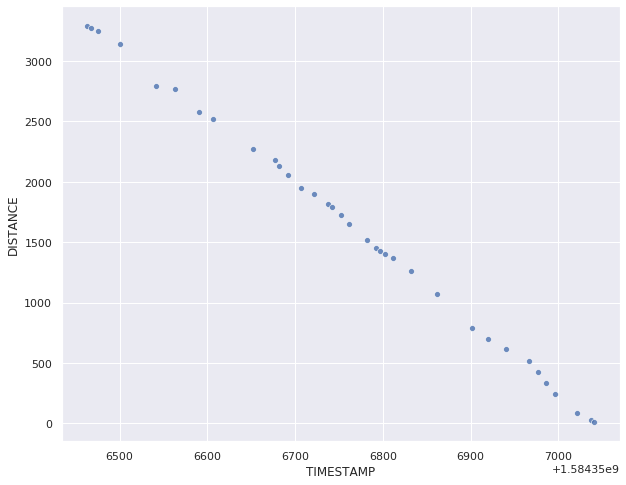

Predict for trips TRIPS00
There is no decrease distance


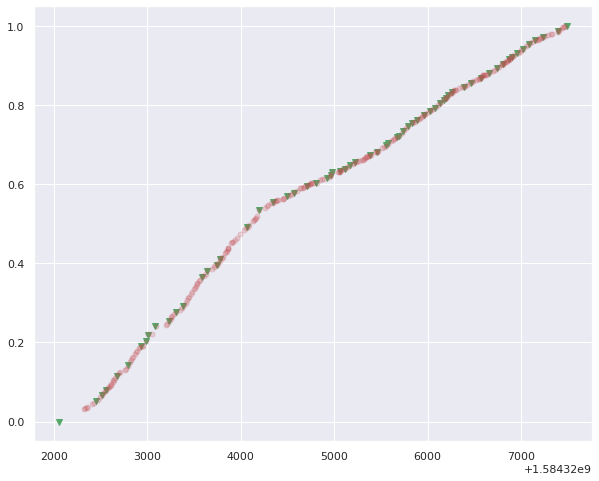

Predict for trips TRIPS01
There is no decrease distance


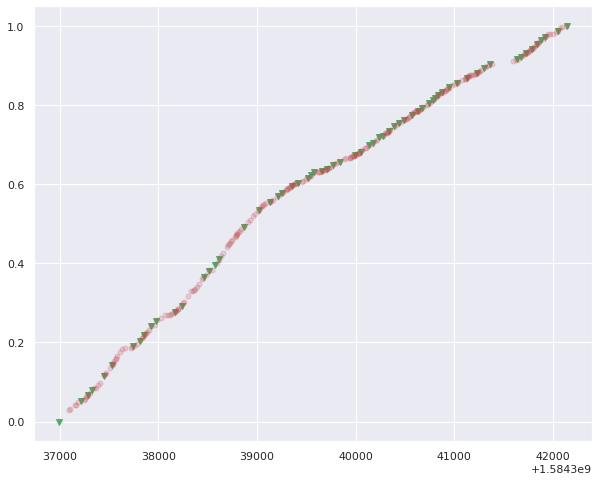

Predict for trips TRIPS02
There is no decrease distance


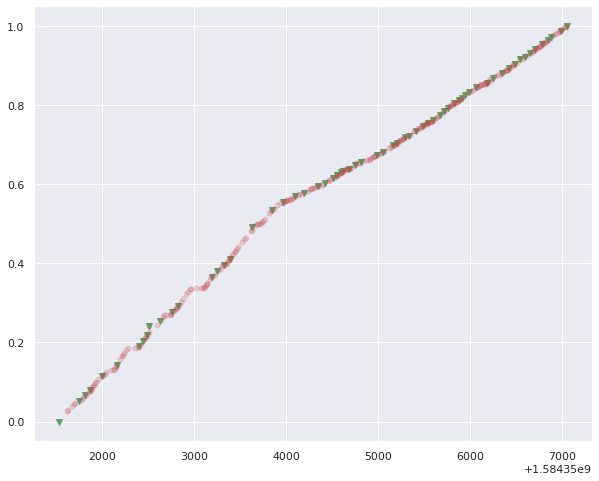

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02


In [550]:
time_tables = predict_whole_route_all_bus(predic_df, 
                                          stops_distance, 
                                          route_id=51, 
                                          routevar_id=2, 
                                          plot=(True, True),
                                          cols=cols_to_get, 
                                          ratio_distance=0.8)

In [551]:
time_tables.tail()

ADDRESSNO             ARRIVETIMETRIPS00  \
827                          190 2020-03-16 09:51:26.661978722   
828                          248 2020-03-16 09:52:27.140688419   
829                          234 2020-03-16 09:53:57.992617130   
830                          214 2020-03-16 09:56:38.490153074   
831  Bến xe buýt Cư xá Nhiêu Lộc 2020-03-16 09:58:09.024730682   

                ARRIVETIMETRIPS01             ARRIVETIMETRIPS02  \
827 2020-03-16 13:57:16.684327602 2020-03-16 18:06:21.173133135   
828 2020-03-16 13:57:58.510606289 2020-03-16 18:07:19.075939178   
829 2020-03-16 13:58:39.736173868 2020-03-16 18:07:59.066944598   
830 2020-03-16 14:00:50.965422153 2020-03-16 18:09:40.237592936   
831 2020-03-16 14:02:19.664418697 2020-03-16 18:10:45.784689188   

    ARRIVETIMETRIPS03 BUSPREDIC     CODE       LAT        LNG  \
827               NaT   53N4967  QTP 112 10.789867 106.623999   
828               NaT   53N4967  QTP 113 10.790178 106.621381   
829               NaT   53N4967  QTP 114 10.789883 106.618996   
830               NaT   53N4967  QTP 116 10.788112 106.618820   
831               NaT   53N4967     BX54 10.787617 106.622057   

                   NAME      RANK  ROUTEID      ROUTES  ROUTEVARID  \
827   Nhà Thờ Tân Hương 60.000000       51      30, 41           2   
828  Trạm Chợ Tân Hương 61.000000       51  30, 32, 69           2   
829              Lê Sát 62.000000       51          30           2   
830           Bình Long 63.000000       51     144, 30           2   
831     Cư xá Nhiêu Lộc 64.000000       51     144, 30           2   

               SEARCH          STATUS  STOPID  STOPTYPE         STREET  \
827       NTTH 190 TH  Đang khai thác    2722  Trụ dừng      Tân Hương   
828       TCTH 248 TH  Đang khai thác    2584  Trụ dừng      Tân Hương   
829         LS 234 TH  Đang khai thác    2720  Trụ dừng      Tân Hương   
830        BL 214 LTH  Đang khai thác    1614  Trụ dừng  Lê Thúc Hoạch   
831  CxNL BxbCxNL LTH  Đang khai thác    1560    Bến xe  Lê Thúc Hoạch   

    SUPPORTDISABILITY            WARD          ZONE  
827                    Phường Tân Qúy  Quận Tân Phú  
828                    Phường Tân Qúy  Quận Tân Phú  
829                    Phường Tân Qúy  Quận Tân Phú  
830                              None  Quận Tân Phú  
831                              None  Quận Tân Phú

In [552]:
time_tables.to_excel("../data/result/timetables_attempt_20210228.xlsx", index=False)

In [313]:
# time tables for 1 stop on 1 route and routevar
time_tables[time_tables["STOPID"]==2722].sort_values(["ARRIVETIMETRIPS00"])

ADDRESSNO             ARRIVETIMETRIPS00             ARRIVETIMETRIPS01  \
123       190 2020-03-16 06:15:53.214054108 2020-03-16 10:16:15.555601120   
187       190 2020-03-16 06:36:51.423377991 2020-03-16 10:43:25.493020535   
251       190 2020-03-16 06:55:40.080175877 2020-03-16 11:01:42.814252377   
315       190 2020-03-16 07:18:29.936989546 2020-03-16 11:23:20.668480396   
379       190 2020-03-16 07:40:42.626067400 2020-03-16 11:47:18.072053909   
443       190 2020-03-16 08:00:58.492936373 2020-03-16 12:11:35.338921070   
59        190 2020-03-16 08:19:53.951335192 2020-03-16 12:22:08.133057594   
507       190 2020-03-16 08:33:10.004537344 2020-03-16 12:30:07.345412970   
571       190 2020-03-16 09:02:33.934209347 2020-03-16 12:49:11.372462511   
635       190 2020-03-16 09:12:11.669121265 2020-03-16 13:06:56.663247585   
763       190 2020-03-16 09:30:02.786606073 2020-03-16 13:28:49.175686121   
827       190 2020-03-16 09:51:26.661978722 2020-03-16 13:57:16.684327602   
699       190 2020-03-16 10:12:44.329338312 2020-03-16 14:12:47.867156029   

                ARRIVETIMETRIPS02             ARRIVETIMETRIPS03 BUSPREDIC  \
123 2020-03-16 14:23:59.740983725 2020-03-16 18:35:04.707052231   53N5002   
187 2020-03-16 14:48:29.604715586 2020-03-16 18:57:50.212227583   53N5040   
251 2020-03-16 15:03:04.487083435 2020-03-16 19:20:24.451599121   53N5053   
315 2020-03-16 15:29:17.428259134 2020-03-16 19:39:24.609909534   53N5013   
379 2020-03-16 15:52:16.951475859 2020-03-16 19:55:50.959511518  51B31288   
443 2020-03-16 16:13:30.957442999 2020-03-16 20:19:32.376268387   53N4917   
59  2020-03-16 16:39:41.813494205                           NaT   53N4414   
507 2020-03-16 16:45:45.103467226                           NaT  51B28892   
571 2020-03-16 17:20:16.995761633                           NaT  51B31233   
635 2020-03-16 17:26:36.762715340                           NaT   53N5049   
763 2020-03-16 17:48:46.007185698                           NaT  51B26345   
827 2020-03-16 18:06:21.173133135                           NaT   53N4967   
699 2020-03-16 18:22:11.581086636                           NaT  51B26267   

        CODE       LAT        LNG               NAME      RANK  ROUTEID  \
123  QTP 112 10.789867 106.623999  Nhà Thờ Tân Hương 60.000000       51   
187  QTP 112 10.789867 106.623999  Nhà Thờ Tân Hương 60.000000       51   
251  QTP 112 10.789867 106.623999  Nhà Thờ Tân Hương 60.000000       51   
315  QTP 112 10.789867 106.623999  Nhà Thờ Tân Hương 60.000000       51   
379  QTP 112 10.789867 106.623999  Nhà Thờ Tân Hương 60.000000       51   
443  QTP 112 10.789867 106.623999  Nhà Thờ Tân Hương 60.000000       51   
59   QTP 112 10.789867 106.623999  Nhà Thờ Tân Hương 60.000000       51   
507  QTP 112 10.789867 106.623999  Nhà Thờ Tân Hương 60.000000       51   
571  QTP 112 10.789867 106.623999  Nhà Thờ Tân Hương 60.000000       51   
635  QTP 112 10.789867 106.623999  Nhà Thờ Tân Hương 60.000000       51   
763  QTP 112 10.789867 106.623999  Nhà Thờ Tân Hương 60.000000       51   
827  QTP 112 10.789867 106.623999  Nhà Thờ Tân Hương 60.000000       51   
699  QTP 112 10.789867 106.623999  Nhà Thờ Tân Hương 60.000000       51   

     ROUTES  ROUTEVARID       SEARCH          STATUS  STOPID  STOPTYPE  \
123  30, 41           2  NTTH 190 TH  Đang khai thác    2722  Trụ dừng   
187  30, 41           2  NTTH 190 TH  Đang khai thác    2722  Trụ dừng   
251  30, 41           2  NTTH 190 TH  Đang khai thác    2722  Trụ dừng   
315  30, 41           2  NTTH 190 TH  Đang khai thác    2722  Trụ dừng   
379  30, 41           2  NTTH 190 TH  Đang khai thác    2722  Trụ dừng   
443  30, 41           2  NTTH 190 TH  Đang khai thác    2722  Trụ dừng   
59   30, 41           2  NTTH 190 TH  Đang khai thác    2722  Trụ dừng   
507  30, 41           2  NTTH 190 TH  Đang khai thác    2722  Trụ dừng   
571  30, 41           2  NTTH 190 TH  Đang khai thác    2722  Trụ dừng   
635  30, 41           2  NTTH 190 TH  Đang khai thác   